In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "1" for second notebook


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Tuple, Dict, Any
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from typing import Tuple, Dict, List, Optional, Union
import random
from torchvision import transforms
import torchvision.transforms.functional as TF

In [3]:
from DatasetsLoader import PyTorchDatasetLoader, DatasetLoaderWrapper

In [4]:
device = torch.device("cuda:1")  

In [5]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    if num_gpus > 0:
        for i in range(num_gpus):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"GPU {i} Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")
    # Set the device to the first GPU by default, DataParallel will handle distribution
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')
    print("CUDA not available. Training on CPU.")

print(f"Using device: {device}")

Number of GPUs available: 1
GPU 0: NVIDIA RTX A5000
GPU 0 Memory: 23.5 GB
Using device: cuda:1


In [6]:
from DatasetsLoaderSplits import PyTorchDatasetLoader, DatasetLoaderWrapper
import torch

def create_pytorch_datasets(
    working_path: str, 
    batch_size: int, 
    export_type: str, 
    input_shape: Optional[Tuple[int, int, int]] = None,
    augmentation: bool = False,
    num_workers: int = 4,
    test_size: float = 0.15,
    val_size: float = 0.15
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    
    # Training dataset with augmentation
    train_dataset = PyTorchDatasetLoader(
        working_path=working_path,
        export_type=export_type,
        outputs_type="both",
        augmentation=augmentation,
        shuffle=True,
        test_size=test_size,
        val_size=val_size,
        split_type="train"
    )
    
    # Validation dataset without augmentation
    val_dataset = PyTorchDatasetLoader(
        working_path=working_path,
        export_type=export_type,
        outputs_type="both",
        augmentation=False,
        shuffle=False,
        test_size=test_size,
        val_size=val_size,
        split_type="val"
    )
    
    # Test dataset without augmentation
    test_dataset = PyTorchDatasetLoader(
        working_path=working_path,
        export_type=export_type,
        outputs_type="both",
        augmentation=False,
        shuffle=False,
        test_size=test_size,
        val_size=val_size,
        split_type="test"
    )
    
    # Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True 
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    return train_dataloader, val_dataloader, test_dataloader

In [7]:

class ModelTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        val_dataloader,
        device,
        learning_rate=0.001,
        seg_weight=1.0,
        cls_weight=0.5,
        pos_weight=2.0,
        model_name="model_ndvi",
        lr_sch=False,
    ):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_name = model_name
        self.device = device
        self.lr_sch = lr_sch
        # Setup optimizer and criterion
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        if lr_sch :
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, mode='min', factor=0.5, patience=10, verbose=True
            )
        else :
            self.scheduler = None
        self.learning_rate = learning_rate
        self.criterion = MultiTaskLoss(seg_weight, cls_weight, pos_weight).to(device)
        
        # History tracking
        self.history = {
            'train_loss': [],
            'train_seg_loss': [],
            'train_cls_loss': [],
            'train_dice': [],
            'train_cls_acc': [],
            'val_loss': [],
            'val_seg_loss': [],
            'val_cls_loss': [],
            'val_dice': [],
            'val_cls_acc': [],
            'learning_rate': []
        }
        
        self.best_val_loss = float('inf')
        self.best_model_state = None
    
    def calculate_dice_score(self, pred, target, smooth=1e-6):
        """Calculate Dice coefficient"""
        pred = (pred > 0.5).float()
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice.item()
    
    def calculate_accuracy(self, pred, target):
        """Calculate classification accuracy"""
        pred_classes = (pred > 0.5).float()
        correct = (pred_classes == target).float().sum()
        total = target.numel()
        return (correct / total).item()
    
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        running_seg_loss = 0.0
        running_cls_loss = 0.0
        running_dice = 0.0
        running_cls_acc = 0.0
        num_batches = 0
        
        pbar = tqdm(self.train_dataloader, desc='Training')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs = inputs.to(self.device)
            targets = {k: v.to(self.device) for k, v in targets.items()}
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(inputs)
            
            # Calculate loss
            loss_dict = self.criterion(outputs, targets)
            total_loss = loss_dict['total_loss']
            
            # Backward pass
            total_loss.backward()
            self.optimizer.step()
            
            # Calculate metrics
            dice_score = self.calculate_dice_score(
                outputs['segmentation_output'], 
                targets['segmentation_output']
            )
            cls_acc = self.calculate_accuracy(
                outputs['classification_output'], 
                targets['classification_output']
            )
            
            # Update running metrics
            running_loss += total_loss.item()
            running_seg_loss += loss_dict['segmentation_loss'].item()
            running_cls_loss += loss_dict['classification_loss'].item()
            running_dice += dice_score
            running_cls_acc += cls_acc
            num_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'Dice': f'{dice_score:.4f}',
                'Acc': f'{cls_acc:.4f}'
            })
        
        # Calculate average metrics
        avg_loss = running_loss / num_batches
        avg_seg_loss = running_seg_loss / num_batches
        avg_cls_loss = running_cls_loss / num_batches
        avg_dice = running_dice / num_batches
        avg_cls_acc = running_cls_acc / num_batches
        
        return avg_loss, avg_seg_loss, avg_cls_loss, avg_dice, avg_cls_acc
    
    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        running_seg_loss = 0.0
        running_cls_loss = 0.0
        running_dice = 0.0
        running_cls_acc = 0.0
        num_batches = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_dataloader, desc='Validation')
            for inputs, targets in pbar:
                inputs = inputs.to(self.device)
                targets = {k: v.to(self.device) for k, v in targets.items()}
                
                # Forward pass
                outputs = self.model(inputs)
                
                # Calculate loss
                loss_dict = self.criterion(outputs, targets)
                total_loss = loss_dict['total_loss']
                
                # Calculate metrics
                dice_score = self.calculate_dice_score(
                    outputs['segmentation_output'], 
                    targets['segmentation_output']
                )
                cls_acc = self.calculate_accuracy(
                    outputs['classification_output'], 
                    targets['classification_output']
                )
                
                # Update running metrics
                running_loss += total_loss.item()
                running_seg_loss += loss_dict['segmentation_loss'].item()
                running_cls_loss += loss_dict['classification_loss'].item()
                running_dice += dice_score
                running_cls_acc += cls_acc
                num_batches += 1
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{total_loss.item():.4f}',
                    'Dice': f'{dice_score:.4f}',
                    'Acc': f'{cls_acc:.4f}'
                })
        
        # Calculate average metrics
        avg_loss = running_loss / num_batches
        avg_seg_loss = running_seg_loss / num_batches
        avg_cls_loss = running_cls_loss / num_batches
        avg_dice = running_dice / num_batches
        avg_cls_acc = running_cls_acc / num_batches
        
        return avg_loss, avg_seg_loss, avg_cls_loss, avg_dice, avg_cls_acc
    
    def save_checkpoint(self, epoch, save_dir='checkpoints'):
        """Save model checkpoint"""
        os.makedirs(save_dir, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict() if self.lr_sch else self.learning_rate,
            'best_val_loss': self.best_val_loss,
            'history': self.history
        }
        
        # Save latest checkpoint
        torch.save(checkpoint, os.path.join(save_dir, 'latest_checkpoint.pth'))
        
        # Save best model
        if self.best_model_state is not None:
            best_checkpoint = checkpoint.copy()
            best_checkpoint['model_state_dict'] = self.best_model_state
            torch.save(best_checkpoint, os.path.join(save_dir, 'best_model.pth'))
    
    def save_history(self, save_dir='results'):
        """Save training history"""
        os.makedirs(save_dir, exist_ok=True)
        
        # Save as JSON
        with open(os.path.join(save_dir,f'{self.model_name}_training_history.json'), 'w') as f:
            json.dump(self.history, f, indent=2)
        
        # Save as numpy
        np.save(os.path.join(save_dir, f'{self.model_name}_training_history.npy'), self.history)

        # save model

        torch.save(self.model, f'./results/{self.model_name}_multitask.pth')

        
    
    def plot_history(self, save_dir='results'):
        """Plot and save training history"""
        os.makedirs(save_dir, exist_ok=True)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot losses
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Total Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot segmentation loss
        axes[0, 1].plot(self.history['train_seg_loss'], label='Train Seg Loss', color='blue')
        axes[0, 1].plot(self.history['val_seg_loss'], label='Val Seg Loss', color='red')
        axes[0, 1].set_title('Segmentation Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Plot classification loss
        axes[0, 2].plot(self.history['train_cls_loss'], label='Train Cls Loss', color='blue')
        axes[0, 2].plot(self.history['val_cls_loss'], label='Val Cls Loss', color='red')
        axes[0, 2].set_title('Classification Loss')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
        
        # Plot Dice score
        axes[1, 0].plot(self.history['train_dice'], label='Train Dice', color='blue')
        axes[1, 0].plot(self.history['val_dice'], label='Validation Dice', color='red')
        axes[1, 0].set_title('Dice Coefficient')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Dice Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Plot classification accuracy
        axes[1, 1].plot(self.history['train_cls_acc'], label='Train Accuracy', color='blue')
        axes[1, 1].plot(self.history['val_cls_acc'], label='Val Accuracy', color='red')
        axes[1, 1].set_title('Classification Accuracy')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        # Plot learning rate
        axes[1, 2].plot(self.history['learning_rate'], color='green')
        axes[1, 2].set_title('Learning Rate')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{self.model_name}_training_history.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    def train(self, num_epochs, save_every=10):
        """Main training loop"""
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            # Train
            train_loss, train_seg_loss, train_cls_loss, train_dice, train_cls_acc = self.train_epoch()
            
            # Validate
            val_loss, val_seg_loss, val_cls_loss, val_dice, val_cls_acc = self.validate_epoch()
            
            # Update learning rate scheduler
            if self.lr_sch:
                self.scheduler.step(val_loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['train_seg_loss'].append(train_seg_loss)
            self.history['train_cls_loss'].append(train_cls_loss)
            self.history['train_dice'].append(train_dice)
            self.history['train_cls_acc'].append(train_cls_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_seg_loss'].append(val_seg_loss)
            self.history['val_cls_loss'].append(val_cls_loss)
            self.history['val_dice'].append(val_dice)
            self.history['val_cls_acc'].append(val_cls_acc)
            self.history['learning_rate'].append(current_lr)
            
            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_state = self.model.state_dict().copy()
                print(f"New best model! Validation loss: {val_loss:.6f}")
            
            # Print epoch summary
            print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
            print(f"Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f}")
            print(f"Train Acc: {train_cls_acc:.4f} | Val Acc: {val_cls_acc:.4f}")
            print(f"Learning Rate: {current_lr:.8f}")
            
            # Save checkpoint periodically
            if (epoch + 1) % save_every == 0:
                self.save_checkpoint(epoch + 1)
                self.save_history()
                print(f"Checkpoint saved at epoch {epoch + 1}")
        
        # Final save
        self.save_checkpoint(num_epochs)
        self.save_history()
        self.plot_history()
        
        print("\nTraining completed!")
        print(f"Best validation loss: {self.best_val_loss:.6f}")
        
        return self.history

In [8]:

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, 
                                 padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SeparableResidualBlock(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_size=3):
        super(SeparableResidualBlock, self).__init__()
        padding = kernel_size // 2
        
        self.sep_conv1 = SeparableConv2d(in_channels, num_filters, kernel_size, padding)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.sep_conv2 = SeparableConv2d(num_filters, num_filters, kernel_size, padding)
        self.bn2 = nn.BatchNorm2d(num_filters)
        
        self.skip_conv = None
        if in_channels != num_filters:
            self.skip_conv = nn.Conv2d(in_channels, num_filters, 1, bias=False)
    
    def forward(self, x):
        residual = x
        
        out = self.sep_conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.sep_conv2(out)
        out = self.bn2(out)
        
        if self.skip_conv is not None:
            residual = self.skip_conv(residual)
        
        out = out + residual
        out = F.relu(out)
        return out

class LiteEncoderBlock(nn.Module):
    def __init__(self, in_channels, num_filters, dropout_rate=0.1):
        super(LiteEncoderBlock, self).__init__()
        self.sep_conv = SeparableConv2d(in_channels, num_filters, 3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.sep_conv(x)
        x = self.bn(x)
        x = F.relu(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
        
        skip = x
        pooled = self.pool(x)
        return skip, pooled

class LiteDecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, num_filters, dropout_rate=0.1):
        super(LiteDecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, num_filters, 3, stride=2, padding=1, output_padding=1)
        self.sep_conv = SeparableConv2d(num_filters + skip_channels, num_filters, 3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None
    
    def forward(self, x, skip_features):
        x = self.upsample(x)
        
        # Handle size mismatch
        if x.shape[2:] != skip_features.shape[2:]:
            x = F.interpolate(x, size=skip_features.shape[2:], mode='bilinear', align_corners=False)
        
        x = torch.cat([x, skip_features], dim=1)
        x = self.sep_conv(x)
        x = self.bn(x)
        x = F.relu(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
        
        return x

class OptimizedMultiTaskUNet512(nn.Module):
    def __init__(self, input_channels, num_classes, filters_base=16, dropout_rate=0.1):
        super(OptimizedMultiTaskUNet512, self).__init__()
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, filters_base, 3, padding=1, bias=False),
            nn.BatchNorm2d(filters_base),
            nn.ReLU(inplace=True)
        )
        
        # Encoder blocks
        self.encoder1 = LiteEncoderBlock(filters_base, filters_base, dropout_rate)
        self.encoder2 = LiteEncoderBlock(filters_base, filters_base*2, dropout_rate)
        self.encoder3 = LiteEncoderBlock(filters_base*2, filters_base*4, dropout_rate)
        self.encoder4 = LiteEncoderBlock(filters_base*4, filters_base*8, dropout_rate)
        self.encoder5 = LiteEncoderBlock(filters_base*8, filters_base*16, dropout_rate)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            SeparableResidualBlock(filters_base*16, filters_base*32),
            nn.Dropout2d(dropout_rate*2)
        )
        
        # Decoder blocks
        self.decoder1 = LiteDecoderBlock(filters_base*32, filters_base*16, filters_base*16, dropout_rate)
        self.decoder2 = LiteDecoderBlock(filters_base*16, filters_base*8, filters_base*8, dropout_rate)
        self.decoder3 = LiteDecoderBlock(filters_base*8, filters_base*4, filters_base*4, dropout_rate)
        self.decoder4 = LiteDecoderBlock(filters_base*4, filters_base*2, filters_base*2, dropout_rate)
        self.decoder5 = LiteDecoderBlock(filters_base*2, filters_base, filters_base, dropout_rate)
        
        # Segmentation output
        self.segmentation_head = nn.Conv2d(filters_base, 1, 1)
        
        # Classification branch
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.classification_head = nn.Sequential(
            nn.Linear(filters_base*32*2, 128),  # *2 for avg and max pooling concat
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Initial convolution
        x = self.initial_conv(x)
        
        # Encoder path
        s1, p1 = self.encoder1(x)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)
        s5, p5 = self.encoder5(p4)
        
        # Bottleneck
        bottleneck = self.bottleneck(p5)
        
        # Decoder path
        d1 = self.decoder1(bottleneck, s5)
        d2 = self.decoder2(d1, s4)
        d3 = self.decoder3(d2, s3)
        d4 = self.decoder4(d3, s2)
        d5 = self.decoder5(d4, s1)
        
        # Segmentation output
        segmentation_output = torch.sigmoid(self.segmentation_head(d5))
        
        # Classification branch
        avg_pool = self.global_avg_pool(bottleneck).view(bottleneck.size(0), -1)
        max_pool = self.global_max_pool(bottleneck).view(bottleneck.size(0), -1)
        pooled_features = torch.cat([avg_pool, max_pool], dim=1)
        
        classification_output = torch.softmax(self.classification_head(pooled_features), dim=1)
        
        return {
            'classification_output': classification_output,
            'segmentation_output': segmentation_output
        }


In [9]:

# Loss Functions
def binary_dice_coefficient(y_pred, y_true, smooth=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def binary_dice_loss(y_pred, y_true):
    return 1 - binary_dice_coefficient(y_pred, y_true)

def weighted_binary_crossentropy(y_pred, y_true, pos_weight=1.0):
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    pos_loss = pos_weight * y_true * torch.log(y_pred)
    neg_loss = (1 - y_true) * torch.log(1 - y_pred)
    return -torch.mean(pos_loss + neg_loss)

def combined_segmentation_loss(y_pred, y_true, pos_weight=2.0):
    bce_loss = weighted_binary_crossentropy(y_pred, y_true, pos_weight)
    dice_loss = binary_dice_loss(y_pred, y_true)
    return bce_loss + dice_loss


In [10]:

class MultiTaskLoss(nn.Module):
    def __init__(self, seg_weight=1.0, cls_weight=0.5, pos_weight=2.0):
        super(MultiTaskLoss, self).__init__()
        self.seg_weight = seg_weight
        self.cls_weight = cls_weight
        self.pos_weight = pos_weight
        self.cls_criterion = nn.BCELoss()  # or nn.CrossEntropyLoss() depending on your classification task
    
    def forward(self, predictions, targets):
        seg_pred = predictions['segmentation_output']
        cls_pred = predictions['classification_output']
        seg_target = targets['segmentation_output']
        cls_target = targets['classification_output']
        
        # Segmentation loss
        seg_loss = combined_segmentation_loss(seg_pred, seg_target, self.pos_weight)
        
        # Classification loss
        cls_loss = self.cls_criterion(cls_pred, cls_target)
        
        # Combined loss
        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss
        
        return {
            'total_loss': total_loss,
            'segmentation_loss': seg_loss,
            'classification_loss': cls_loss
        }


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, 
                                 padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SeparableResidualBlock(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_size=3):
        super(SeparableResidualBlock, self).__init__()
        padding = kernel_size // 2
        
        self.sep_conv1 = SeparableConv2d(in_channels, num_filters, kernel_size, padding)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.sep_conv2 = SeparableConv2d(num_filters, num_filters, kernel_size, padding)
        self.bn2 = nn.BatchNorm2d(num_filters)
        
        self.skip_conv = None
        if in_channels != num_filters:
            self.skip_conv = nn.Conv2d(in_channels, num_filters, 1, bias=False)
    
    def forward(self, x):
        residual = x
        
        out = self.sep_conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.sep_conv2(out)
        out = self.bn2(out)
        
        if self.skip_conv is not None:
            residual = self.skip_conv(residual)
        
        out = out + residual
        out = F.relu(out)
        return out

class LiteEncoderBlock(nn.Module):
    def __init__(self, in_channels, num_filters, dropout_rate=0.1):
        super(LiteEncoderBlock, self).__init__()
        self.sep_conv = SeparableConv2d(in_channels, num_filters, 3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.sep_conv(x)
        x = self.bn(x)
        x = F.relu(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
        
        skip = x
        pooled = self.pool(x)
        return skip, pooled

class LiteDecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, num_filters, dropout_rate=0.1):
        super(LiteDecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, num_filters, 3, stride=2, padding=1, output_padding=1)
        self.sep_conv = SeparableConv2d(num_filters + skip_channels, num_filters, 3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None
    
    def forward(self, x, skip_features):
        x = self.upsample(x)
        
        # Handle size mismatch
        if x.shape[2:] != skip_features.shape[2:]:
            x = F.interpolate(x, size=skip_features.shape[2:], mode='bilinear', align_corners=False)
        
        x = torch.cat([x, skip_features], dim=1)
        x = self.sep_conv(x)
        x = self.bn(x)
        x = F.relu(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
        
        return x

class OptimizedMultiTaskUNet256(nn.Module):
    def __init__(self, input_channels, num_classes, filters_base=16, dropout_rate=0.1):
        super(OptimizedMultiTaskUNet256, self).__init__()
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, filters_base, 3, padding=1, bias=False),
            nn.BatchNorm2d(filters_base),
            nn.ReLU(inplace=True)
        )
        
        # Encoder blocks - Reduced from 5 to 4 levels for 256x256 input
        # 256 -> 128 -> 64 -> 32 -> 16 -> 8 (bottleneck)
        self.encoder1 = LiteEncoderBlock(filters_base, filters_base, dropout_rate)         # 256->128
        self.encoder2 = LiteEncoderBlock(filters_base, filters_base*2, dropout_rate)       # 128->64
        self.encoder3 = LiteEncoderBlock(filters_base*2, filters_base*4, dropout_rate)     # 64->32
        self.encoder4 = LiteEncoderBlock(filters_base*4, filters_base*8, dropout_rate)     # 32->16
        
        # Bottleneck - at 16x16 resolution for 256x256 input
        self.bottleneck = nn.Sequential(
            SeparableResidualBlock(filters_base*8, filters_base*16),
            nn.Dropout2d(dropout_rate*2)
        )
        
        # Decoder blocks - Match the encoder structure
        self.decoder1 = LiteDecoderBlock(filters_base*16, filters_base*8, filters_base*8, dropout_rate)   # 16->32
        self.decoder2 = LiteDecoderBlock(filters_base*8, filters_base*4, filters_base*4, dropout_rate)    # 32->64
        self.decoder3 = LiteDecoderBlock(filters_base*4, filters_base*2, filters_base*2, dropout_rate)    # 64->128
        self.decoder4 = LiteDecoderBlock(filters_base*2, filters_base, filters_base, dropout_rate)        # 128->256
        
        # Segmentation output - outputs 256x256 mask
        self.segmentation_head = nn.Conv2d(filters_base, 1, 1)
        
        # Classification branch
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.classification_head = nn.Sequential(
            nn.Linear(filters_base*16*2, 128),  # *2 for avg and max pooling concat
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Ensure input is 256x256
        if x.shape[2] != 256 or x.shape[3] != 256:
            x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        
        # Initial convolution
        x = self.initial_conv(x)  # 256x256
        
        # Encoder path
        s1, p1 = self.encoder1(x)    # skip: 256x256, pooled: 128x128
        s2, p2 = self.encoder2(p1)   # skip: 128x128, pooled: 64x64
        s3, p3 = self.encoder3(p2)   # skip: 64x64, pooled: 32x32
        s4, p4 = self.encoder4(p3)   # skip: 32x32, pooled: 16x16
        
        # Bottleneck
        bottleneck = self.bottleneck(p4)  # 16x16
        
        # Decoder path
        d1 = self.decoder1(bottleneck, s4)  # 16x16 -> 32x32
        d2 = self.decoder2(d1, s3)          # 32x32 -> 64x64
        d3 = self.decoder3(d2, s2)          # 64x64 -> 128x128
        d4 = self.decoder4(d3, s1)          # 128x128 -> 256x256
        
        # Segmentation output - 256x256
        segmentation_output = torch.sigmoid(self.segmentation_head(d4))
        
        # Classification branch
        avg_pool = self.global_avg_pool(bottleneck).view(bottleneck.size(0), -1)
        max_pool = self.global_max_pool(bottleneck).view(bottleneck.size(0), -1)
        pooled_features = torch.cat([avg_pool, max_pool], dim=1)
        
        classification_output = torch.softmax(self.classification_head(pooled_features), dim=1)
        
        return {
            'classification_output': classification_output,
            'segmentation_output': segmentation_output
        }

In [12]:
epochs = 200

In [13]:
CONFIG = {
    'working_path': 'train-256',
    'batch_size': 80,
    'export_type': 'NDVI',
    'input_channels': 1,  # 1 for NDVI, 3 for RGB, 4 for RGBN
    'num_classes': 6,
    'filters_base': 32,
    'dropout_rate': 0.15,
    'learning_rate': 0.001,
    'num_epochs': epochs,
    'seg_weight': 1.0,
    'cls_weight': 0.5,
    'pos_weight': 2.0,
    'augmentation': True,
    'num_workers': 16
}

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Create datasets
print("Creating datasets...")
train_dataloader, val_dataloader, test_dataloader = create_pytorch_datasets(
    working_path=CONFIG['working_path'],
    batch_size=CONFIG['batch_size'],
    export_type=CONFIG['export_type'],
    augmentation=CONFIG['augmentation'],
    test_size=0.20,  # 20%
    val_size=0.05    # 5%
)

print(f"Training samples: {len(train_dataloader.dataset)}")
print(f"Validation samples: {len(val_dataloader.dataset)}")
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")

print("Creating model...")
model = OptimizedMultiTaskUNet256(
    input_channels=CONFIG['input_channels'],
    num_classes=CONFIG['num_classes'],
    filters_base=CONFIG['filters_base'],
    dropout_rate=CONFIG['dropout_rate']
)


# model = model.load_state_dict(torch.load("results/rgbn_multitask.pth"))


# model = torch.load("results/ndvi_multitask.pth")

trainer_ndvi_256 = ModelTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=CONFIG['learning_rate'],
    seg_weight=CONFIG['seg_weight'],
    cls_weight=CONFIG['cls_weight'],
    pos_weight=CONFIG['pos_weight'],
    model_name="ndvi-256"
)

Using device: cuda
GPU: NVIDIA RTX A5000
GPU Memory: 23.5 GB
Creating datasets...
Split 'train': 4373 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Split 'val': 291 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Split 'test': 1166 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Training samples: 4373
Validation samples: 291
Training batches: 54
Validation batches: 4
Creating model...


Starting training for 200 epochs...
Device: cuda
Model parameters: 2,464,039

Epoch 1/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, Loss=1.4536, Dice=0.6138, Acc=0.8791]


New best model! Validation loss: 1.680754
Train Loss: 1.699903 | Val Loss: 1.680754
Train Dice: 0.3824 | Val Dice: 0.4406
Train Acc: 0.8330 | Val Acc: 0.8166
Learning Rate: 0.00100000

Epoch 2/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s, Loss=1.3486, Dice=0.6034, Acc=0.9216]


New best model! Validation loss: 1.602769
Train Loss: 1.640475 | Val Loss: 1.602769
Train Dice: 0.3823 | Val Dice: 0.4524
Train Acc: 0.8394 | Val Acc: 0.8554
Learning Rate: 0.00100000

Epoch 3/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=1.3418, Dice=0.6190, Acc=0.9183]


New best model! Validation loss: 1.569427
Train Loss: 1.623909 | Val Loss: 1.569427
Train Dice: 0.3834 | Val Dice: 0.4487
Train Acc: 0.8416 | Val Acc: 0.8645
Learning Rate: 0.00100000

Epoch 4/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, Loss=1.3424, Dice=0.6285, Acc=0.9118]


New best model! Validation loss: 1.565928
Train Loss: 1.607662 | Val Loss: 1.565928
Train Dice: 0.3924 | Val Dice: 0.4495
Train Acc: 0.8445 | Val Acc: 0.8696
Learning Rate: 0.00100000

Epoch 5/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=1.3076, Dice=0.6560, Acc=0.9052]


New best model! Validation loss: 1.552004
Train Loss: 1.591877 | Val Loss: 1.552004
Train Dice: 0.4071 | Val Dice: 0.4544
Train Acc: 0.8481 | Val Acc: 0.8508
Learning Rate: 0.00100000

Epoch 6/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, Loss=1.3556, Dice=0.6090, Acc=0.9085]


Train Loss: 1.575483 | Val Loss: 1.573402
Train Dice: 0.4256 | Val Dice: 0.4369
Train Acc: 0.8515 | Val Acc: 0.8422
Learning Rate: 0.00100000

Epoch 7/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, Loss=1.3539, Dice=0.6127, Acc=0.9052]


New best model! Validation loss: 1.514842
Train Loss: 1.563948 | Val Loss: 1.514842
Train Dice: 0.4168 | Val Dice: 0.4613
Train Acc: 0.8548 | Val Acc: 0.8680
Learning Rate: 0.00100000

Epoch 8/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, Loss=1.3346, Dice=0.6255, Acc=0.9052]


Train Loss: 1.542084 | Val Loss: 1.518681
Train Dice: 0.4400 | Val Dice: 0.4743
Train Acc: 0.8590 | Val Acc: 0.8732
Learning Rate: 0.00100000

Epoch 9/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, Loss=1.3715, Dice=0.6267, Acc=0.9052]


Train Loss: 1.525380 | Val Loss: 1.533604
Train Dice: 0.4447 | Val Dice: 0.4479
Train Acc: 0.8649 | Val Acc: 0.8648
Learning Rate: 0.00100000

Epoch 10/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s, Loss=1.2682, Dice=0.6468, Acc=0.9052]


New best model! Validation loss: 1.479281
Train Loss: 1.517722 | Val Loss: 1.479281
Train Dice: 0.4446 | Val Dice: 0.4830
Train Acc: 0.8679 | Val Acc: 0.8794
Learning Rate: 0.00100000
Checkpoint saved at epoch 10

Epoch 11/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.26it/s, Loss=1.2574, Dice=0.6576, Acc=0.9248]


New best model! Validation loss: 1.472644
Train Loss: 1.505671 | Val Loss: 1.472644
Train Dice: 0.4509 | Val Dice: 0.4873
Train Acc: 0.8707 | Val Acc: 0.8786
Learning Rate: 0.00100000

Epoch 12/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, Loss=1.3058, Dice=0.6476, Acc=0.8954]


Train Loss: 1.504636 | Val Loss: 1.502674
Train Dice: 0.4561 | Val Dice: 0.4795
Train Acc: 0.8714 | Val Acc: 0.8671
Learning Rate: 0.00100000

Epoch 13/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, Loss=1.2993, Dice=0.6446, Acc=0.9085]


Train Loss: 1.495119 | Val Loss: 1.481738
Train Dice: 0.4559 | Val Dice: 0.4640
Train Acc: 0.8724 | Val Acc: 0.8839
Learning Rate: 0.00100000

Epoch 14/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, Loss=1.1961, Dice=0.6559, Acc=0.9085]


New best model! Validation loss: 1.457029
Train Loss: 1.482749 | Val Loss: 1.457029
Train Dice: 0.4638 | Val Dice: 0.4844
Train Acc: 0.8759 | Val Acc: 0.8927
Learning Rate: 0.00100000

Epoch 15/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, Loss=1.2086, Dice=0.6530, Acc=0.9248]


Train Loss: 1.474702 | Val Loss: 1.460045
Train Dice: 0.4660 | Val Dice: 0.4931
Train Acc: 0.8774 | Val Acc: 0.8895
Learning Rate: 0.00100000

Epoch 16/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, Loss=1.2183, Dice=0.6605, Acc=0.9216]


New best model! Validation loss: 1.438251
Train Loss: 1.470055 | Val Loss: 1.438251
Train Dice: 0.4649 | Val Dice: 0.4923
Train Acc: 0.8799 | Val Acc: 0.8830
Learning Rate: 0.00100000

Epoch 17/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, Loss=1.2229, Dice=0.6644, Acc=0.9314]


New best model! Validation loss: 1.428171
Train Loss: 1.468799 | Val Loss: 1.428171
Train Dice: 0.4622 | Val Dice: 0.4963
Train Acc: 0.8814 | Val Acc: 0.8990
Learning Rate: 0.00100000

Epoch 18/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, Loss=1.1860, Dice=0.6710, Acc=0.9281]


New best model! Validation loss: 1.417532
Train Loss: 1.463811 | Val Loss: 1.417532
Train Dice: 0.4698 | Val Dice: 0.5019
Train Acc: 0.8796 | Val Acc: 0.8966
Learning Rate: 0.00100000

Epoch 19/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.21it/s, Loss=1.2057, Dice=0.6729, Acc=0.9346]


New best model! Validation loss: 1.413979
Train Loss: 1.455264 | Val Loss: 1.413979
Train Dice: 0.4759 | Val Dice: 0.4978
Train Acc: 0.8817 | Val Acc: 0.9071
Learning Rate: 0.00100000

Epoch 20/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s, Loss=1.1437, Dice=0.6931, Acc=0.9346]


New best model! Validation loss: 1.393908
Train Loss: 1.450341 | Val Loss: 1.393908
Train Dice: 0.4725 | Val Dice: 0.5061
Train Acc: 0.8834 | Val Acc: 0.9107
Learning Rate: 0.00100000
Checkpoint saved at epoch 20

Epoch 21/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, Loss=1.1239, Dice=0.6885, Acc=0.9412]


Train Loss: 1.451465 | Val Loss: 1.406948
Train Dice: 0.4696 | Val Dice: 0.5036
Train Acc: 0.8844 | Val Acc: 0.9098
Learning Rate: 0.00100000

Epoch 22/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=1.1003, Dice=0.7025, Acc=0.9314]


New best model! Validation loss: 1.388098
Train Loss: 1.439085 | Val Loss: 1.388098
Train Dice: 0.4768 | Val Dice: 0.5143
Train Acc: 0.8863 | Val Acc: 0.9084
Learning Rate: 0.00100000

Epoch 23/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, Loss=1.1028, Dice=0.6977, Acc=0.9412]


New best model! Validation loss: 1.387090
Train Loss: 1.434238 | Val Loss: 1.387090
Train Dice: 0.4794 | Val Dice: 0.5068
Train Acc: 0.8877 | Val Acc: 0.9150
Learning Rate: 0.00100000

Epoch 24/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, Loss=1.1857, Dice=0.6707, Acc=0.9510]


Train Loss: 1.428820 | Val Loss: 1.413826
Train Dice: 0.4838 | Val Dice: 0.5075
Train Acc: 0.8892 | Val Acc: 0.9174
Learning Rate: 0.00100000

Epoch 25/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=1.0889, Dice=0.7147, Acc=0.9248]


New best model! Validation loss: 1.356467
Train Loss: 1.418629 | Val Loss: 1.356467
Train Dice: 0.4839 | Val Dice: 0.5236
Train Acc: 0.8897 | Val Acc: 0.9140
Learning Rate: 0.00100000

Epoch 26/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Loss=1.1055, Dice=0.6941, Acc=0.9379]


Train Loss: 1.419227 | Val Loss: 1.387082
Train Dice: 0.4911 | Val Dice: 0.5060
Train Acc: 0.8916 | Val Acc: 0.9142
Learning Rate: 0.00100000

Epoch 27/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, Loss=1.1105, Dice=0.6986, Acc=0.9216]


Train Loss: 1.416359 | Val Loss: 1.383887
Train Dice: 0.4863 | Val Dice: 0.5180
Train Acc: 0.8917 | Val Acc: 0.8976
Learning Rate: 0.00100000

Epoch 28/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=1.1913, Dice=0.6660, Acc=0.9379]


Train Loss: 1.412157 | Val Loss: 1.388204
Train Dice: 0.4877 | Val Dice: 0.5130
Train Acc: 0.8926 | Val Acc: 0.9110
Learning Rate: 0.00100000

Epoch 29/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, Loss=1.1037, Dice=0.6828, Acc=0.9477]


Train Loss: 1.421856 | Val Loss: 1.364989
Train Dice: 0.4851 | Val Dice: 0.5227
Train Acc: 0.8917 | Val Acc: 0.9140
Learning Rate: 0.00100000

Epoch 30/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, Loss=1.0869, Dice=0.6977, Acc=0.9346]


New best model! Validation loss: 1.349355
Train Loss: 1.409693 | Val Loss: 1.349355
Train Dice: 0.4899 | Val Dice: 0.5236
Train Acc: 0.8922 | Val Acc: 0.9180
Learning Rate: 0.00100000
Checkpoint saved at epoch 30

Epoch 31/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=1.0955, Dice=0.6914, Acc=0.9412]


Train Loss: 1.409583 | Val Loss: 1.367796
Train Dice: 0.4906 | Val Dice: 0.5133
Train Acc: 0.8934 | Val Acc: 0.9233
Learning Rate: 0.00100000

Epoch 32/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=1.1443, Dice=0.6913, Acc=0.9150]


Train Loss: 1.402757 | Val Loss: 1.385713
Train Dice: 0.4960 | Val Dice: 0.5112
Train Acc: 0.8959 | Val Acc: 0.9090
Learning Rate: 0.00100000

Epoch 33/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, Loss=1.1441, Dice=0.6746, Acc=0.9281]


Train Loss: 1.401469 | Val Loss: 1.390351
Train Dice: 0.4950 | Val Dice: 0.5149
Train Acc: 0.8956 | Val Acc: 0.9008
Learning Rate: 0.00100000

Epoch 34/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, Loss=1.1268, Dice=0.6794, Acc=0.9477]


New best model! Validation loss: 1.346017
Train Loss: 1.404991 | Val Loss: 1.346017
Train Dice: 0.4907 | Val Dice: 0.5247
Train Acc: 0.8956 | Val Acc: 0.9291
Learning Rate: 0.00100000

Epoch 35/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s, Loss=1.1549, Dice=0.6665, Acc=0.9542]


Train Loss: 1.392109 | Val Loss: 1.361994
Train Dice: 0.4959 | Val Dice: 0.5178
Train Acc: 0.8988 | Val Acc: 0.9287
Learning Rate: 0.00100000

Epoch 36/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, Loss=1.1271, Dice=0.6834, Acc=0.9412]


Train Loss: 1.395998 | Val Loss: 1.373872
Train Dice: 0.4983 | Val Dice: 0.5173
Train Acc: 0.8966 | Val Acc: 0.9103
Learning Rate: 0.00100000

Epoch 37/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, Loss=1.1267, Dice=0.6799, Acc=0.9608]


Train Loss: 1.388699 | Val Loss: 1.353195
Train Dice: 0.5003 | Val Dice: 0.5237
Train Acc: 0.8992 | Val Acc: 0.9282
Learning Rate: 0.00100000

Epoch 38/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, Loss=1.1572, Dice=0.6716, Acc=0.9216]


Train Loss: 1.387649 | Val Loss: 1.396080
Train Dice: 0.4972 | Val Dice: 0.5071
Train Acc: 0.8989 | Val Acc: 0.9070
Learning Rate: 0.00100000

Epoch 39/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, Loss=1.1384, Dice=0.6873, Acc=0.9444]


Train Loss: 1.383796 | Val Loss: 1.365073
Train Dice: 0.5015 | Val Dice: 0.5239
Train Acc: 0.8998 | Val Acc: 0.9252
Learning Rate: 0.00100000

Epoch 40/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=1.1126, Dice=0.6834, Acc=0.9510]


Train Loss: 1.392502 | Val Loss: 1.353609
Train Dice: 0.4944 | Val Dice: 0.5285
Train Acc: 0.9002 | Val Acc: 0.9153
Learning Rate: 0.00100000
Checkpoint saved at epoch 40

Epoch 41/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, Loss=1.0860, Dice=0.7071, Acc=0.9412]


New best model! Validation loss: 1.344158
Train Loss: 1.382751 | Val Loss: 1.344158
Train Dice: 0.5022 | Val Dice: 0.5318
Train Acc: 0.8973 | Val Acc: 0.9124
Learning Rate: 0.00100000

Epoch 42/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=1.0422, Dice=0.7071, Acc=0.9477]


New best model! Validation loss: 1.338703
Train Loss: 1.377040 | Val Loss: 1.338703
Train Dice: 0.5029 | Val Dice: 0.5279
Train Acc: 0.9005 | Val Acc: 0.9244
Learning Rate: 0.00100000

Epoch 43/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, Loss=1.0275, Dice=0.7190, Acc=0.9542]


New best model! Validation loss: 1.331776
Train Loss: 1.366033 | Val Loss: 1.331776
Train Dice: 0.5051 | Val Dice: 0.5351
Train Acc: 0.9022 | Val Acc: 0.9235
Learning Rate: 0.00100000

Epoch 44/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, Loss=1.1467, Dice=0.6673, Acc=0.9575]


Train Loss: 1.372263 | Val Loss: 1.360686
Train Dice: 0.5051 | Val Dice: 0.5295
Train Acc: 0.9026 | Val Acc: 0.9253
Learning Rate: 0.00100000

Epoch 45/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=1.0612, Dice=0.7011, Acc=0.9444]


New best model! Validation loss: 1.322669
Train Loss: 1.363960 | Val Loss: 1.322669
Train Dice: 0.5095 | Val Dice: 0.5385
Train Acc: 0.9035 | Val Acc: 0.9288
Learning Rate: 0.00100000

Epoch 46/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, Loss=1.0404, Dice=0.6985, Acc=0.9510]


Train Loss: 1.368966 | Val Loss: 1.340676
Train Dice: 0.5046 | Val Dice: 0.5246
Train Acc: 0.9017 | Val Acc: 0.9242
Learning Rate: 0.00100000

Epoch 47/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.77it/s, Loss=1.0533, Dice=0.6984, Acc=0.9739]


Train Loss: 1.361308 | Val Loss: 1.340843
Train Dice: 0.5130 | Val Dice: 0.5249
Train Acc: 0.9019 | Val Acc: 0.9330
Learning Rate: 0.00100000

Epoch 48/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, Loss=1.0359, Dice=0.7117, Acc=0.9444]


Train Loss: 1.362316 | Val Loss: 1.332221
Train Dice: 0.5073 | Val Dice: 0.5372
Train Acc: 0.9052 | Val Acc: 0.9194
Learning Rate: 0.00100000

Epoch 49/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=1.1283, Dice=0.6712, Acc=0.9477]


Train Loss: 1.358983 | Val Loss: 1.344707
Train Dice: 0.5134 | Val Dice: 0.5320
Train Acc: 0.9022 | Val Acc: 0.9380
Learning Rate: 0.00100000

Epoch 50/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, Loss=1.0644, Dice=0.7016, Acc=0.9477]


Train Loss: 1.359203 | Val Loss: 1.352133
Train Dice: 0.5111 | Val Dice: 0.5210
Train Acc: 0.9064 | Val Acc: 0.9182
Learning Rate: 0.00100000
Checkpoint saved at epoch 50

Epoch 51/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=1.0536, Dice=0.7026, Acc=0.9608]


New best model! Validation loss: 1.316854
Train Loss: 1.358209 | Val Loss: 1.316854
Train Dice: 0.5090 | Val Dice: 0.5389
Train Acc: 0.9069 | Val Acc: 0.9402
Learning Rate: 0.00100000

Epoch 52/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=1.0880, Dice=0.6827, Acc=0.9510]


Train Loss: 1.346294 | Val Loss: 1.335720
Train Dice: 0.5153 | Val Dice: 0.5300
Train Acc: 0.9079 | Val Acc: 0.9169
Learning Rate: 0.00100000

Epoch 53/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, Loss=1.0263, Dice=0.7146, Acc=0.9673]


New best model! Validation loss: 1.311939
Train Loss: 1.355391 | Val Loss: 1.311939
Train Dice: 0.5119 | Val Dice: 0.5449
Train Acc: 0.9069 | Val Acc: 0.9304
Learning Rate: 0.00100000

Epoch 54/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, Loss=1.0263, Dice=0.7085, Acc=0.9575]


New best model! Validation loss: 1.308865
Train Loss: 1.350196 | Val Loss: 1.308865
Train Dice: 0.5159 | Val Dice: 0.5426
Train Acc: 0.9093 | Val Acc: 0.9295
Learning Rate: 0.00100000

Epoch 55/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, Loss=1.0630, Dice=0.6953, Acc=0.9542]


Train Loss: 1.341909 | Val Loss: 1.335728
Train Dice: 0.5186 | Val Dice: 0.5297
Train Acc: 0.9064 | Val Acc: 0.9240
Learning Rate: 0.00100000

Epoch 56/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, Loss=1.0492, Dice=0.7042, Acc=0.9641]


Train Loss: 1.349261 | Val Loss: 1.310180
Train Dice: 0.5168 | Val Dice: 0.5464
Train Acc: 0.9074 | Val Acc: 0.9348
Learning Rate: 0.00100000

Epoch 57/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=0.9841, Dice=0.7282, Acc=0.9477]


New best model! Validation loss: 1.303840
Train Loss: 1.341973 | Val Loss: 1.303840
Train Dice: 0.5132 | Val Dice: 0.5418
Train Acc: 0.9078 | Val Acc: 0.9296
Learning Rate: 0.00100000

Epoch 58/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=1.0276, Dice=0.7149, Acc=0.9542]


New best model! Validation loss: 1.283155
Train Loss: 1.334789 | Val Loss: 1.283155
Train Dice: 0.5218 | Val Dice: 0.5566
Train Acc: 0.9097 | Val Acc: 0.9334
Learning Rate: 0.00100000

Epoch 59/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=1.0786, Dice=0.6907, Acc=0.9608]


Train Loss: 1.339189 | Val Loss: 1.296466
Train Dice: 0.5177 | Val Dice: 0.5513
Train Acc: 0.9128 | Val Acc: 0.9324
Learning Rate: 0.00100000

Epoch 60/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=1.0590, Dice=0.6996, Acc=0.9477]


Train Loss: 1.342355 | Val Loss: 1.317723
Train Dice: 0.5148 | Val Dice: 0.5381
Train Acc: 0.9100 | Val Acc: 0.9255
Learning Rate: 0.00100000
Checkpoint saved at epoch 60

Epoch 61/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s, Loss=1.1085, Dice=0.6788, Acc=0.9608]


Train Loss: 1.334821 | Val Loss: 1.299145
Train Dice: 0.5207 | Val Dice: 0.5493
Train Acc: 0.9106 | Val Acc: 0.9282
Learning Rate: 0.00100000

Epoch 62/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s, Loss=1.0362, Dice=0.7002, Acc=0.9477]


Train Loss: 1.335965 | Val Loss: 1.296388
Train Dice: 0.5201 | Val Dice: 0.5447
Train Acc: 0.9115 | Val Acc: 0.9296
Learning Rate: 0.00100000

Epoch 63/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Loss=1.0447, Dice=0.7040, Acc=0.9641]


Train Loss: 1.332294 | Val Loss: 1.303332
Train Dice: 0.5215 | Val Dice: 0.5438
Train Acc: 0.9120 | Val Acc: 0.9311
Learning Rate: 0.00100000

Epoch 64/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s, Loss=1.0582, Dice=0.6910, Acc=0.9673]


Train Loss: 1.336694 | Val Loss: 1.296101
Train Dice: 0.5167 | Val Dice: 0.5475
Train Acc: 0.9095 | Val Acc: 0.9283
Learning Rate: 0.00100000

Epoch 65/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.21it/s, Loss=0.9634, Dice=0.7234, Acc=0.9673]


New best model! Validation loss: 1.271937
Train Loss: 1.328034 | Val Loss: 1.271937
Train Dice: 0.5201 | Val Dice: 0.5549
Train Acc: 0.9134 | Val Acc: 0.9387
Learning Rate: 0.00100000

Epoch 66/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s, Loss=1.0400, Dice=0.7048, Acc=0.9739]


Train Loss: 1.327450 | Val Loss: 1.288475
Train Dice: 0.5189 | Val Dice: 0.5502
Train Acc: 0.9128 | Val Acc: 0.9414
Learning Rate: 0.00100000

Epoch 67/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, Loss=1.0643, Dice=0.6935, Acc=0.9641]


Train Loss: 1.322479 | Val Loss: 1.320844
Train Dice: 0.5223 | Val Dice: 0.5348
Train Acc: 0.9133 | Val Acc: 0.9379
Learning Rate: 0.00100000

Epoch 68/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, Loss=1.0111, Dice=0.7055, Acc=0.9673]


Train Loss: 1.327986 | Val Loss: 1.304966
Train Dice: 0.5211 | Val Dice: 0.5403
Train Acc: 0.9130 | Val Acc: 0.9366
Learning Rate: 0.00100000

Epoch 69/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Loss=1.0739, Dice=0.6924, Acc=0.9771]


Train Loss: 1.326181 | Val Loss: 1.302793
Train Dice: 0.5236 | Val Dice: 0.5466
Train Acc: 0.9146 | Val Acc: 0.9422
Learning Rate: 0.00100000

Epoch 70/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, Loss=1.0135, Dice=0.7166, Acc=0.9706]


New best model! Validation loss: 1.262487
Train Loss: 1.311072 | Val Loss: 1.262487
Train Dice: 0.5279 | Val Dice: 0.5616
Train Acc: 0.9155 | Val Acc: 0.9426
Learning Rate: 0.00100000
Checkpoint saved at epoch 70

Epoch 71/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=1.0413, Dice=0.7087, Acc=0.9641]


Train Loss: 1.319891 | Val Loss: 1.286646
Train Dice: 0.5243 | Val Dice: 0.5526
Train Acc: 0.9158 | Val Acc: 0.9421
Learning Rate: 0.00100000

Epoch 72/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=1.0269, Dice=0.7008, Acc=0.9739]


Train Loss: 1.320476 | Val Loss: 1.291378
Train Dice: 0.5231 | Val Dice: 0.5518
Train Acc: 0.9137 | Val Acc: 0.9372
Learning Rate: 0.00100000

Epoch 73/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, Loss=0.9846, Dice=0.7186, Acc=0.9641]


Train Loss: 1.315444 | Val Loss: 1.283438
Train Dice: 0.5288 | Val Dice: 0.5499
Train Acc: 0.9151 | Val Acc: 0.9342
Learning Rate: 0.00100000

Epoch 74/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, Loss=0.9726, Dice=0.7161, Acc=0.9608]


Train Loss: 1.314867 | Val Loss: 1.273413
Train Dice: 0.5263 | Val Dice: 0.5576
Train Acc: 0.9163 | Val Acc: 0.9345
Learning Rate: 0.00100000

Epoch 75/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=1.0027, Dice=0.7239, Acc=0.9510]


Train Loss: 1.320337 | Val Loss: 1.289148
Train Dice: 0.5232 | Val Dice: 0.5520
Train Acc: 0.9147 | Val Acc: 0.9315
Learning Rate: 0.00100000

Epoch 76/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=1.0728, Dice=0.6896, Acc=0.9706]


Train Loss: 1.314159 | Val Loss: 1.296188
Train Dice: 0.5292 | Val Dice: 0.5532
Train Acc: 0.9170 | Val Acc: 0.9411
Learning Rate: 0.00100000

Epoch 77/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, Loss=1.0556, Dice=0.7036, Acc=0.9673]


Train Loss: 1.307630 | Val Loss: 1.283520
Train Dice: 0.5298 | Val Dice: 0.5575
Train Acc: 0.9171 | Val Acc: 0.9455
Learning Rate: 0.00100000

Epoch 78/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, Loss=1.0261, Dice=0.7005, Acc=0.9542]


New best model! Validation loss: 1.256599
Train Loss: 1.310770 | Val Loss: 1.256599
Train Dice: 0.5290 | Val Dice: 0.5580
Train Acc: 0.9155 | Val Acc: 0.9422
Learning Rate: 0.00100000

Epoch 79/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, Loss=1.0665, Dice=0.7006, Acc=0.9641]


Train Loss: 1.309394 | Val Loss: 1.304069
Train Dice: 0.5284 | Val Dice: 0.5503
Train Acc: 0.9166 | Val Acc: 0.9259
Learning Rate: 0.00100000

Epoch 80/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=1.0321, Dice=0.7078, Acc=0.9477]


Train Loss: 1.308372 | Val Loss: 1.275434
Train Dice: 0.5316 | Val Dice: 0.5564
Train Acc: 0.9151 | Val Acc: 0.9390
Learning Rate: 0.00100000
Checkpoint saved at epoch 80

Epoch 81/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, Loss=0.9996, Dice=0.7128, Acc=0.9575]


Train Loss: 1.303056 | Val Loss: 1.264885
Train Dice: 0.5302 | Val Dice: 0.5588
Train Acc: 0.9176 | Val Acc: 0.9378
Learning Rate: 0.00100000

Epoch 82/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, Loss=1.0419, Dice=0.7018, Acc=0.9641]


Train Loss: 1.299530 | Val Loss: 1.268715
Train Dice: 0.5305 | Val Dice: 0.5636
Train Acc: 0.9212 | Val Acc: 0.9379
Learning Rate: 0.00100000

Epoch 83/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, Loss=1.0081, Dice=0.7091, Acc=0.9608]


Train Loss: 1.296869 | Val Loss: 1.271271
Train Dice: 0.5333 | Val Dice: 0.5571
Train Acc: 0.9208 | Val Acc: 0.9407
Learning Rate: 0.00100000

Epoch 84/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, Loss=0.9875, Dice=0.7158, Acc=0.9542]


New best model! Validation loss: 1.242276
Train Loss: 1.290536 | Val Loss: 1.242276
Train Dice: 0.5386 | Val Dice: 0.5696
Train Acc: 0.9203 | Val Acc: 0.9391
Learning Rate: 0.00100000

Epoch 85/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s, Loss=1.0573, Dice=0.6958, Acc=0.9739]


Train Loss: 1.302199 | Val Loss: 1.279872
Train Dice: 0.5306 | Val Dice: 0.5563
Train Acc: 0.9178 | Val Acc: 0.9294
Learning Rate: 0.00100000

Epoch 86/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s, Loss=0.9648, Dice=0.7301, Acc=0.9608]


New best model! Validation loss: 1.240317
Train Loss: 1.304265 | Val Loss: 1.240317
Train Dice: 0.5320 | Val Dice: 0.5711
Train Acc: 0.9174 | Val Acc: 0.9355
Learning Rate: 0.00100000

Epoch 87/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, Loss=1.0117, Dice=0.7087, Acc=0.9673]


Train Loss: 1.291207 | Val Loss: 1.277477
Train Dice: 0.5390 | Val Dice: 0.5596
Train Acc: 0.9206 | Val Acc: 0.9309
Learning Rate: 0.00100000

Epoch 88/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, Loss=0.9731, Dice=0.7278, Acc=0.9608]


Train Loss: 1.296282 | Val Loss: 1.243611
Train Dice: 0.5339 | Val Dice: 0.5702
Train Acc: 0.9210 | Val Acc: 0.9438
Learning Rate: 0.00100000

Epoch 89/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, Loss=1.0798, Dice=0.6913, Acc=0.9706]


Train Loss: 1.291154 | Val Loss: 1.280754
Train Dice: 0.5394 | Val Dice: 0.5557
Train Acc: 0.9176 | Val Acc: 0.9468
Learning Rate: 0.00100000

Epoch 90/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s, Loss=0.9911, Dice=0.7169, Acc=0.9673]


Train Loss: 1.291327 | Val Loss: 1.244196
Train Dice: 0.5355 | Val Dice: 0.5698
Train Acc: 0.9198 | Val Acc: 0.9340
Learning Rate: 0.00100000
Checkpoint saved at epoch 90

Epoch 91/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=0.9656, Dice=0.7274, Acc=0.9804]


New best model! Validation loss: 1.223944
Train Loss: 1.294233 | Val Loss: 1.223944
Train Dice: 0.5348 | Val Dice: 0.5783
Train Acc: 0.9207 | Val Acc: 0.9487
Learning Rate: 0.00100000

Epoch 92/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=1.0755, Dice=0.6951, Acc=0.9673]


Train Loss: 1.289363 | Val Loss: 1.260708
Train Dice: 0.5347 | Val Dice: 0.5650
Train Acc: 0.9211 | Val Acc: 0.9522
Learning Rate: 0.00100000

Epoch 93/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s, Loss=1.0405, Dice=0.6991, Acc=0.9673]


Train Loss: 1.279578 | Val Loss: 1.267612
Train Dice: 0.5385 | Val Dice: 0.5617
Train Acc: 0.9220 | Val Acc: 0.9455
Learning Rate: 0.00100000

Epoch 94/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, Loss=0.9684, Dice=0.7318, Acc=0.9771]


Train Loss: 1.288518 | Val Loss: 1.248444
Train Dice: 0.5356 | Val Dice: 0.5684
Train Acc: 0.9244 | Val Acc: 0.9448
Learning Rate: 0.00100000

Epoch 95/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=1.0360, Dice=0.7000, Acc=0.9739]


Train Loss: 1.283192 | Val Loss: 1.288443
Train Dice: 0.5392 | Val Dice: 0.5554
Train Acc: 0.9221 | Val Acc: 0.9383
Learning Rate: 0.00100000

Epoch 96/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, Loss=1.0141, Dice=0.7084, Acc=0.9739]


Train Loss: 1.280085 | Val Loss: 1.254401
Train Dice: 0.5388 | Val Dice: 0.5690
Train Acc: 0.9204 | Val Acc: 0.9482
Learning Rate: 0.00100000

Epoch 97/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s, Loss=1.0059, Dice=0.7147, Acc=0.9575]


Train Loss: 1.287239 | Val Loss: 1.265057
Train Dice: 0.5362 | Val Dice: 0.5532
Train Acc: 0.9219 | Val Acc: 0.9321
Learning Rate: 0.00100000

Epoch 98/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, Loss=1.0415, Dice=0.6949, Acc=0.9673]


Train Loss: 1.281713 | Val Loss: 1.280024
Train Dice: 0.5396 | Val Dice: 0.5536
Train Acc: 0.9231 | Val Acc: 0.9309
Learning Rate: 0.00100000

Epoch 99/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, Loss=0.9437, Dice=0.7325, Acc=0.9706]


Train Loss: 1.279541 | Val Loss: 1.224929
Train Dice: 0.5375 | Val Dice: 0.5763
Train Acc: 0.9233 | Val Acc: 0.9510
Learning Rate: 0.00100000

Epoch 100/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s, Loss=0.9084, Dice=0.7460, Acc=0.9673]


New best model! Validation loss: 1.203694
Train Loss: 1.276347 | Val Loss: 1.203694
Train Dice: 0.5418 | Val Dice: 0.5867
Train Acc: 0.9213 | Val Acc: 0.9486
Learning Rate: 0.00100000
Checkpoint saved at epoch 100

Epoch 101/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, Loss=0.9866, Dice=0.7073, Acc=0.9608]


Train Loss: 1.283355 | Val Loss: 1.238438
Train Dice: 0.5365 | Val Dice: 0.5676
Train Acc: 0.9228 | Val Acc: 0.9449
Learning Rate: 0.00100000

Epoch 102/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, Loss=1.0040, Dice=0.7087, Acc=0.9706]


Train Loss: 1.269438 | Val Loss: 1.220378
Train Dice: 0.5429 | Val Dice: 0.5764
Train Acc: 0.9236 | Val Acc: 0.9531
Learning Rate: 0.00100000

Epoch 103/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, Loss=0.9376, Dice=0.7245, Acc=0.9804]


Train Loss: 1.275700 | Val Loss: 1.222166
Train Dice: 0.5418 | Val Dice: 0.5753
Train Acc: 0.9259 | Val Acc: 0.9482
Learning Rate: 0.00100000

Epoch 104/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, Loss=1.0017, Dice=0.7115, Acc=0.9771]


Train Loss: 1.275806 | Val Loss: 1.222367
Train Dice: 0.5412 | Val Dice: 0.5752
Train Acc: 0.9243 | Val Acc: 0.9542
Learning Rate: 0.00100000

Epoch 105/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, Loss=0.9738, Dice=0.7238, Acc=0.9739]


Train Loss: 1.269193 | Val Loss: 1.236506
Train Dice: 0.5422 | Val Dice: 0.5755
Train Acc: 0.9263 | Val Acc: 0.9372
Learning Rate: 0.00100000

Epoch 106/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, Loss=0.9153, Dice=0.7386, Acc=0.9641]


Train Loss: 1.274744 | Val Loss: 1.213819
Train Dice: 0.5418 | Val Dice: 0.5745
Train Acc: 0.9231 | Val Acc: 0.9509
Learning Rate: 0.00100000

Epoch 107/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=0.9285, Dice=0.7327, Acc=0.9739]


Train Loss: 1.274402 | Val Loss: 1.206507
Train Dice: 0.5423 | Val Dice: 0.5799
Train Acc: 0.9228 | Val Acc: 0.9539
Learning Rate: 0.00100000

Epoch 108/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, Loss=1.0204, Dice=0.7156, Acc=0.9608]


Train Loss: 1.269374 | Val Loss: 1.226415
Train Dice: 0.5450 | Val Dice: 0.5800
Train Acc: 0.9274 | Val Acc: 0.9412
Learning Rate: 0.00100000

Epoch 109/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.9344, Dice=0.7319, Acc=0.9771]


Train Loss: 1.270144 | Val Loss: 1.212950
Train Dice: 0.5413 | Val Dice: 0.5797
Train Acc: 0.9241 | Val Acc: 0.9537
Learning Rate: 0.00100000

Epoch 110/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, Loss=1.0490, Dice=0.7017, Acc=0.9641]


Train Loss: 1.269599 | Val Loss: 1.244863
Train Dice: 0.5404 | Val Dice: 0.5718
Train Acc: 0.9260 | Val Acc: 0.9488
Learning Rate: 0.00100000
Checkpoint saved at epoch 110

Epoch 111/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, Loss=0.9726, Dice=0.7105, Acc=0.9739]


Train Loss: 1.269108 | Val Loss: 1.240703
Train Dice: 0.5436 | Val Dice: 0.5638
Train Acc: 0.9258 | Val Acc: 0.9487
Learning Rate: 0.00100000

Epoch 112/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, Loss=0.9487, Dice=0.7254, Acc=0.9706]


Train Loss: 1.261684 | Val Loss: 1.205147
Train Dice: 0.5446 | Val Dice: 0.5810
Train Acc: 0.9285 | Val Acc: 0.9536
Learning Rate: 0.00100000

Epoch 113/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, Loss=0.9132, Dice=0.7356, Acc=0.9673]


New best model! Validation loss: 1.200993
Train Loss: 1.262257 | Val Loss: 1.200993
Train Dice: 0.5465 | Val Dice: 0.5800
Train Acc: 0.9288 | Val Acc: 0.9481
Learning Rate: 0.00100000

Epoch 114/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=0.9573, Dice=0.7198, Acc=0.9706]


Train Loss: 1.262176 | Val Loss: 1.224895
Train Dice: 0.5456 | Val Dice: 0.5761
Train Acc: 0.9274 | Val Acc: 0.9437
Learning Rate: 0.00100000

Epoch 115/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, Loss=0.9751, Dice=0.7151, Acc=0.9706]


Train Loss: 1.258413 | Val Loss: 1.206878
Train Dice: 0.5437 | Val Dice: 0.5809
Train Acc: 0.9314 | Val Acc: 0.9520
Learning Rate: 0.00100000

Epoch 116/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=0.9582, Dice=0.7178, Acc=0.9739]


Train Loss: 1.261017 | Val Loss: 1.232548
Train Dice: 0.5490 | Val Dice: 0.5684
Train Acc: 0.9301 | Val Acc: 0.9487
Learning Rate: 0.00100000

Epoch 117/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, Loss=0.9380, Dice=0.7341, Acc=0.9673]


Train Loss: 1.258494 | Val Loss: 1.209202
Train Dice: 0.5457 | Val Dice: 0.5807
Train Acc: 0.9284 | Val Acc: 0.9408
Learning Rate: 0.00100000

Epoch 118/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, Loss=0.9132, Dice=0.7410, Acc=0.9706]


New best model! Validation loss: 1.197580
Train Loss: 1.260565 | Val Loss: 1.197580
Train Dice: 0.5452 | Val Dice: 0.5856
Train Acc: 0.9260 | Val Acc: 0.9484
Learning Rate: 0.00100000

Epoch 119/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, Loss=0.9710, Dice=0.7159, Acc=0.9837]


New best model! Validation loss: 1.190584
Train Loss: 1.251799 | Val Loss: 1.190584
Train Dice: 0.5520 | Val Dice: 0.5889
Train Acc: 0.9270 | Val Acc: 0.9605
Learning Rate: 0.00100000

Epoch 120/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, Loss=0.9735, Dice=0.7110, Acc=0.9837]


Train Loss: 1.250137 | Val Loss: 1.207175
Train Dice: 0.5526 | Val Dice: 0.5794
Train Acc: 0.9266 | Val Acc: 0.9553
Learning Rate: 0.00100000
Checkpoint saved at epoch 120

Epoch 121/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, Loss=0.9733, Dice=0.7127, Acc=0.9706]


Train Loss: 1.257514 | Val Loss: 1.211698
Train Dice: 0.5469 | Val Dice: 0.5774
Train Acc: 0.9272 | Val Acc: 0.9447
Learning Rate: 0.00100000

Epoch 122/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.35it/s, Loss=1.0044, Dice=0.7097, Acc=0.9869]


Train Loss: 1.251450 | Val Loss: 1.246175
Train Dice: 0.5519 | Val Dice: 0.5632
Train Acc: 0.9283 | Val Acc: 0.9504
Learning Rate: 0.00100000

Epoch 123/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, Loss=0.9840, Dice=0.7159, Acc=0.9608]


Train Loss: 1.247333 | Val Loss: 1.212116
Train Dice: 0.5557 | Val Dice: 0.5784
Train Acc: 0.9270 | Val Acc: 0.9454
Learning Rate: 0.00100000

Epoch 124/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=0.9382, Dice=0.7264, Acc=0.9869]


Train Loss: 1.246679 | Val Loss: 1.200084
Train Dice: 0.5520 | Val Dice: 0.5839
Train Acc: 0.9299 | Val Acc: 0.9639
Learning Rate: 0.00100000

Epoch 125/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=0.9354, Dice=0.7214, Acc=0.9804]


Train Loss: 1.255671 | Val Loss: 1.197696
Train Dice: 0.5481 | Val Dice: 0.5834
Train Acc: 0.9286 | Val Acc: 0.9571
Learning Rate: 0.00100000

Epoch 126/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, Loss=0.9017, Dice=0.7422, Acc=0.9771]


Train Loss: 1.247880 | Val Loss: 1.197314
Train Dice: 0.5539 | Val Dice: 0.5829
Train Acc: 0.9278 | Val Acc: 0.9521
Learning Rate: 0.00100000

Epoch 127/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=0.9693, Dice=0.7117, Acc=0.9771]


Train Loss: 1.241205 | Val Loss: 1.204226
Train Dice: 0.5571 | Val Dice: 0.5790
Train Acc: 0.9302 | Val Acc: 0.9604
Learning Rate: 0.00100000

Epoch 128/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, Loss=0.9750, Dice=0.7157, Acc=0.9641]


Train Loss: 1.237628 | Val Loss: 1.202430
Train Dice: 0.5551 | Val Dice: 0.5763
Train Acc: 0.9341 | Val Acc: 0.9546
Learning Rate: 0.00100000

Epoch 129/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s, Loss=0.9690, Dice=0.7228, Acc=0.9706]


New best model! Validation loss: 1.183651
Train Loss: 1.246716 | Val Loss: 1.183651
Train Dice: 0.5524 | Val Dice: 0.5927
Train Acc: 0.9295 | Val Acc: 0.9494
Learning Rate: 0.00100000

Epoch 130/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, Loss=0.9115, Dice=0.7372, Acc=0.9837]


Train Loss: 1.245998 | Val Loss: 1.201339
Train Dice: 0.5531 | Val Dice: 0.5779
Train Acc: 0.9312 | Val Acc: 0.9558
Learning Rate: 0.00100000
Checkpoint saved at epoch 130

Epoch 131/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s, Loss=0.9410, Dice=0.7283, Acc=0.9673]


Train Loss: 1.252761 | Val Loss: 1.219163
Train Dice: 0.5473 | Val Dice: 0.5713
Train Acc: 0.9331 | Val Acc: 0.9517
Learning Rate: 0.00100000

Epoch 132/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=0.9185, Dice=0.7329, Acc=0.9706]


Train Loss: 1.253992 | Val Loss: 1.199577
Train Dice: 0.5491 | Val Dice: 0.5894
Train Acc: 0.9306 | Val Acc: 0.9453
Learning Rate: 0.00100000

Epoch 133/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, Loss=0.9789, Dice=0.7207, Acc=0.9869]


Train Loss: 1.247175 | Val Loss: 1.212136
Train Dice: 0.5495 | Val Dice: 0.5829
Train Acc: 0.9310 | Val Acc: 0.9556
Learning Rate: 0.00100000

Epoch 134/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, Loss=0.9576, Dice=0.7254, Acc=0.9804]


New best model! Validation loss: 1.176625
Train Loss: 1.238864 | Val Loss: 1.176625
Train Dice: 0.5522 | Val Dice: 0.5909
Train Acc: 0.9306 | Val Acc: 0.9482
Learning Rate: 0.00100000

Epoch 135/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, Loss=0.9863, Dice=0.7114, Acc=0.9673]


Train Loss: 1.234083 | Val Loss: 1.240046
Train Dice: 0.5571 | Val Dice: 0.5730
Train Acc: 0.9334 | Val Acc: 0.9371
Learning Rate: 0.00100000

Epoch 136/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s, Loss=0.9115, Dice=0.7349, Acc=0.9804]


Train Loss: 1.245396 | Val Loss: 1.179476
Train Dice: 0.5532 | Val Dice: 0.5901
Train Acc: 0.9316 | Val Acc: 0.9597
Learning Rate: 0.00100000

Epoch 137/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, Loss=1.0069, Dice=0.7146, Acc=0.9837]


Train Loss: 1.234175 | Val Loss: 1.205252
Train Dice: 0.5563 | Val Dice: 0.5840
Train Acc: 0.9315 | Val Acc: 0.9589
Learning Rate: 0.00100000

Epoch 138/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.70it/s, Loss=0.9332, Dice=0.7184, Acc=0.9641]


Train Loss: 1.246548 | Val Loss: 1.201087
Train Dice: 0.5540 | Val Dice: 0.5728
Train Acc: 0.9308 | Val Acc: 0.9551
Learning Rate: 0.00100000

Epoch 139/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s, Loss=0.9620, Dice=0.7120, Acc=0.9771]


Train Loss: 1.236853 | Val Loss: 1.216511
Train Dice: 0.5542 | Val Dice: 0.5705
Train Acc: 0.9302 | Val Acc: 0.9557
Learning Rate: 0.00100000

Epoch 140/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s, Loss=0.9601, Dice=0.7065, Acc=0.9869]


Train Loss: 1.235436 | Val Loss: 1.213729
Train Dice: 0.5562 | Val Dice: 0.5726
Train Acc: 0.9314 | Val Acc: 0.9613
Learning Rate: 0.00100000
Checkpoint saved at epoch 140

Epoch 141/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s, Loss=0.9384, Dice=0.7192, Acc=0.9804]


Train Loss: 1.238805 | Val Loss: 1.183928
Train Dice: 0.5558 | Val Dice: 0.5837
Train Acc: 0.9312 | Val Acc: 0.9597
Learning Rate: 0.00100000

Epoch 142/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s, Loss=1.0096, Dice=0.7071, Acc=0.9804]


Train Loss: 1.234139 | Val Loss: 1.195851
Train Dice: 0.5562 | Val Dice: 0.5882
Train Acc: 0.9326 | Val Acc: 0.9540
Learning Rate: 0.00100000

Epoch 143/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, Loss=0.9279, Dice=0.7269, Acc=0.9706]


Train Loss: 1.232003 | Val Loss: 1.214031
Train Dice: 0.5571 | Val Dice: 0.5729
Train Acc: 0.9346 | Val Acc: 0.9473
Learning Rate: 0.00100000

Epoch 144/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.9136, Dice=0.7312, Acc=0.9837]


New best model! Validation loss: 1.154640
Train Loss: 1.230929 | Val Loss: 1.154640
Train Dice: 0.5569 | Val Dice: 0.5992
Train Acc: 0.9332 | Val Acc: 0.9569
Learning Rate: 0.00100000

Epoch 145/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, Loss=0.9066, Dice=0.7335, Acc=0.9706]


Train Loss: 1.226750 | Val Loss: 1.180491
Train Dice: 0.5605 | Val Dice: 0.5834
Train Acc: 0.9333 | Val Acc: 0.9588
Learning Rate: 0.00100000

Epoch 146/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, Loss=0.9528, Dice=0.7151, Acc=0.9673]


Train Loss: 1.226769 | Val Loss: 1.196941
Train Dice: 0.5576 | Val Dice: 0.5774
Train Acc: 0.9358 | Val Acc: 0.9507
Learning Rate: 0.00100000

Epoch 147/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s, Loss=0.9789, Dice=0.7114, Acc=0.9706]


Train Loss: 1.223187 | Val Loss: 1.205948
Train Dice: 0.5615 | Val Dice: 0.5826
Train Acc: 0.9347 | Val Acc: 0.9442
Learning Rate: 0.00100000

Epoch 148/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, Loss=0.8923, Dice=0.7366, Acc=0.9706]


Train Loss: 1.222145 | Val Loss: 1.176750
Train Dice: 0.5625 | Val Dice: 0.5851
Train Acc: 0.9352 | Val Acc: 0.9562
Learning Rate: 0.00100000

Epoch 149/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, Loss=0.8985, Dice=0.7333, Acc=0.9706]


Train Loss: 1.224393 | Val Loss: 1.171853
Train Dice: 0.5607 | Val Dice: 0.5897
Train Acc: 0.9350 | Val Acc: 0.9562
Learning Rate: 0.00100000

Epoch 150/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, Loss=0.9166, Dice=0.7368, Acc=0.9771]


Train Loss: 1.225019 | Val Loss: 1.170006
Train Dice: 0.5586 | Val Dice: 0.5917
Train Acc: 0.9358 | Val Acc: 0.9609
Learning Rate: 0.00100000
Checkpoint saved at epoch 150

Epoch 151/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s, Loss=0.9115, Dice=0.7391, Acc=0.9673]


Train Loss: 1.225377 | Val Loss: 1.163268
Train Dice: 0.5590 | Val Dice: 0.6008
Train Acc: 0.9345 | Val Acc: 0.9580
Learning Rate: 0.00100000

Epoch 152/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, Loss=0.9368, Dice=0.7358, Acc=0.9706]


Train Loss: 1.224461 | Val Loss: 1.183429
Train Dice: 0.5615 | Val Dice: 0.5906
Train Acc: 0.9357 | Val Acc: 0.9484
Learning Rate: 0.00100000

Epoch 153/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=0.9000, Dice=0.7351, Acc=0.9804]


Train Loss: 1.224774 | Val Loss: 1.182661
Train Dice: 0.5608 | Val Dice: 0.5875
Train Acc: 0.9346 | Val Acc: 0.9586
Learning Rate: 0.00100000

Epoch 154/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s, Loss=0.9301, Dice=0.7305, Acc=0.9706]


Train Loss: 1.225192 | Val Loss: 1.161265
Train Dice: 0.5635 | Val Dice: 0.5961
Train Acc: 0.9333 | Val Acc: 0.9609
Learning Rate: 0.00100000

Epoch 155/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, Loss=0.8784, Dice=0.7440, Acc=0.9804]


Train Loss: 1.221941 | Val Loss: 1.160014
Train Dice: 0.5599 | Val Dice: 0.5943
Train Acc: 0.9379 | Val Acc: 0.9618
Learning Rate: 0.00100000

Epoch 156/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, Loss=0.9353, Dice=0.7277, Acc=0.9706]


Train Loss: 1.224102 | Val Loss: 1.172377
Train Dice: 0.5616 | Val Dice: 0.5949
Train Acc: 0.9329 | Val Acc: 0.9505
Learning Rate: 0.00100000

Epoch 157/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, Loss=0.9271, Dice=0.7289, Acc=0.9706]


Train Loss: 1.217269 | Val Loss: 1.165869
Train Dice: 0.5625 | Val Dice: 0.5930
Train Acc: 0.9366 | Val Acc: 0.9515
Learning Rate: 0.00100000

Epoch 158/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s, Loss=0.9214, Dice=0.7193, Acc=0.9902]


Train Loss: 1.211422 | Val Loss: 1.193108
Train Dice: 0.5653 | Val Dice: 0.5808
Train Acc: 0.9357 | Val Acc: 0.9673
Learning Rate: 0.00100000

Epoch 159/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, Loss=0.9166, Dice=0.7358, Acc=0.9673]


Train Loss: 1.208713 | Val Loss: 1.158408
Train Dice: 0.5668 | Val Dice: 0.5962
Train Acc: 0.9383 | Val Acc: 0.9606
Learning Rate: 0.00100000

Epoch 160/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, Loss=0.9356, Dice=0.7259, Acc=0.9706]


Train Loss: 1.214715 | Val Loss: 1.190269
Train Dice: 0.5644 | Val Dice: 0.5823
Train Acc: 0.9381 | Val Acc: 0.9588
Learning Rate: 0.00100000
Checkpoint saved at epoch 160

Epoch 161/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=0.9336, Dice=0.7277, Acc=0.9706]


Train Loss: 1.209557 | Val Loss: 1.186153
Train Dice: 0.5652 | Val Dice: 0.5856
Train Acc: 0.9375 | Val Acc: 0.9572
Learning Rate: 0.00100000

Epoch 162/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, Loss=0.9141, Dice=0.7358, Acc=0.9804]


New best model! Validation loss: 1.151149
Train Loss: 1.211180 | Val Loss: 1.151149
Train Dice: 0.5661 | Val Dice: 0.5977
Train Acc: 0.9355 | Val Acc: 0.9633
Learning Rate: 0.00100000

Epoch 163/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, Loss=0.8799, Dice=0.7434, Acc=0.9739]


Train Loss: 1.207749 | Val Loss: 1.166282
Train Dice: 0.5659 | Val Dice: 0.5929
Train Acc: 0.9365 | Val Acc: 0.9622
Learning Rate: 0.00100000

Epoch 164/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, Loss=0.9910, Dice=0.7158, Acc=0.9935]


Train Loss: 1.212860 | Val Loss: 1.190958
Train Dice: 0.5665 | Val Dice: 0.5875
Train Acc: 0.9377 | Val Acc: 0.9640
Learning Rate: 0.00100000

Epoch 165/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, Loss=0.9102, Dice=0.7356, Acc=0.9902]


Train Loss: 1.205788 | Val Loss: 1.165831
Train Dice: 0.5700 | Val Dice: 0.5964
Train Acc: 0.9376 | Val Acc: 0.9632
Learning Rate: 0.00100000

Epoch 166/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, Loss=0.9142, Dice=0.7385, Acc=0.9902]


Train Loss: 1.207384 | Val Loss: 1.151650
Train Dice: 0.5642 | Val Dice: 0.5990
Train Acc: 0.9408 | Val Acc: 0.9673
Learning Rate: 0.00100000

Epoch 167/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, Loss=0.9675, Dice=0.7273, Acc=0.9837]


Train Loss: 1.207776 | Val Loss: 1.179624
Train Dice: 0.5659 | Val Dice: 0.5929
Train Acc: 0.9393 | Val Acc: 0.9615
Learning Rate: 0.00100000

Epoch 168/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, Loss=0.9064, Dice=0.7387, Acc=0.9869]


Train Loss: 1.208532 | Val Loss: 1.168213
Train Dice: 0.5666 | Val Dice: 0.5915
Train Acc: 0.9371 | Val Acc: 0.9634
Learning Rate: 0.00100000

Epoch 169/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, Loss=0.9064, Dice=0.7376, Acc=0.9771]


Train Loss: 1.207521 | Val Loss: 1.181325
Train Dice: 0.5684 | Val Dice: 0.5917
Train Acc: 0.9385 | Val Acc: 0.9573
Learning Rate: 0.00100000

Epoch 170/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, Loss=0.8984, Dice=0.7337, Acc=0.9902]


Train Loss: 1.201431 | Val Loss: 1.151950
Train Dice: 0.5689 | Val Dice: 0.5986
Train Acc: 0.9396 | Val Acc: 0.9653
Learning Rate: 0.00100000
Checkpoint saved at epoch 170

Epoch 171/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, Loss=0.9373, Dice=0.7281, Acc=0.9673]


Train Loss: 1.206068 | Val Loss: 1.158910
Train Dice: 0.5669 | Val Dice: 0.5997
Train Acc: 0.9397 | Val Acc: 0.9575
Learning Rate: 0.00100000

Epoch 172/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, Loss=0.8854, Dice=0.7433, Acc=0.9804]


New best model! Validation loss: 1.137029
Train Loss: 1.200963 | Val Loss: 1.137029
Train Dice: 0.5695 | Val Dice: 0.6017
Train Acc: 0.9384 | Val Acc: 0.9597
Learning Rate: 0.00100000

Epoch 173/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, Loss=0.9230, Dice=0.7384, Acc=0.9706]


Train Loss: 1.203508 | Val Loss: 1.187566
Train Dice: 0.5683 | Val Dice: 0.5826
Train Acc: 0.9395 | Val Acc: 0.9499
Learning Rate: 0.00100000

Epoch 174/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, Loss=0.9108, Dice=0.7293, Acc=0.9804]


Train Loss: 1.203358 | Val Loss: 1.152794
Train Dice: 0.5701 | Val Dice: 0.5990
Train Acc: 0.9383 | Val Acc: 0.9665
Learning Rate: 0.00100000

Epoch 175/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, Loss=0.9251, Dice=0.7257, Acc=0.9739]


Train Loss: 1.201382 | Val Loss: 1.173835
Train Dice: 0.5698 | Val Dice: 0.5871
Train Acc: 0.9388 | Val Acc: 0.9518
Learning Rate: 0.00100000

Epoch 176/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s, Loss=0.9010, Dice=0.7395, Acc=0.9869]


Train Loss: 1.196285 | Val Loss: 1.137563
Train Dice: 0.5729 | Val Dice: 0.6030
Train Acc: 0.9403 | Val Acc: 0.9665
Learning Rate: 0.00100000

Epoch 177/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, Loss=0.8736, Dice=0.7478, Acc=0.9869]


Train Loss: 1.195167 | Val Loss: 1.160643
Train Dice: 0.5725 | Val Dice: 0.5933
Train Acc: 0.9407 | Val Acc: 0.9660
Learning Rate: 0.00100000

Epoch 178/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, Loss=0.9032, Dice=0.7460, Acc=0.9739]


Train Loss: 1.195477 | Val Loss: 1.147117
Train Dice: 0.5718 | Val Dice: 0.5995
Train Acc: 0.9399 | Val Acc: 0.9607
Learning Rate: 0.00100000

Epoch 179/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s, Loss=0.9603, Dice=0.7151, Acc=0.9739]


Train Loss: 1.201020 | Val Loss: 1.159087
Train Dice: 0.5712 | Val Dice: 0.5914
Train Acc: 0.9372 | Val Acc: 0.9627
Learning Rate: 0.00100000

Epoch 180/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, Loss=0.9792, Dice=0.7103, Acc=0.9706]


Train Loss: 1.199661 | Val Loss: 1.184301
Train Dice: 0.5690 | Val Dice: 0.5856
Train Acc: 0.9393 | Val Acc: 0.9525
Learning Rate: 0.00100000
Checkpoint saved at epoch 180

Epoch 181/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, Loss=0.9116, Dice=0.7214, Acc=0.9739]


Train Loss: 1.198729 | Val Loss: 1.143361
Train Dice: 0.5704 | Val Dice: 0.5951
Train Acc: 0.9410 | Val Acc: 0.9664
Learning Rate: 0.00100000

Epoch 182/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=0.8961, Dice=0.7343, Acc=0.9837]


New best model! Validation loss: 1.132095
Train Loss: 1.179950 | Val Loss: 1.132095
Train Dice: 0.5772 | Val Dice: 0.6062
Train Acc: 0.9424 | Val Acc: 0.9725
Learning Rate: 0.00100000

Epoch 183/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=0.8498, Dice=0.7493, Acc=0.9837]


New best model! Validation loss: 1.130195
Train Loss: 1.192889 | Val Loss: 1.130195
Train Dice: 0.5721 | Val Dice: 0.6011
Train Acc: 0.9398 | Val Acc: 0.9683
Learning Rate: 0.00100000

Epoch 184/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, Loss=0.9297, Dice=0.7151, Acc=0.9804]


Train Loss: 1.190393 | Val Loss: 1.155967
Train Dice: 0.5734 | Val Dice: 0.5892
Train Acc: 0.9422 | Val Acc: 0.9696
Learning Rate: 0.00100000

Epoch 185/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, Loss=0.9326, Dice=0.7238, Acc=0.9804]


Train Loss: 1.191881 | Val Loss: 1.143348
Train Dice: 0.5729 | Val Dice: 0.5990
Train Acc: 0.9383 | Val Acc: 0.9680
Learning Rate: 0.00100000

Epoch 186/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, Loss=0.8696, Dice=0.7494, Acc=0.9771]


Train Loss: 1.198628 | Val Loss: 1.132754
Train Dice: 0.5705 | Val Dice: 0.6097
Train Acc: 0.9402 | Val Acc: 0.9552
Learning Rate: 0.00100000

Epoch 187/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=0.9493, Dice=0.7201, Acc=0.9902]


Train Loss: 1.194648 | Val Loss: 1.148447
Train Dice: 0.5724 | Val Dice: 0.5969
Train Acc: 0.9424 | Val Acc: 0.9653
Learning Rate: 0.00100000

Epoch 188/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s, Loss=0.9050, Dice=0.7322, Acc=0.9837]


Train Loss: 1.188301 | Val Loss: 1.130836
Train Dice: 0.5744 | Val Dice: 0.6053
Train Acc: 0.9422 | Val Acc: 0.9589
Learning Rate: 0.00100000

Epoch 189/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.8901, Dice=0.7381, Acc=0.9902]


New best model! Validation loss: 1.127922
Train Loss: 1.190685 | Val Loss: 1.127922
Train Dice: 0.5724 | Val Dice: 0.6055
Train Acc: 0.9400 | Val Acc: 0.9705
Learning Rate: 0.00100000

Epoch 190/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s, Loss=0.8895, Dice=0.7387, Acc=0.9869]


New best model! Validation loss: 1.126125
Train Loss: 1.186442 | Val Loss: 1.126125
Train Dice: 0.5766 | Val Dice: 0.6080
Train Acc: 0.9410 | Val Acc: 0.9712
Learning Rate: 0.00100000
Checkpoint saved at epoch 190

Epoch 191/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, Loss=0.8966, Dice=0.7358, Acc=0.9706]


Train Loss: 1.188935 | Val Loss: 1.141975
Train Dice: 0.5733 | Val Dice: 0.5978
Train Acc: 0.9424 | Val Acc: 0.9614
Learning Rate: 0.00100000

Epoch 192/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s, Loss=0.8877, Dice=0.7388, Acc=0.9739]


New best model! Validation loss: 1.125131
Train Loss: 1.191674 | Val Loss: 1.125131
Train Dice: 0.5710 | Val Dice: 0.6036
Train Acc: 0.9404 | Val Acc: 0.9627
Learning Rate: 0.00100000

Epoch 193/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s, Loss=0.9229, Dice=0.7213, Acc=0.9771]


Train Loss: 1.178574 | Val Loss: 1.139794
Train Dice: 0.5802 | Val Dice: 0.6016
Train Acc: 0.9423 | Val Acc: 0.9625
Learning Rate: 0.00100000

Epoch 194/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, Loss=0.8972, Dice=0.7378, Acc=0.9706]


Train Loss: 1.186533 | Val Loss: 1.127477
Train Dice: 0.5751 | Val Dice: 0.6055
Train Acc: 0.9394 | Val Acc: 0.9624
Learning Rate: 0.00100000

Epoch 195/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, Loss=0.8919, Dice=0.7385, Acc=0.9804]


New best model! Validation loss: 1.124712
Train Loss: 1.185087 | Val Loss: 1.124712
Train Dice: 0.5759 | Val Dice: 0.6063
Train Acc: 0.9426 | Val Acc: 0.9691
Learning Rate: 0.00100000

Epoch 196/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, Loss=0.8830, Dice=0.7378, Acc=0.9739]


New best model! Validation loss: 1.124662
Train Loss: 1.181261 | Val Loss: 1.124662
Train Dice: 0.5766 | Val Dice: 0.6042
Train Acc: 0.9433 | Val Acc: 0.9638
Learning Rate: 0.00100000

Epoch 197/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, Loss=0.8664, Dice=0.7450, Acc=0.9771]


New best model! Validation loss: 1.110321
Train Loss: 1.178815 | Val Loss: 1.110321
Train Dice: 0.5780 | Val Dice: 0.6108
Train Acc: 0.9458 | Val Acc: 0.9636
Learning Rate: 0.00100000

Epoch 198/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, Loss=0.9479, Dice=0.7209, Acc=0.9804]


Train Loss: 1.180618 | Val Loss: 1.132634
Train Dice: 0.5753 | Val Dice: 0.6066
Train Acc: 0.9424 | Val Acc: 0.9576
Learning Rate: 0.00100000

Epoch 199/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s, Loss=0.8855, Dice=0.7492, Acc=0.9771]


Train Loss: 1.181105 | Val Loss: 1.132621
Train Dice: 0.5769 | Val Dice: 0.6141
Train Acc: 0.9418 | Val Acc: 0.9557
Learning Rate: 0.00100000

Epoch 200/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, Loss=0.8835, Dice=0.7352, Acc=0.9739]


Train Loss: 1.183094 | Val Loss: 1.158274
Train Dice: 0.5745 | Val Dice: 0.5921
Train Acc: 0.9418 | Val Acc: 0.9544
Learning Rate: 0.00100000
Checkpoint saved at epoch 200


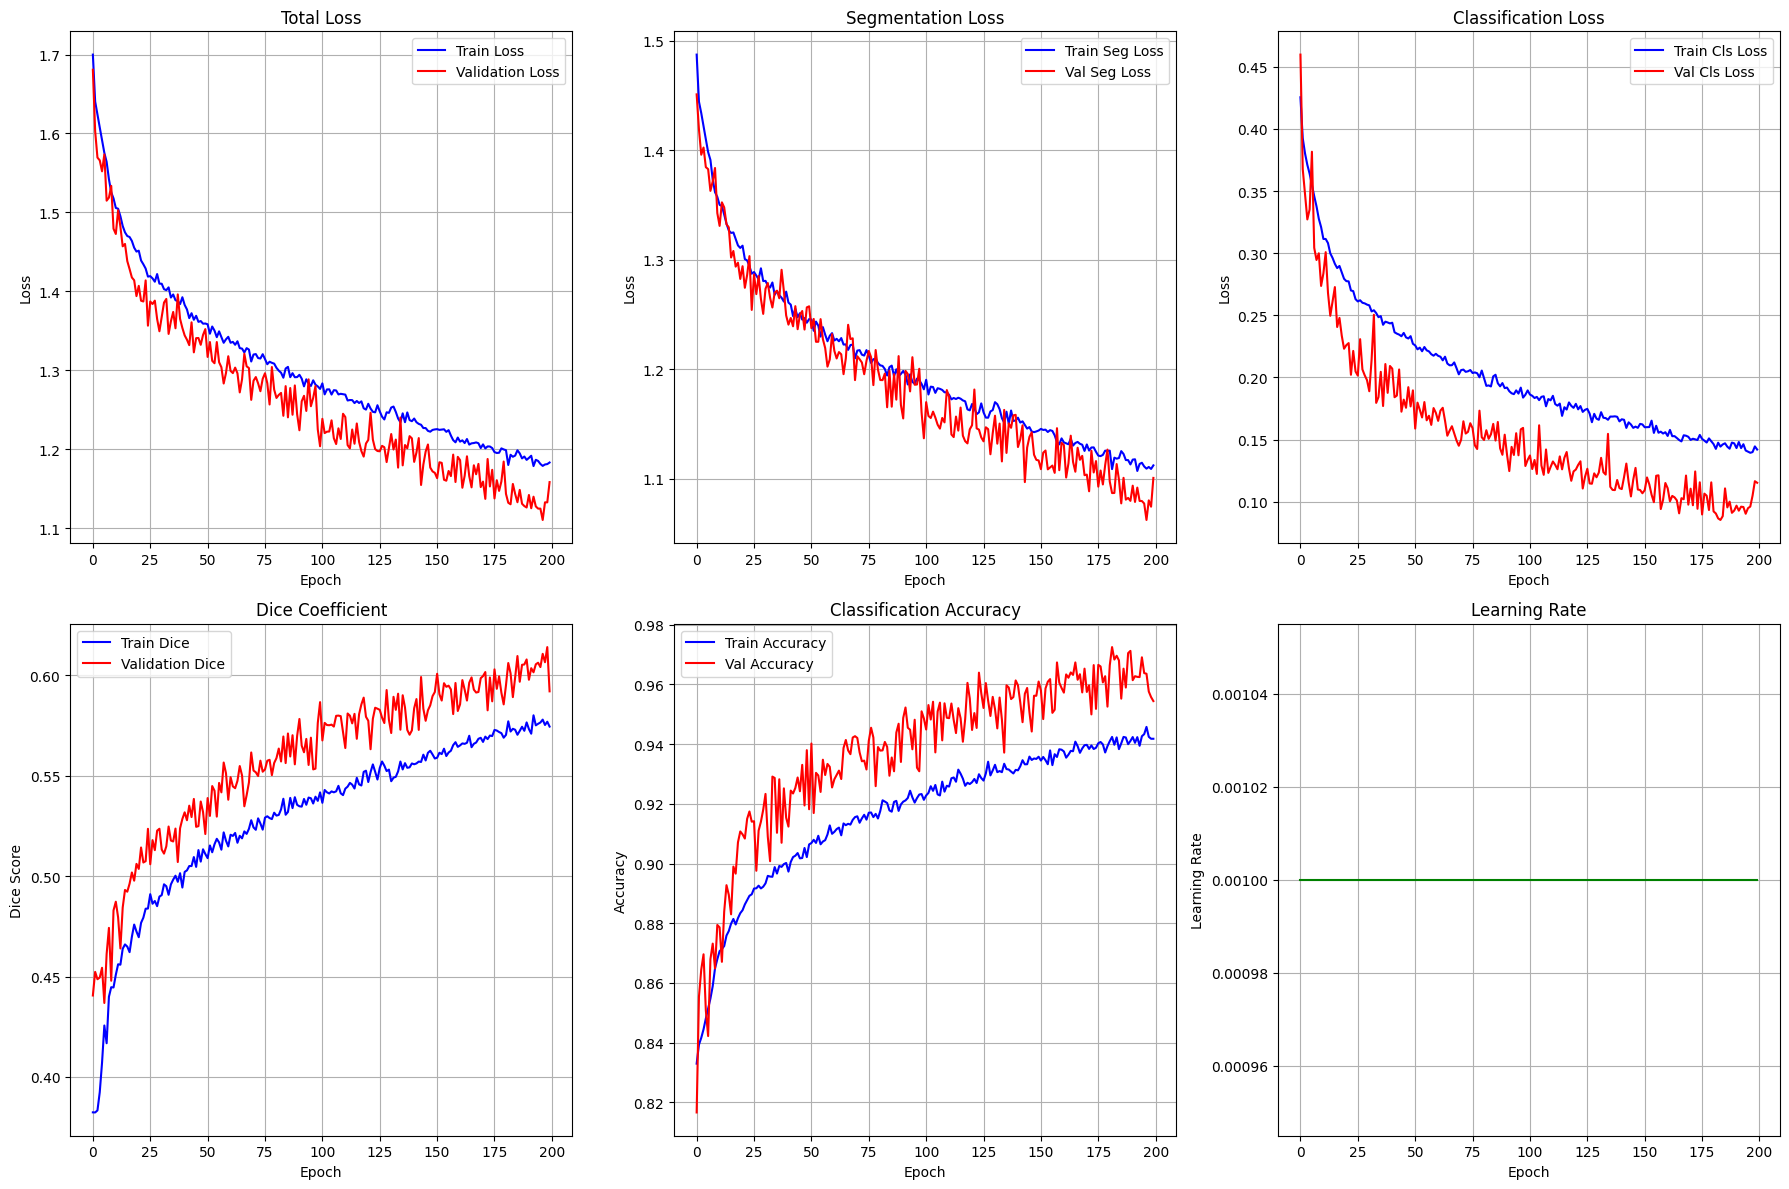


Training completed!
Best validation loss: 1.110321


Validation: 100%|██████████| 15/15 [00:01<00:00,  8.10it/s, Loss=1.0928, Dice=0.5923, Acc=0.9529]

loss: 1.1281282901763916, seg_loss: 1.077023454507192, cls_loss: 0.10220965395371119, dice: 0.5910603066285451, cls_acc: 0.9632488369941712


In [14]:
history = trainer_ndvi_256.train(CONFIG['num_epochs'])
trainer_ndvi_256.val_dataloader = test_dataloader
test_loss, test_seg_loss, test_cls_loss, test_dice, test_cls_acc = trainer_ndvi_256.validate_epoch()
print(f'loss: {test_loss}, seg_loss: {test_seg_loss}, cls_loss: {test_cls_loss}, dice: {test_dice}, cls_acc: {test_cls_acc}')

Using device: cuda
GPU: NVIDIA RTX A5000
GPU Memory: 23.5 GB
Creating datasets...
Split 'train': 4373 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Split 'val': 291 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Split 'test': 1166 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Training samples: 4373
Validation samples: 291
Training batches: 54
Validation batches: 4
Creating model...
Starting training for 200 epochs...
Device: cuda
Model parameters: 2,464,615

Epoch 1/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=1.6638, Dice=0.4229, Acc=0.8595]


New best model! Validation loss: 1.700001
Train Loss: 1.699881 | Val Loss: 1.700001
Train Dice: 0.3623 | Val Dice: 0.3643
Train Acc: 0.8347 | Val Acc: 0.8414
Learning Rate: 0.00100000

Epoch 2/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, Loss=1.5661, Dice=0.5348, Acc=0.8824]


New best model! Validation loss: 1.694745
Train Loss: 1.625126 | Val Loss: 1.694745
Train Dice: 0.3843 | Val Dice: 0.3967
Train Acc: 0.8465 | Val Acc: 0.8492
Learning Rate: 0.00100000

Epoch 3/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, Loss=1.4669, Dice=0.5680, Acc=0.9314]


New best model! Validation loss: 1.558469
Train Loss: 1.601195 | Val Loss: 1.558469
Train Dice: 0.3881 | Val Dice: 0.4658
Train Acc: 0.8513 | Val Acc: 0.8776
Learning Rate: 0.00100000

Epoch 4/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=1.4358, Dice=0.5799, Acc=0.9183]


Train Loss: 1.572268 | Val Loss: 1.623644
Train Dice: 0.4081 | Val Dice: 0.3907
Train Acc: 0.8583 | Val Acc: 0.8343
Learning Rate: 0.00100000

Epoch 5/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, Loss=1.4405, Dice=0.5962, Acc=0.9281]


New best model! Validation loss: 1.546976
Train Loss: 1.560100 | Val Loss: 1.546976
Train Dice: 0.4042 | Val Dice: 0.4732
Train Acc: 0.8636 | Val Acc: 0.8841
Learning Rate: 0.00100000

Epoch 6/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=1.3741, Dice=0.6119, Acc=0.9412]


New best model! Validation loss: 1.483466
Train Loss: 1.543951 | Val Loss: 1.483466
Train Dice: 0.4116 | Val Dice: 0.5062
Train Acc: 0.8696 | Val Acc: 0.8910
Learning Rate: 0.00100000

Epoch 7/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=1.4644, Dice=0.5605, Acc=0.9510]


Train Loss: 1.533106 | Val Loss: 1.523002
Train Dice: 0.4236 | Val Dice: 0.4713
Train Acc: 0.8697 | Val Acc: 0.8945
Learning Rate: 0.00100000

Epoch 8/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, Loss=1.3579, Dice=0.5906, Acc=0.9248]


Train Loss: 1.520936 | Val Loss: 1.514183
Train Dice: 0.4347 | Val Dice: 0.4677
Train Acc: 0.8719 | Val Acc: 0.8713
Learning Rate: 0.00100000

Epoch 9/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=1.3164, Dice=0.6135, Acc=0.9314]


Train Loss: 1.515838 | Val Loss: 1.512633
Train Dice: 0.4304 | Val Dice: 0.4593
Train Acc: 0.8785 | Val Acc: 0.8776
Learning Rate: 0.00100000

Epoch 10/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, Loss=1.2876, Dice=0.6415, Acc=0.9412]


New best model! Validation loss: 1.461902
Train Loss: 1.508349 | Val Loss: 1.461902
Train Dice: 0.4359 | Val Dice: 0.4901
Train Acc: 0.8803 | Val Acc: 0.8952
Learning Rate: 0.00100000
Checkpoint saved at epoch 10

Epoch 11/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, Loss=1.2020, Dice=0.6688, Acc=0.9510]


New best model! Validation loss: 1.397143
Train Loss: 1.502403 | Val Loss: 1.397143
Train Dice: 0.4423 | Val Dice: 0.5293
Train Acc: 0.8816 | Val Acc: 0.8987
Learning Rate: 0.00100000

Epoch 12/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=1.3396, Dice=0.6156, Acc=0.9281]


Train Loss: 1.487742 | Val Loss: 1.503945
Train Dice: 0.4463 | Val Dice: 0.4552
Train Acc: 0.8841 | Val Acc: 0.8971
Learning Rate: 0.00100000

Epoch 13/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=1.2263, Dice=0.6608, Acc=0.9510]


Train Loss: 1.477849 | Val Loss: 1.410684
Train Dice: 0.4555 | Val Dice: 0.5296
Train Acc: 0.8861 | Val Acc: 0.9028
Learning Rate: 0.00100000

Epoch 14/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, Loss=1.3062, Dice=0.6085, Acc=0.9281]


Train Loss: 1.462256 | Val Loss: 1.523512
Train Dice: 0.4639 | Val Dice: 0.4493
Train Acc: 0.8873 | Val Acc: 0.8836
Learning Rate: 0.00100000

Epoch 15/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=1.2223, Dice=0.6580, Acc=0.9542]


Train Loss: 1.459885 | Val Loss: 1.407617
Train Dice: 0.4603 | Val Dice: 0.5215
Train Acc: 0.8903 | Val Acc: 0.9021
Learning Rate: 0.00100000

Epoch 16/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=1.2046, Dice=0.6391, Acc=0.9706]


New best model! Validation loss: 1.384312
Train Loss: 1.447449 | Val Loss: 1.384312
Train Dice: 0.4674 | Val Dice: 0.5154
Train Acc: 0.8919 | Val Acc: 0.9260
Learning Rate: 0.00100000

Epoch 17/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=1.1602, Dice=0.6763, Acc=0.9510]


New best model! Validation loss: 1.356962
Train Loss: 1.442690 | Val Loss: 1.356962
Train Dice: 0.4746 | Val Dice: 0.5397
Train Acc: 0.8941 | Val Acc: 0.9086
Learning Rate: 0.00100000

Epoch 18/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s, Loss=1.1999, Dice=0.6537, Acc=0.9575]


Train Loss: 1.433506 | Val Loss: 1.380774
Train Dice: 0.4786 | Val Dice: 0.5276
Train Acc: 0.8943 | Val Acc: 0.9086
Learning Rate: 0.00100000

Epoch 19/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, Loss=1.1364, Dice=0.6737, Acc=0.9641]


Train Loss: 1.415624 | Val Loss: 1.371702
Train Dice: 0.4896 | Val Dice: 0.5320
Train Acc: 0.8957 | Val Acc: 0.9165
Learning Rate: 0.00100000

Epoch 20/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=1.1510, Dice=0.6569, Acc=0.9673]


New best model! Validation loss: 1.343604
Train Loss: 1.421603 | Val Loss: 1.343604
Train Dice: 0.4822 | Val Dice: 0.5398
Train Acc: 0.8966 | Val Acc: 0.9205
Learning Rate: 0.00100000
Checkpoint saved at epoch 20

Epoch 21/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s, Loss=1.1047, Dice=0.6767, Acc=0.9706]


New best model! Validation loss: 1.323048
Train Loss: 1.417351 | Val Loss: 1.323048
Train Dice: 0.4818 | Val Dice: 0.5537
Train Acc: 0.8978 | Val Acc: 0.9244
Learning Rate: 0.00100000

Epoch 22/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, Loss=1.1002, Dice=0.6738, Acc=0.9641]


Train Loss: 1.410907 | Val Loss: 1.340929
Train Dice: 0.4823 | Val Dice: 0.5416
Train Acc: 0.8992 | Val Acc: 0.9238
Learning Rate: 0.00100000

Epoch 23/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, Loss=1.1832, Dice=0.6703, Acc=0.9608]


Train Loss: 1.397411 | Val Loss: 1.357057
Train Dice: 0.4938 | Val Dice: 0.5453
Train Acc: 0.9003 | Val Acc: 0.9199
Learning Rate: 0.00100000

Epoch 24/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=1.0955, Dice=0.6729, Acc=0.9641]


New best model! Validation loss: 1.305653
Train Loss: 1.390758 | Val Loss: 1.305653
Train Dice: 0.4968 | Val Dice: 0.5518
Train Acc: 0.9016 | Val Acc: 0.9275
Learning Rate: 0.00100000

Epoch 25/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, Loss=1.0916, Dice=0.6815, Acc=0.9641]


Train Loss: 1.387449 | Val Loss: 1.306672
Train Dice: 0.4953 | Val Dice: 0.5572
Train Acc: 0.9036 | Val Acc: 0.9186
Learning Rate: 0.00100000

Epoch 26/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, Loss=1.1589, Dice=0.6482, Acc=0.9641]


Train Loss: 1.378801 | Val Loss: 1.355251
Train Dice: 0.4973 | Val Dice: 0.5314
Train Acc: 0.9064 | Val Acc: 0.9275
Learning Rate: 0.00100000

Epoch 27/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, Loss=1.1300, Dice=0.6707, Acc=0.9673]


New best model! Validation loss: 1.305375
Train Loss: 1.384045 | Val Loss: 1.305375
Train Dice: 0.5014 | Val Dice: 0.5612
Train Acc: 0.9032 | Val Acc: 0.9241
Learning Rate: 0.00100000

Epoch 28/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, Loss=1.0039, Dice=0.6991, Acc=0.9739]


New best model! Validation loss: 1.292260
Train Loss: 1.372005 | Val Loss: 1.292260
Train Dice: 0.5077 | Val Dice: 0.5583
Train Acc: 0.9049 | Val Acc: 0.9278
Learning Rate: 0.00100000

Epoch 29/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s, Loss=1.1901, Dice=0.6558, Acc=0.9542]


Train Loss: 1.364061 | Val Loss: 1.372048
Train Dice: 0.5083 | Val Dice: 0.5225
Train Acc: 0.9074 | Val Acc: 0.9136
Learning Rate: 0.00100000

Epoch 30/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=1.1304, Dice=0.6568, Acc=0.9575]


Train Loss: 1.358267 | Val Loss: 1.345919
Train Dice: 0.5101 | Val Dice: 0.5308
Train Acc: 0.9076 | Val Acc: 0.9196
Learning Rate: 0.00100000
Checkpoint saved at epoch 30

Epoch 31/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=1.0438, Dice=0.7047, Acc=0.9706]


New best model! Validation loss: 1.281568
Train Loss: 1.359337 | Val Loss: 1.281568
Train Dice: 0.5072 | Val Dice: 0.5693
Train Acc: 0.9093 | Val Acc: 0.9328
Learning Rate: 0.00100000

Epoch 32/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, Loss=1.1100, Dice=0.6787, Acc=0.9706]


Train Loss: 1.358442 | Val Loss: 1.323113
Train Dice: 0.5085 | Val Dice: 0.5404
Train Acc: 0.9080 | Val Acc: 0.9296
Learning Rate: 0.00100000

Epoch 33/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=1.0759, Dice=0.6784, Acc=0.9706]


Train Loss: 1.357389 | Val Loss: 1.284349
Train Dice: 0.5092 | Val Dice: 0.5672
Train Acc: 0.9098 | Val Acc: 0.9286
Learning Rate: 0.00100000

Epoch 34/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, Loss=1.0368, Dice=0.6929, Acc=0.9771]


New best model! Validation loss: 1.269843
Train Loss: 1.349780 | Val Loss: 1.269843
Train Dice: 0.5130 | Val Dice: 0.5607
Train Acc: 0.9135 | Val Acc: 0.9344
Learning Rate: 0.00100000

Epoch 35/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, Loss=1.0959, Dice=0.6903, Acc=0.9739]


Train Loss: 1.344747 | Val Loss: 1.289243
Train Dice: 0.5217 | Val Dice: 0.5627
Train Acc: 0.9094 | Val Acc: 0.9294
Learning Rate: 0.00100000

Epoch 36/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=1.0213, Dice=0.7104, Acc=0.9804]


New best model! Validation loss: 1.252730
Train Loss: 1.330924 | Val Loss: 1.252730
Train Dice: 0.5236 | Val Dice: 0.5731
Train Acc: 0.9120 | Val Acc: 0.9394
Learning Rate: 0.00100000

Epoch 37/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, Loss=1.0336, Dice=0.7012, Acc=0.9771]


New best model! Validation loss: 1.250717
Train Loss: 1.329743 | Val Loss: 1.250717
Train Dice: 0.5196 | Val Dice: 0.5797
Train Acc: 0.9135 | Val Acc: 0.9401
Learning Rate: 0.00100000

Epoch 38/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, Loss=1.0418, Dice=0.6970, Acc=0.9706]


New best model! Validation loss: 1.249855
Train Loss: 1.330524 | Val Loss: 1.249855
Train Dice: 0.5242 | Val Dice: 0.5740
Train Acc: 0.9115 | Val Acc: 0.9385
Learning Rate: 0.00100000

Epoch 39/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, Loss=1.0719, Dice=0.6946, Acc=0.9673]


Train Loss: 1.320930 | Val Loss: 1.265543
Train Dice: 0.5246 | Val Dice: 0.5702
Train Acc: 0.9157 | Val Acc: 0.9403
Learning Rate: 0.00100000

Epoch 40/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, Loss=1.0348, Dice=0.6932, Acc=0.9608]


Train Loss: 1.317184 | Val Loss: 1.298790
Train Dice: 0.5306 | Val Dice: 0.5500
Train Acc: 0.9141 | Val Acc: 0.9308
Learning Rate: 0.00100000
Checkpoint saved at epoch 40

Epoch 41/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, Loss=1.0084, Dice=0.6978, Acc=0.9608]


New best model! Validation loss: 1.248374
Train Loss: 1.321891 | Val Loss: 1.248374
Train Dice: 0.5276 | Val Dice: 0.5749
Train Acc: 0.9133 | Val Acc: 0.9303
Learning Rate: 0.00100000

Epoch 42/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, Loss=1.0731, Dice=0.6894, Acc=0.9608]


Train Loss: 1.323390 | Val Loss: 1.297433
Train Dice: 0.5263 | Val Dice: 0.5492
Train Acc: 0.9134 | Val Acc: 0.9319
Learning Rate: 0.00100000

Epoch 43/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, Loss=0.9962, Dice=0.7143, Acc=0.9771]


Train Loss: 1.303813 | Val Loss: 1.249981
Train Dice: 0.5325 | Val Dice: 0.5724
Train Acc: 0.9187 | Val Acc: 0.9328
Learning Rate: 0.00100000

Epoch 44/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=1.0031, Dice=0.7286, Acc=0.9673]


New best model! Validation loss: 1.242516
Train Loss: 1.300870 | Val Loss: 1.242516
Train Dice: 0.5364 | Val Dice: 0.5838
Train Acc: 0.9150 | Val Acc: 0.9377
Learning Rate: 0.00100000

Epoch 45/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, Loss=1.1043, Dice=0.6982, Acc=0.9739]


Train Loss: 1.308276 | Val Loss: 1.268034
Train Dice: 0.5324 | Val Dice: 0.5684
Train Acc: 0.9171 | Val Acc: 0.9409
Learning Rate: 0.00100000

Epoch 46/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, Loss=0.9370, Dice=0.7210, Acc=0.9771]


New best model! Validation loss: 1.214589
Train Loss: 1.300449 | Val Loss: 1.214589
Train Dice: 0.5345 | Val Dice: 0.5882
Train Acc: 0.9166 | Val Acc: 0.9396
Learning Rate: 0.00100000

Epoch 47/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=1.0446, Dice=0.7082, Acc=0.9739]


Train Loss: 1.299391 | Val Loss: 1.245923
Train Dice: 0.5327 | Val Dice: 0.5778
Train Acc: 0.9180 | Val Acc: 0.9445
Learning Rate: 0.00100000

Epoch 48/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, Loss=1.1193, Dice=0.6975, Acc=0.9673]


Train Loss: 1.292025 | Val Loss: 1.264064
Train Dice: 0.5395 | Val Dice: 0.5819
Train Acc: 0.9179 | Val Acc: 0.9382
Learning Rate: 0.00100000

Epoch 49/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=1.0325, Dice=0.7056, Acc=0.9739]


Train Loss: 1.296496 | Val Loss: 1.229677
Train Dice: 0.5366 | Val Dice: 0.5817
Train Acc: 0.9211 | Val Acc: 0.9424
Learning Rate: 0.00100000

Epoch 50/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=1.0143, Dice=0.6991, Acc=0.9641]


Train Loss: 1.291616 | Val Loss: 1.265513
Train Dice: 0.5365 | Val Dice: 0.5595
Train Acc: 0.9201 | Val Acc: 0.9311
Learning Rate: 0.00100000
Checkpoint saved at epoch 50

Epoch 51/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, Loss=1.0231, Dice=0.6718, Acc=0.9804]


Train Loss: 1.285710 | Val Loss: 1.324390
Train Dice: 0.5422 | Val Dice: 0.5358
Train Acc: 0.9209 | Val Acc: 0.9430
Learning Rate: 0.00100000

Epoch 52/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, Loss=1.0339, Dice=0.7078, Acc=0.9804]


Train Loss: 1.292244 | Val Loss: 1.228719
Train Dice: 0.5408 | Val Dice: 0.5806
Train Acc: 0.9188 | Val Acc: 0.9472
Learning Rate: 0.00100000

Epoch 53/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s, Loss=0.9831, Dice=0.7281, Acc=0.9771]


New best model! Validation loss: 1.211582
Train Loss: 1.284465 | Val Loss: 1.211582
Train Dice: 0.5415 | Val Dice: 0.5912
Train Acc: 0.9213 | Val Acc: 0.9453
Learning Rate: 0.00100000

Epoch 54/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, Loss=1.0103, Dice=0.7044, Acc=0.9706]


Train Loss: 1.287771 | Val Loss: 1.220925
Train Dice: 0.5422 | Val Dice: 0.5847
Train Acc: 0.9206 | Val Acc: 0.9432
Learning Rate: 0.00100000

Epoch 55/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, Loss=1.0311, Dice=0.7106, Acc=0.9706]


Train Loss: 1.282569 | Val Loss: 1.214682
Train Dice: 0.5394 | Val Dice: 0.5895
Train Acc: 0.9245 | Val Acc: 0.9489
Learning Rate: 0.00100000

Epoch 56/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, Loss=1.0227, Dice=0.7076, Acc=0.9641]


Train Loss: 1.268568 | Val Loss: 1.243870
Train Dice: 0.5487 | Val Dice: 0.5753
Train Acc: 0.9238 | Val Acc: 0.9421
Learning Rate: 0.00100000

Epoch 57/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=1.0402, Dice=0.6948, Acc=0.9804]


Train Loss: 1.276327 | Val Loss: 1.228524
Train Dice: 0.5443 | Val Dice: 0.5772
Train Acc: 0.9208 | Val Acc: 0.9482
Learning Rate: 0.00100000

Epoch 58/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, Loss=1.0288, Dice=0.7051, Acc=0.9739]


Train Loss: 1.269333 | Val Loss: 1.255554
Train Dice: 0.5469 | Val Dice: 0.5727
Train Acc: 0.9232 | Val Acc: 0.9377
Learning Rate: 0.00100000

Epoch 59/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, Loss=1.0607, Dice=0.6942, Acc=0.9673]


Train Loss: 1.269474 | Val Loss: 1.236565
Train Dice: 0.5477 | Val Dice: 0.5834
Train Acc: 0.9225 | Val Acc: 0.9408
Learning Rate: 0.00100000

Epoch 60/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.9497, Dice=0.7181, Acc=0.9739]


New best model! Validation loss: 1.190208
Train Loss: 1.262380 | Val Loss: 1.190208
Train Dice: 0.5497 | Val Dice: 0.5895
Train Acc: 0.9236 | Val Acc: 0.9445
Learning Rate: 0.00100000
Checkpoint saved at epoch 60

Epoch 61/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, Loss=0.9846, Dice=0.7271, Acc=0.9706]


Train Loss: 1.266584 | Val Loss: 1.216330
Train Dice: 0.5487 | Val Dice: 0.5848
Train Acc: 0.9223 | Val Acc: 0.9463
Learning Rate: 0.00100000

Epoch 62/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=1.0454, Dice=0.7099, Acc=0.9837]


Train Loss: 1.260971 | Val Loss: 1.219157
Train Dice: 0.5525 | Val Dice: 0.5898
Train Acc: 0.9244 | Val Acc: 0.9470
Learning Rate: 0.00100000

Epoch 63/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=1.0037, Dice=0.7129, Acc=0.9804]


Train Loss: 1.263989 | Val Loss: 1.223746
Train Dice: 0.5483 | Val Dice: 0.5774
Train Acc: 0.9255 | Val Acc: 0.9477
Learning Rate: 0.00100000

Epoch 64/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, Loss=1.0199, Dice=0.7134, Acc=0.9739]


Train Loss: 1.247940 | Val Loss: 1.203989
Train Dice: 0.5568 | Val Dice: 0.5943
Train Acc: 0.9264 | Val Acc: 0.9471
Learning Rate: 0.00100000

Epoch 65/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, Loss=1.0263, Dice=0.7164, Acc=0.9771]


Train Loss: 1.246622 | Val Loss: 1.202322
Train Dice: 0.5566 | Val Dice: 0.5952
Train Acc: 0.9268 | Val Acc: 0.9495
Learning Rate: 0.00100000

Epoch 66/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.9861, Dice=0.7274, Acc=0.9837]


Train Loss: 1.248366 | Val Loss: 1.195336
Train Dice: 0.5553 | Val Dice: 0.5981
Train Acc: 0.9282 | Val Acc: 0.9475
Learning Rate: 0.00100000

Epoch 67/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, Loss=1.0675, Dice=0.6924, Acc=0.9804]


Train Loss: 1.251940 | Val Loss: 1.242808
Train Dice: 0.5529 | Val Dice: 0.5708
Train Acc: 0.9248 | Val Acc: 0.9508
Learning Rate: 0.00100000

Epoch 68/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, Loss=0.9017, Dice=0.7382, Acc=0.9837]


New best model! Validation loss: 1.168359
Train Loss: 1.245478 | Val Loss: 1.168359
Train Dice: 0.5557 | Val Dice: 0.6030
Train Acc: 0.9270 | Val Acc: 0.9501
Learning Rate: 0.00100000

Epoch 69/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.9737, Dice=0.7172, Acc=0.9869]


Train Loss: 1.234146 | Val Loss: 1.177810
Train Dice: 0.5606 | Val Dice: 0.5979
Train Acc: 0.9279 | Val Acc: 0.9519
Learning Rate: 0.00100000

Epoch 70/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, Loss=1.0336, Dice=0.7129, Acc=0.9641]


Train Loss: 1.240785 | Val Loss: 1.199841
Train Dice: 0.5561 | Val Dice: 0.5967
Train Acc: 0.9308 | Val Acc: 0.9509
Learning Rate: 0.00100000
Checkpoint saved at epoch 70

Epoch 71/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, Loss=0.9852, Dice=0.7216, Acc=0.9771]


Train Loss: 1.237236 | Val Loss: 1.189018
Train Dice: 0.5563 | Val Dice: 0.5975
Train Acc: 0.9289 | Val Acc: 0.9511
Learning Rate: 0.00100000

Epoch 72/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.9202, Dice=0.7324, Acc=0.9739]


Train Loss: 1.234986 | Val Loss: 1.203051
Train Dice: 0.5607 | Val Dice: 0.5901
Train Acc: 0.9298 | Val Acc: 0.9450
Learning Rate: 0.00100000

Epoch 73/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.9596, Dice=0.7277, Acc=0.9771]


Train Loss: 1.227259 | Val Loss: 1.174041
Train Dice: 0.5675 | Val Dice: 0.6039
Train Acc: 0.9271 | Val Acc: 0.9500
Learning Rate: 0.00100000

Epoch 74/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, Loss=0.9596, Dice=0.7216, Acc=0.9706]


Train Loss: 1.221733 | Val Loss: 1.181946
Train Dice: 0.5648 | Val Dice: 0.6003
Train Acc: 0.9306 | Val Acc: 0.9510
Learning Rate: 0.00100000

Epoch 75/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, Loss=0.8790, Dice=0.7467, Acc=0.9837]


New best model! Validation loss: 1.143774
Train Loss: 1.217339 | Val Loss: 1.143774
Train Dice: 0.5659 | Val Dice: 0.6057
Train Acc: 0.9350 | Val Acc: 0.9480
Learning Rate: 0.00100000

Epoch 76/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.9606, Dice=0.7237, Acc=0.9804]


Train Loss: 1.229492 | Val Loss: 1.155657
Train Dice: 0.5601 | Val Dice: 0.6121
Train Acc: 0.9320 | Val Acc: 0.9581
Learning Rate: 0.00100000

Epoch 77/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.9852, Dice=0.7246, Acc=0.9771]


Train Loss: 1.208218 | Val Loss: 1.175327
Train Dice: 0.5678 | Val Dice: 0.6039
Train Acc: 0.9304 | Val Acc: 0.9526
Learning Rate: 0.00100000

Epoch 78/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, Loss=0.9566, Dice=0.7322, Acc=0.9673]


Train Loss: 1.217711 | Val Loss: 1.177651
Train Dice: 0.5683 | Val Dice: 0.5989
Train Acc: 0.9324 | Val Acc: 0.9450
Learning Rate: 0.00100000

Epoch 79/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.9476, Dice=0.7461, Acc=0.9771]


Train Loss: 1.214587 | Val Loss: 1.182452
Train Dice: 0.5684 | Val Dice: 0.5996
Train Acc: 0.9319 | Val Acc: 0.9500
Learning Rate: 0.00100000

Epoch 80/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=1.0581, Dice=0.7205, Acc=0.9771]


Train Loss: 1.205533 | Val Loss: 1.198689
Train Dice: 0.5721 | Val Dice: 0.6021
Train Acc: 0.9326 | Val Acc: 0.9511
Learning Rate: 0.00100000
Checkpoint saved at epoch 80

Epoch 81/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=0.9472, Dice=0.7448, Acc=0.9673]


Train Loss: 1.221911 | Val Loss: 1.158103
Train Dice: 0.5656 | Val Dice: 0.6101
Train Acc: 0.9348 | Val Acc: 0.9481
Learning Rate: 0.00100000

Epoch 82/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, Loss=0.9401, Dice=0.7282, Acc=0.9641]


New best model! Validation loss: 1.141646
Train Loss: 1.205582 | Val Loss: 1.141646
Train Dice: 0.5750 | Val Dice: 0.6140
Train Acc: 0.9316 | Val Acc: 0.9520
Learning Rate: 0.00100000

Epoch 83/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, Loss=0.9824, Dice=0.7260, Acc=0.9641]


Train Loss: 1.207165 | Val Loss: 1.156291
Train Dice: 0.5754 | Val Dice: 0.6087
Train Acc: 0.9333 | Val Acc: 0.9525
Learning Rate: 0.00100000

Epoch 84/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, Loss=1.0200, Dice=0.7113, Acc=0.9641]


Train Loss: 1.207773 | Val Loss: 1.184860
Train Dice: 0.5704 | Val Dice: 0.6020
Train Acc: 0.9336 | Val Acc: 0.9499
Learning Rate: 0.00100000

Epoch 85/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, Loss=0.9187, Dice=0.7326, Acc=0.9673]


Train Loss: 1.205339 | Val Loss: 1.162163
Train Dice: 0.5719 | Val Dice: 0.6055
Train Acc: 0.9348 | Val Acc: 0.9491
Learning Rate: 0.00100000

Epoch 86/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=0.9256, Dice=0.7425, Acc=0.9739]


Train Loss: 1.210170 | Val Loss: 1.143401
Train Dice: 0.5708 | Val Dice: 0.6132
Train Acc: 0.9316 | Val Acc: 0.9591
Learning Rate: 0.00100000

Epoch 87/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, Loss=0.9187, Dice=0.7330, Acc=0.9837]


New best model! Validation loss: 1.138175
Train Loss: 1.191532 | Val Loss: 1.138175
Train Dice: 0.5802 | Val Dice: 0.6106
Train Acc: 0.9346 | Val Acc: 0.9605
Learning Rate: 0.00100000

Epoch 88/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, Loss=0.9884, Dice=0.7205, Acc=0.9706]


Train Loss: 1.206001 | Val Loss: 1.180940
Train Dice: 0.5703 | Val Dice: 0.6043
Train Acc: 0.9344 | Val Acc: 0.9562
Learning Rate: 0.00100000

Epoch 89/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.8860, Dice=0.7483, Acc=0.9804]


New best model! Validation loss: 1.118096
Train Loss: 1.201371 | Val Loss: 1.118096
Train Dice: 0.5716 | Val Dice: 0.6218
Train Acc: 0.9333 | Val Acc: 0.9571
Learning Rate: 0.00100000

Epoch 90/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, Loss=0.9207, Dice=0.7441, Acc=0.9804]


Train Loss: 1.194255 | Val Loss: 1.143560
Train Dice: 0.5778 | Val Dice: 0.6200
Train Acc: 0.9366 | Val Acc: 0.9519
Learning Rate: 0.00100000
Checkpoint saved at epoch 90

Epoch 91/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, Loss=0.8983, Dice=0.7449, Acc=0.9608]


Train Loss: 1.189632 | Val Loss: 1.142045
Train Dice: 0.5793 | Val Dice: 0.6186
Train Acc: 0.9361 | Val Acc: 0.9537
Learning Rate: 0.00100000

Epoch 92/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.9970, Dice=0.7225, Acc=0.9837]


Train Loss: 1.187112 | Val Loss: 1.202131
Train Dice: 0.5778 | Val Dice: 0.5983
Train Acc: 0.9366 | Val Acc: 0.9574
Learning Rate: 0.00100000

Epoch 93/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=0.8545, Dice=0.7476, Acc=0.9771]


New best model! Validation loss: 1.090536
Train Loss: 1.201340 | Val Loss: 1.090536
Train Dice: 0.5722 | Val Dice: 0.6293
Train Acc: 0.9349 | Val Acc: 0.9594
Learning Rate: 0.00100000

Epoch 94/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=0.9569, Dice=0.7188, Acc=0.9804]


Train Loss: 1.193097 | Val Loss: 1.136718
Train Dice: 0.5748 | Val Dice: 0.6186
Train Acc: 0.9367 | Val Acc: 0.9534
Learning Rate: 0.00100000

Epoch 95/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s, Loss=0.8611, Dice=0.7504, Acc=0.9804]


Train Loss: 1.188649 | Val Loss: 1.117636
Train Dice: 0.5792 | Val Dice: 0.6258
Train Acc: 0.9340 | Val Acc: 0.9618
Learning Rate: 0.00100000

Epoch 96/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, Loss=0.9838, Dice=0.7180, Acc=0.9771]


Train Loss: 1.187703 | Val Loss: 1.157347
Train Dice: 0.5784 | Val Dice: 0.6108
Train Acc: 0.9368 | Val Acc: 0.9552
Learning Rate: 0.00100000

Epoch 97/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=1.0046, Dice=0.7231, Acc=0.9673]


Train Loss: 1.181085 | Val Loss: 1.194877
Train Dice: 0.5809 | Val Dice: 0.5972
Train Acc: 0.9399 | Val Acc: 0.9486
Learning Rate: 0.00100000

Epoch 98/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.9187, Dice=0.7297, Acc=0.9706]


Train Loss: 1.187193 | Val Loss: 1.144468
Train Dice: 0.5775 | Val Dice: 0.6155
Train Acc: 0.9375 | Val Acc: 0.9541
Learning Rate: 0.00100000

Epoch 99/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.9549, Dice=0.7430, Acc=0.9804]


Train Loss: 1.181349 | Val Loss: 1.135835
Train Dice: 0.5820 | Val Dice: 0.6212
Train Acc: 0.9414 | Val Acc: 0.9607
Learning Rate: 0.00100000

Epoch 100/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=0.9123, Dice=0.7428, Acc=0.9771]


Train Loss: 1.175774 | Val Loss: 1.120366
Train Dice: 0.5822 | Val Dice: 0.6273
Train Acc: 0.9370 | Val Acc: 0.9583
Learning Rate: 0.00100000
Checkpoint saved at epoch 100

Epoch 101/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, Loss=0.8938, Dice=0.7404, Acc=0.9641]


Train Loss: 1.178898 | Val Loss: 1.134470
Train Dice: 0.5824 | Val Dice: 0.6189
Train Acc: 0.9360 | Val Acc: 0.9514
Learning Rate: 0.00100000

Epoch 102/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=0.9196, Dice=0.7273, Acc=0.9771]


Train Loss: 1.180825 | Val Loss: 1.122609
Train Dice: 0.5807 | Val Dice: 0.6119
Train Acc: 0.9385 | Val Acc: 0.9594
Learning Rate: 0.00100000

Epoch 103/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, Loss=0.8796, Dice=0.7428, Acc=0.9902]


Train Loss: 1.173698 | Val Loss: 1.100436
Train Dice: 0.5835 | Val Dice: 0.6259
Train Acc: 0.9399 | Val Acc: 0.9653
Learning Rate: 0.00100000

Epoch 104/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, Loss=0.8719, Dice=0.7471, Acc=0.9771]


Train Loss: 1.168142 | Val Loss: 1.135179
Train Dice: 0.5857 | Val Dice: 0.6120
Train Acc: 0.9387 | Val Acc: 0.9547
Learning Rate: 0.00100000

Epoch 105/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, Loss=0.8558, Dice=0.7614, Acc=0.9837]


Train Loss: 1.177226 | Val Loss: 1.092864
Train Dice: 0.5821 | Val Dice: 0.6312
Train Acc: 0.9385 | Val Acc: 0.9595
Learning Rate: 0.00100000

Epoch 106/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.9217, Dice=0.7302, Acc=0.9804]


Train Loss: 1.163594 | Val Loss: 1.121261
Train Dice: 0.5886 | Val Dice: 0.6165
Train Acc: 0.9380 | Val Acc: 0.9618
Learning Rate: 0.00100000

Epoch 107/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, Loss=0.8802, Dice=0.7535, Acc=0.9837]


Train Loss: 1.164857 | Val Loss: 1.095142
Train Dice: 0.5864 | Val Dice: 0.6351
Train Acc: 0.9400 | Val Acc: 0.9605
Learning Rate: 0.00100000

Epoch 108/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, Loss=0.9261, Dice=0.7438, Acc=0.9869]


Train Loss: 1.174687 | Val Loss: 1.127691
Train Dice: 0.5816 | Val Dice: 0.6203
Train Acc: 0.9385 | Val Acc: 0.9624
Learning Rate: 0.00100000

Epoch 109/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=0.8561, Dice=0.7513, Acc=0.9902]


Train Loss: 1.163405 | Val Loss: 1.103399
Train Dice: 0.5862 | Val Dice: 0.6249
Train Acc: 0.9393 | Val Acc: 0.9564
Learning Rate: 0.00100000

Epoch 110/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=0.9460, Dice=0.7361, Acc=0.9706]


Train Loss: 1.162994 | Val Loss: 1.144986
Train Dice: 0.5872 | Val Dice: 0.6108
Train Acc: 0.9415 | Val Acc: 0.9583
Learning Rate: 0.00100000
Checkpoint saved at epoch 110

Epoch 111/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s, Loss=0.8593, Dice=0.7442, Acc=0.9869]


New best model! Validation loss: 1.077449
Train Loss: 1.153936 | Val Loss: 1.077449
Train Dice: 0.5881 | Val Dice: 0.6337
Train Acc: 0.9430 | Val Acc: 0.9634
Learning Rate: 0.00100000

Epoch 112/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=0.9023, Dice=0.7428, Acc=0.9804]


Train Loss: 1.165089 | Val Loss: 1.121246
Train Dice: 0.5877 | Val Dice: 0.6180
Train Acc: 0.9388 | Val Acc: 0.9618
Learning Rate: 0.00100000

Epoch 113/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=0.8732, Dice=0.7376, Acc=0.9804]


Train Loss: 1.157451 | Val Loss: 1.087972
Train Dice: 0.5895 | Val Dice: 0.6275
Train Acc: 0.9451 | Val Acc: 0.9665
Learning Rate: 0.00100000

Epoch 114/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, Loss=0.9465, Dice=0.7352, Acc=0.9902]


Train Loss: 1.151721 | Val Loss: 1.119594
Train Dice: 0.5943 | Val Dice: 0.6176
Train Acc: 0.9403 | Val Acc: 0.9658
Learning Rate: 0.00100000

Epoch 115/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=0.9184, Dice=0.7368, Acc=0.9837]


Train Loss: 1.142455 | Val Loss: 1.127274
Train Dice: 0.5973 | Val Dice: 0.6174
Train Acc: 0.9426 | Val Acc: 0.9647
Learning Rate: 0.00100000

Epoch 116/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=0.9085, Dice=0.7463, Acc=0.9837]


Train Loss: 1.160573 | Val Loss: 1.115661
Train Dice: 0.5868 | Val Dice: 0.6250
Train Acc: 0.9410 | Val Acc: 0.9574
Learning Rate: 0.00100000

Epoch 117/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, Loss=0.9444, Dice=0.7315, Acc=0.9706]


Train Loss: 1.153106 | Val Loss: 1.106365
Train Dice: 0.5919 | Val Dice: 0.6273
Train Acc: 0.9452 | Val Acc: 0.9650
Learning Rate: 0.00100000

Epoch 118/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, Loss=0.9381, Dice=0.7396, Acc=0.9837]


Train Loss: 1.152574 | Val Loss: 1.122619
Train Dice: 0.5891 | Val Dice: 0.6265
Train Acc: 0.9424 | Val Acc: 0.9615
Learning Rate: 0.00100000

Epoch 119/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, Loss=0.8789, Dice=0.7473, Acc=0.9902]


Train Loss: 1.139252 | Val Loss: 1.096252
Train Dice: 0.5969 | Val Dice: 0.6283
Train Acc: 0.9438 | Val Acc: 0.9679
Learning Rate: 0.00100000

Epoch 120/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=0.8706, Dice=0.7563, Acc=0.9902]


Train Loss: 1.154914 | Val Loss: 1.089267
Train Dice: 0.5904 | Val Dice: 0.6317
Train Acc: 0.9422 | Val Acc: 0.9673
Learning Rate: 0.00100000
Checkpoint saved at epoch 120

Epoch 121/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, Loss=0.8624, Dice=0.7558, Acc=0.9837]


New best model! Validation loss: 1.068396
Train Loss: 1.140505 | Val Loss: 1.068396
Train Dice: 0.5990 | Val Dice: 0.6404
Train Acc: 0.9455 | Val Acc: 0.9657
Learning Rate: 0.00100000

Epoch 122/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=0.8743, Dice=0.7369, Acc=0.9869]


Train Loss: 1.140923 | Val Loss: 1.093665
Train Dice: 0.5942 | Val Dice: 0.6238
Train Acc: 0.9448 | Val Acc: 0.9655
Learning Rate: 0.00100000

Epoch 123/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.8607, Dice=0.7468, Acc=0.9739]


Train Loss: 1.141269 | Val Loss: 1.110148
Train Dice: 0.5964 | Val Dice: 0.6209
Train Acc: 0.9417 | Val Acc: 0.9586
Learning Rate: 0.00100000

Epoch 124/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, Loss=0.9036, Dice=0.7387, Acc=0.9902]


Train Loss: 1.144534 | Val Loss: 1.095215
Train Dice: 0.5961 | Val Dice: 0.6297
Train Acc: 0.9435 | Val Acc: 0.9679
Learning Rate: 0.00100000

Epoch 125/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8947, Dice=0.7515, Acc=0.9902]


Train Loss: 1.128732 | Val Loss: 1.078135
Train Dice: 0.6019 | Val Dice: 0.6407
Train Acc: 0.9421 | Val Acc: 0.9720
Learning Rate: 0.00100000

Epoch 126/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, Loss=0.9459, Dice=0.7273, Acc=0.9837]


Train Loss: 1.142418 | Val Loss: 1.113363
Train Dice: 0.5942 | Val Dice: 0.6245
Train Acc: 0.9457 | Val Acc: 0.9626
Learning Rate: 0.00100000

Epoch 127/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.8960, Dice=0.7412, Acc=0.9837]


Train Loss: 1.134131 | Val Loss: 1.115363
Train Dice: 0.6020 | Val Dice: 0.6186
Train Acc: 0.9431 | Val Acc: 0.9641
Learning Rate: 0.00100000

Epoch 128/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, Loss=0.9436, Dice=0.7240, Acc=0.9771]


Train Loss: 1.134087 | Val Loss: 1.112015
Train Dice: 0.5982 | Val Dice: 0.6218
Train Acc: 0.9437 | Val Acc: 0.9656
Learning Rate: 0.00100000

Epoch 129/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.9068, Dice=0.7512, Acc=0.9837]


Train Loss: 1.141280 | Val Loss: 1.075768
Train Dice: 0.5971 | Val Dice: 0.6409
Train Acc: 0.9448 | Val Acc: 0.9652
Learning Rate: 0.00100000

Epoch 130/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=0.8636, Dice=0.7653, Acc=0.9771]


New best model! Validation loss: 1.063702
Train Loss: 1.133024 | Val Loss: 1.063702
Train Dice: 0.5999 | Val Dice: 0.6449
Train Acc: 0.9441 | Val Acc: 0.9662
Learning Rate: 0.00100000
Checkpoint saved at epoch 130

Epoch 131/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, Loss=0.8901, Dice=0.7476, Acc=0.9804]


Train Loss: 1.122786 | Val Loss: 1.066317
Train Dice: 0.6024 | Val Dice: 0.6422
Train Acc: 0.9446 | Val Acc: 0.9618
Learning Rate: 0.00100000

Epoch 132/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.8717, Dice=0.7570, Acc=0.9706]


Train Loss: 1.124088 | Val Loss: 1.108579
Train Dice: 0.6020 | Val Dice: 0.6277
Train Acc: 0.9463 | Val Acc: 0.9619
Learning Rate: 0.00100000

Epoch 133/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, Loss=0.8476, Dice=0.7667, Acc=0.9739]


New best model! Validation loss: 1.063520
Train Loss: 1.138553 | Val Loss: 1.063520
Train Dice: 0.5975 | Val Dice: 0.6415
Train Acc: 0.9451 | Val Acc: 0.9622
Learning Rate: 0.00100000

Epoch 134/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, Loss=0.8261, Dice=0.7663, Acc=0.9902]


Train Loss: 1.125452 | Val Loss: 1.073415
Train Dice: 0.6053 | Val Dice: 0.6354
Train Acc: 0.9454 | Val Acc: 0.9653
Learning Rate: 0.00100000

Epoch 135/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, Loss=0.8874, Dice=0.7491, Acc=0.9837]


Train Loss: 1.132007 | Val Loss: 1.090518
Train Dice: 0.5995 | Val Dice: 0.6305
Train Acc: 0.9465 | Val Acc: 0.9673
Learning Rate: 0.00100000

Epoch 136/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, Loss=0.8251, Dice=0.7661, Acc=0.9869]


New best model! Validation loss: 1.049816
Train Loss: 1.130643 | Val Loss: 1.049816
Train Dice: 0.6014 | Val Dice: 0.6448
Train Acc: 0.9460 | Val Acc: 0.9696
Learning Rate: 0.00100000

Epoch 137/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, Loss=0.8809, Dice=0.7534, Acc=0.9902]


Train Loss: 1.110326 | Val Loss: 1.069706
Train Dice: 0.6078 | Val Dice: 0.6361
Train Acc: 0.9468 | Val Acc: 0.9694
Learning Rate: 0.00100000

Epoch 138/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=0.8497, Dice=0.7502, Acc=0.9902]


Train Loss: 1.114008 | Val Loss: 1.064784
Train Dice: 0.6074 | Val Dice: 0.6401
Train Acc: 0.9479 | Val Acc: 0.9663
Learning Rate: 0.00100000

Epoch 139/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, Loss=0.8922, Dice=0.7522, Acc=0.9771]


Train Loss: 1.129144 | Val Loss: 1.074983
Train Dice: 0.6008 | Val Dice: 0.6394
Train Acc: 0.9465 | Val Acc: 0.9667
Learning Rate: 0.00100000

Epoch 140/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=0.8442, Dice=0.7610, Acc=0.9739]


Train Loss: 1.131351 | Val Loss: 1.070356
Train Dice: 0.5984 | Val Dice: 0.6380
Train Acc: 0.9458 | Val Acc: 0.9695
Learning Rate: 0.00100000
Checkpoint saved at epoch 140

Epoch 141/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, Loss=0.8301, Dice=0.7581, Acc=0.9837]


Train Loss: 1.121605 | Val Loss: 1.054700
Train Dice: 0.6058 | Val Dice: 0.6390
Train Acc: 0.9458 | Val Acc: 0.9688
Learning Rate: 0.00100000

Epoch 142/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, Loss=0.8365, Dice=0.7641, Acc=0.9804]


New best model! Validation loss: 1.046325
Train Loss: 1.120528 | Val Loss: 1.046325
Train Dice: 0.6017 | Val Dice: 0.6464
Train Acc: 0.9494 | Val Acc: 0.9743
Learning Rate: 0.00100000

Epoch 143/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8391, Dice=0.7596, Acc=0.9673]


New best model! Validation loss: 1.039284
Train Loss: 1.112661 | Val Loss: 1.039284
Train Dice: 0.6074 | Val Dice: 0.6530
Train Acc: 0.9483 | Val Acc: 0.9684
Learning Rate: 0.00100000

Epoch 144/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, Loss=0.8176, Dice=0.7655, Acc=0.9804]


Train Loss: 1.118353 | Val Loss: 1.051454
Train Dice: 0.6057 | Val Dice: 0.6455
Train Acc: 0.9468 | Val Acc: 0.9675
Learning Rate: 0.00100000

Epoch 145/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, Loss=0.8348, Dice=0.7508, Acc=0.9706]


Train Loss: 1.114829 | Val Loss: 1.059452
Train Dice: 0.6066 | Val Dice: 0.6330
Train Acc: 0.9487 | Val Acc: 0.9656
Learning Rate: 0.00100000

Epoch 146/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, Loss=0.7998, Dice=0.7693, Acc=0.9739]


New best model! Validation loss: 1.022714
Train Loss: 1.111164 | Val Loss: 1.022714
Train Dice: 0.6071 | Val Dice: 0.6576
Train Acc: 0.9470 | Val Acc: 0.9716
Learning Rate: 0.00100000

Epoch 147/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=0.8112, Dice=0.7636, Acc=0.9706]


Train Loss: 1.115154 | Val Loss: 1.046229
Train Dice: 0.6079 | Val Dice: 0.6417
Train Acc: 0.9455 | Val Acc: 0.9640
Learning Rate: 0.00100000

Epoch 148/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, Loss=0.8310, Dice=0.7558, Acc=0.9641]


Train Loss: 1.100721 | Val Loss: 1.046176
Train Dice: 0.6130 | Val Dice: 0.6467
Train Acc: 0.9472 | Val Acc: 0.9624
Learning Rate: 0.00100000

Epoch 149/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=0.8897, Dice=0.7564, Acc=0.9771]


Train Loss: 1.110538 | Val Loss: 1.048258
Train Dice: 0.6066 | Val Dice: 0.6475
Train Acc: 0.9492 | Val Acc: 0.9708
Learning Rate: 0.00100000

Epoch 150/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, Loss=0.8406, Dice=0.7667, Acc=0.9804]


Train Loss: 1.104903 | Val Loss: 1.044861
Train Dice: 0.6080 | Val Dice: 0.6521
Train Acc: 0.9518 | Val Acc: 0.9706
Learning Rate: 0.00100000
Checkpoint saved at epoch 150

Epoch 151/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, Loss=0.8449, Dice=0.7634, Acc=0.9804]


Train Loss: 1.104878 | Val Loss: 1.081872
Train Dice: 0.6087 | Val Dice: 0.6364
Train Acc: 0.9497 | Val Acc: 0.9670
Learning Rate: 0.00100000

Epoch 152/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8490, Dice=0.7716, Acc=0.9869]


Train Loss: 1.110776 | Val Loss: 1.058575
Train Dice: 0.6064 | Val Dice: 0.6443
Train Acc: 0.9508 | Val Acc: 0.9743
Learning Rate: 0.00100000

Epoch 153/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, Loss=0.8375, Dice=0.7528, Acc=0.9804]


Train Loss: 1.110765 | Val Loss: 1.050691
Train Dice: 0.6079 | Val Dice: 0.6424
Train Acc: 0.9487 | Val Acc: 0.9701
Learning Rate: 0.00100000

Epoch 154/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.9252, Dice=0.7398, Acc=0.9837]


Train Loss: 1.107382 | Val Loss: 1.076320
Train Dice: 0.6064 | Val Dice: 0.6397
Train Acc: 0.9480 | Val Acc: 0.9688
Learning Rate: 0.00100000

Epoch 155/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=0.8144, Dice=0.7662, Acc=0.9837]


Train Loss: 1.096511 | Val Loss: 1.052654
Train Dice: 0.6142 | Val Dice: 0.6424
Train Acc: 0.9495 | Val Acc: 0.9667
Learning Rate: 0.00100000

Epoch 156/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, Loss=0.7818, Dice=0.7718, Acc=0.9869]


Train Loss: 1.104111 | Val Loss: 1.030517
Train Dice: 0.6100 | Val Dice: 0.6492
Train Acc: 0.9526 | Val Acc: 0.9717
Learning Rate: 0.00100000

Epoch 157/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.8910, Dice=0.7624, Acc=0.9706]


Train Loss: 1.099400 | Val Loss: 1.059829
Train Dice: 0.6126 | Val Dice: 0.6451
Train Acc: 0.9499 | Val Acc: 0.9671
Learning Rate: 0.00100000

Epoch 158/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, Loss=0.8836, Dice=0.7465, Acc=0.9804]


Train Loss: 1.098839 | Val Loss: 1.048423
Train Dice: 0.6135 | Val Dice: 0.6483
Train Acc: 0.9483 | Val Acc: 0.9691
Learning Rate: 0.00100000

Epoch 159/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=0.8676, Dice=0.7426, Acc=0.9804]


Train Loss: 1.096492 | Val Loss: 1.064580
Train Dice: 0.6127 | Val Dice: 0.6419
Train Acc: 0.9502 | Val Acc: 0.9691
Learning Rate: 0.00100000

Epoch 160/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.8492, Dice=0.7544, Acc=0.9739]


Train Loss: 1.105457 | Val Loss: 1.036901
Train Dice: 0.6085 | Val Dice: 0.6540
Train Acc: 0.9489 | Val Acc: 0.9690
Learning Rate: 0.00100000
Checkpoint saved at epoch 160

Epoch 161/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, Loss=0.8929, Dice=0.7523, Acc=0.9804]


Train Loss: 1.098037 | Val Loss: 1.074580
Train Dice: 0.6106 | Val Dice: 0.6398
Train Acc: 0.9510 | Val Acc: 0.9633
Learning Rate: 0.00100000

Epoch 162/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=0.8731, Dice=0.7528, Acc=0.9739]


Train Loss: 1.095724 | Val Loss: 1.078070
Train Dice: 0.6136 | Val Dice: 0.6344
Train Acc: 0.9521 | Val Acc: 0.9695
Learning Rate: 0.00100000

Epoch 163/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, Loss=0.8783, Dice=0.7529, Acc=0.9804]


Train Loss: 1.088211 | Val Loss: 1.090520
Train Dice: 0.6144 | Val Dice: 0.6265
Train Acc: 0.9524 | Val Acc: 0.9649
Learning Rate: 0.00100000

Epoch 164/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, Loss=0.8321, Dice=0.7621, Acc=0.9641]


Train Loss: 1.089509 | Val Loss: 1.042763
Train Dice: 0.6187 | Val Dice: 0.6490
Train Acc: 0.9500 | Val Acc: 0.9655
Learning Rate: 0.00100000

Epoch 165/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8952, Dice=0.7496, Acc=0.9706]


Train Loss: 1.082386 | Val Loss: 1.064482
Train Dice: 0.6172 | Val Dice: 0.6450
Train Acc: 0.9539 | Val Acc: 0.9703
Learning Rate: 0.00100000

Epoch 166/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8434, Dice=0.7546, Acc=0.9804]


Train Loss: 1.092325 | Val Loss: 1.030326
Train Dice: 0.6138 | Val Dice: 0.6533
Train Acc: 0.9511 | Val Acc: 0.9737
Learning Rate: 0.00100000

Epoch 167/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.9021, Dice=0.7581, Acc=0.9641]


Train Loss: 1.091874 | Val Loss: 1.048922
Train Dice: 0.6171 | Val Dice: 0.6526
Train Acc: 0.9499 | Val Acc: 0.9707
Learning Rate: 0.00100000

Epoch 168/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=0.8300, Dice=0.7660, Acc=0.9804]


Train Loss: 1.075597 | Val Loss: 1.065379
Train Dice: 0.6203 | Val Dice: 0.6375
Train Acc: 0.9544 | Val Acc: 0.9717
Learning Rate: 0.00100000

Epoch 169/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.7971, Dice=0.7650, Acc=0.9804]


Train Loss: 1.094928 | Val Loss: 1.050594
Train Dice: 0.6128 | Val Dice: 0.6412
Train Acc: 0.9508 | Val Acc: 0.9659
Learning Rate: 0.00100000

Epoch 170/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.8361, Dice=0.7649, Acc=0.9837]


Train Loss: 1.081569 | Val Loss: 1.026268
Train Dice: 0.6192 | Val Dice: 0.6551
Train Acc: 0.9519 | Val Acc: 0.9740
Learning Rate: 0.00100000
Checkpoint saved at epoch 170

Epoch 171/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, Loss=0.8552, Dice=0.7573, Acc=0.9706]


Train Loss: 1.074311 | Val Loss: 1.059695
Train Dice: 0.6227 | Val Dice: 0.6390
Train Acc: 0.9510 | Val Acc: 0.9640
Learning Rate: 0.00100000

Epoch 172/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s, Loss=0.8703, Dice=0.7508, Acc=0.9739]


Train Loss: 1.081574 | Val Loss: 1.068246
Train Dice: 0.6197 | Val Dice: 0.6407
Train Acc: 0.9524 | Val Acc: 0.9690
Learning Rate: 0.00100000

Epoch 173/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, Loss=0.7811, Dice=0.7737, Acc=0.9739]


New best model! Validation loss: 1.015158
Train Loss: 1.070025 | Val Loss: 1.015158
Train Dice: 0.6224 | Val Dice: 0.6567
Train Acc: 0.9554 | Val Acc: 0.9705
Learning Rate: 0.00100000

Epoch 174/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, Loss=0.8384, Dice=0.7649, Acc=0.9706]


Train Loss: 1.074149 | Val Loss: 1.036403
Train Dice: 0.6210 | Val Dice: 0.6587
Train Acc: 0.9545 | Val Acc: 0.9734
Learning Rate: 0.00100000

Epoch 175/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=0.8680, Dice=0.7650, Acc=0.9804]


Train Loss: 1.078089 | Val Loss: 1.047316
Train Dice: 0.6189 | Val Dice: 0.6513
Train Acc: 0.9539 | Val Acc: 0.9701
Learning Rate: 0.00100000

Epoch 176/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, Loss=0.8536, Dice=0.7577, Acc=0.9869]


Train Loss: 1.078362 | Val Loss: 1.038880
Train Dice: 0.6195 | Val Dice: 0.6547
Train Acc: 0.9539 | Val Acc: 0.9723
Learning Rate: 0.00100000

Epoch 177/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=0.8768, Dice=0.7668, Acc=0.9706]


Train Loss: 1.076035 | Val Loss: 1.033736
Train Dice: 0.6203 | Val Dice: 0.6580
Train Acc: 0.9547 | Val Acc: 0.9676
Learning Rate: 0.00100000

Epoch 178/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, Loss=0.8333, Dice=0.7712, Acc=0.9804]


New best model! Validation loss: 1.014297
Train Loss: 1.077661 | Val Loss: 1.014297
Train Dice: 0.6208 | Val Dice: 0.6638
Train Acc: 0.9526 | Val Acc: 0.9748
Learning Rate: 0.00100000

Epoch 179/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=0.7919, Dice=0.7852, Acc=0.9869]


Train Loss: 1.080842 | Val Loss: 1.027209
Train Dice: 0.6177 | Val Dice: 0.6557
Train Acc: 0.9541 | Val Acc: 0.9717
Learning Rate: 0.00100000

Epoch 180/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.7957, Dice=0.7750, Acc=0.9771]


Train Loss: 1.079549 | Val Loss: 1.015794
Train Dice: 0.6172 | Val Dice: 0.6561
Train Acc: 0.9538 | Val Acc: 0.9693
Learning Rate: 0.00100000
Checkpoint saved at epoch 180

Epoch 181/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, Loss=0.8172, Dice=0.7596, Acc=0.9837]


Train Loss: 1.082034 | Val Loss: 1.027145
Train Dice: 0.6195 | Val Dice: 0.6477
Train Acc: 0.9516 | Val Acc: 0.9751
Learning Rate: 0.00100000

Epoch 182/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8348, Dice=0.7631, Acc=0.9771]


Train Loss: 1.075475 | Val Loss: 1.021846
Train Dice: 0.6210 | Val Dice: 0.6562
Train Acc: 0.9520 | Val Acc: 0.9734
Learning Rate: 0.00100000

Epoch 183/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, Loss=0.8513, Dice=0.7633, Acc=0.9739]


Train Loss: 1.064918 | Val Loss: 1.018413
Train Dice: 0.6243 | Val Dice: 0.6583
Train Acc: 0.9546 | Val Acc: 0.9700
Learning Rate: 0.00100000

Epoch 184/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, Loss=0.7928, Dice=0.7663, Acc=0.9706]


New best model! Validation loss: 1.006565
Train Loss: 1.080605 | Val Loss: 1.006565
Train Dice: 0.6175 | Val Dice: 0.6612
Train Acc: 0.9523 | Val Acc: 0.9718
Learning Rate: 0.00100000

Epoch 185/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s, Loss=0.8751, Dice=0.7453, Acc=0.9837]


Train Loss: 1.072375 | Val Loss: 1.031664
Train Dice: 0.6220 | Val Dice: 0.6519
Train Acc: 0.9521 | Val Acc: 0.9699
Learning Rate: 0.00100000

Epoch 186/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=0.8395, Dice=0.7529, Acc=0.9902]


Train Loss: 1.073179 | Val Loss: 1.028320
Train Dice: 0.6232 | Val Dice: 0.6532
Train Acc: 0.9539 | Val Acc: 0.9715
Learning Rate: 0.00100000

Epoch 187/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, Loss=0.8396, Dice=0.7549, Acc=0.9837]


Train Loss: 1.056855 | Val Loss: 1.041876
Train Dice: 0.6291 | Val Dice: 0.6522
Train Acc: 0.9556 | Val Acc: 0.9709
Learning Rate: 0.00100000

Epoch 188/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, Loss=0.8258, Dice=0.7685, Acc=0.9641]


Train Loss: 1.074867 | Val Loss: 1.010774
Train Dice: 0.6208 | Val Dice: 0.6655
Train Acc: 0.9529 | Val Acc: 0.9697
Learning Rate: 0.00100000

Epoch 189/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, Loss=0.7904, Dice=0.7679, Acc=0.9935]


Train Loss: 1.066025 | Val Loss: 1.037448
Train Dice: 0.6246 | Val Dice: 0.6474
Train Acc: 0.9516 | Val Acc: 0.9765
Learning Rate: 0.00100000

Epoch 190/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, Loss=0.8090, Dice=0.7655, Acc=0.9869]


Train Loss: 1.063302 | Val Loss: 1.010089
Train Dice: 0.6251 | Val Dice: 0.6596
Train Acc: 0.9555 | Val Acc: 0.9717
Learning Rate: 0.00100000
Checkpoint saved at epoch 190

Epoch 191/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=0.8062, Dice=0.7739, Acc=0.9869]


Train Loss: 1.062874 | Val Loss: 1.021604
Train Dice: 0.6243 | Val Dice: 0.6596
Train Acc: 0.9563 | Val Acc: 0.9702
Learning Rate: 0.00100000

Epoch 192/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, Loss=0.7952, Dice=0.7671, Acc=0.9935]


New best model! Validation loss: 0.981507
Train Loss: 1.050085 | Val Loss: 0.981507
Train Dice: 0.6313 | Val Dice: 0.6698
Train Acc: 0.9577 | Val Acc: 0.9765
Learning Rate: 0.00100000

Epoch 193/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, Loss=0.8204, Dice=0.7719, Acc=0.9869]


Train Loss: 1.064912 | Val Loss: 1.054843
Train Dice: 0.6238 | Val Dice: 0.6376
Train Acc: 0.9542 | Val Acc: 0.9676
Learning Rate: 0.00100000

Epoch 194/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, Loss=0.8746, Dice=0.7649, Acc=0.9739]


Train Loss: 1.065727 | Val Loss: 1.026136
Train Dice: 0.6226 | Val Dice: 0.6617
Train Acc: 0.9552 | Val Acc: 0.9716
Learning Rate: 0.00100000

Epoch 195/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.21it/s, Loss=0.8898, Dice=0.7600, Acc=0.9739]


Train Loss: 1.052465 | Val Loss: 1.023643
Train Dice: 0.6287 | Val Dice: 0.6599
Train Acc: 0.9557 | Val Acc: 0.9705
Learning Rate: 0.00100000

Epoch 196/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=0.8842, Dice=0.7487, Acc=0.9837]


Train Loss: 1.056372 | Val Loss: 1.053720
Train Dice: 0.6285 | Val Dice: 0.6459
Train Acc: 0.9556 | Val Acc: 0.9720
Learning Rate: 0.00100000

Epoch 197/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, Loss=0.8213, Dice=0.7733, Acc=0.9804]


Train Loss: 1.065633 | Val Loss: 1.007427
Train Dice: 0.6261 | Val Dice: 0.6648
Train Acc: 0.9533 | Val Acc: 0.9743
Learning Rate: 0.00100000

Epoch 198/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, Loss=0.8311, Dice=0.7687, Acc=0.9869]


Train Loss: 1.051341 | Val Loss: 1.024163
Train Dice: 0.6299 | Val Dice: 0.6526
Train Acc: 0.9567 | Val Acc: 0.9754
Learning Rate: 0.00100000

Epoch 199/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.8557, Dice=0.7558, Acc=0.9869]


Train Loss: 1.067537 | Val Loss: 1.019313
Train Dice: 0.6225 | Val Dice: 0.6560
Train Acc: 0.9547 | Val Acc: 0.9780
Learning Rate: 0.00100000

Epoch 200/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s, Loss=0.8646, Dice=0.7525, Acc=0.9869]


Train Loss: 1.054138 | Val Loss: 1.039633
Train Dice: 0.6293 | Val Dice: 0.6507
Train Acc: 0.9571 | Val Acc: 0.9707
Learning Rate: 0.00100000
Checkpoint saved at epoch 200


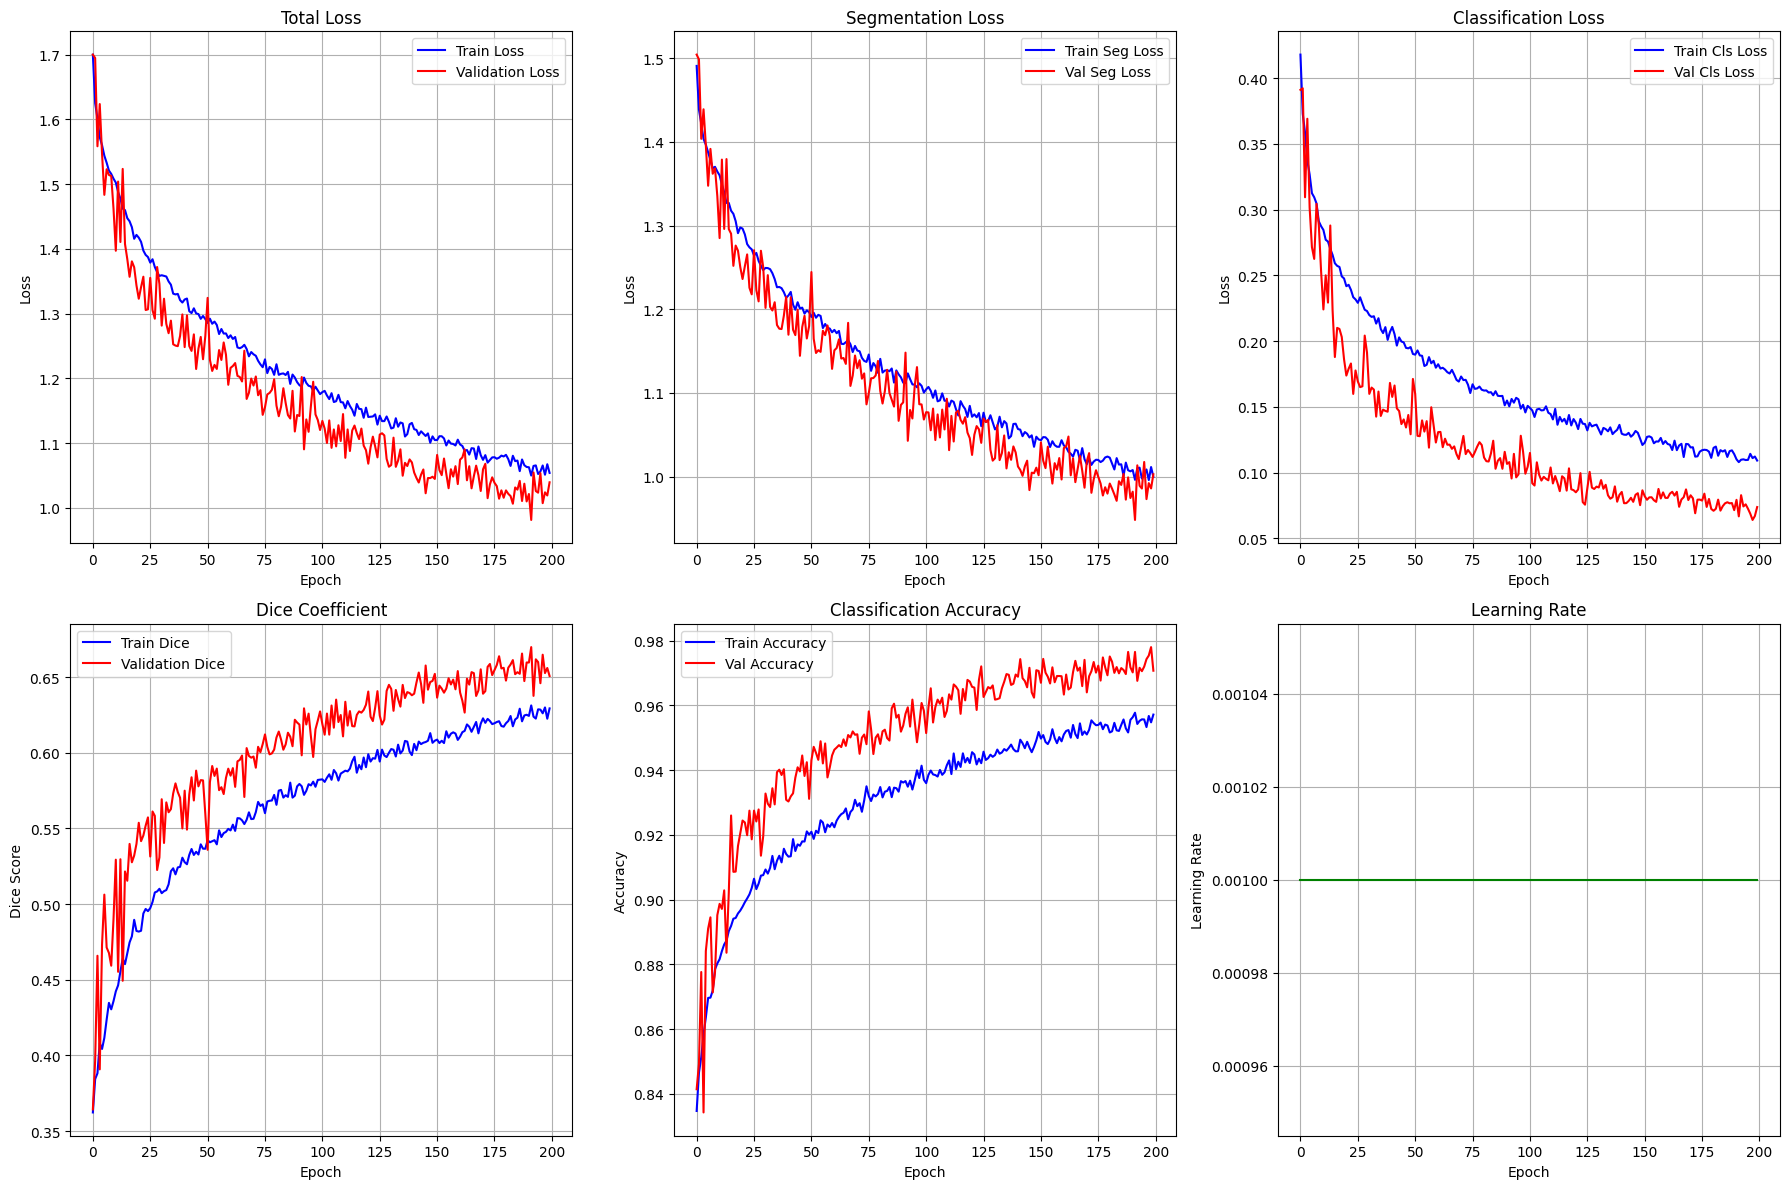


Training completed!
Best validation loss: 0.981507


Validation: 100%|██████████| 15/15 [00:02<00:00,  7.48it/s, Loss=1.1213, Dice=0.5680, Acc=0.9674]

loss: 1.0027936816215515, seg_loss: 0.9651140173276266, cls_loss: 0.07535929456353188, dice: 0.6430964310963948, cls_acc: 0.9733816941579183


In [16]:
CONFIG = {
    'working_path': 'train-256',
    'batch_size': 80,
    'export_type': 'RGB',
    'input_channels': 3,  # 1 for NDVI, 3 for RGB, 4 for RGBN
    'num_classes': 6,
    'filters_base': 32,
    'dropout_rate': 0.15,
    'learning_rate': 0.001,
    'num_epochs': epochs,
    'seg_weight': 1.0,
    'cls_weight': 0.5,
    'pos_weight': 2.0,
    'augmentation': True,
    'num_workers': 16
}

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Create datasets
print("Creating datasets...")
train_dataloader, val_dataloader, test_dataloader = create_pytorch_datasets(
    working_path=CONFIG['working_path'],
    batch_size=CONFIG['batch_size'],
    export_type=CONFIG['export_type'],
    augmentation=CONFIG['augmentation'],
    test_size=0.20,  # 20%
    val_size=0.05    # 5%
)

print(f"Training samples: {len(train_dataloader.dataset)}")
print(f"Validation samples: {len(val_dataloader.dataset)}")
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")

print("Creating model...")
model = OptimizedMultiTaskUNet256(
    input_channels=CONFIG['input_channels'],
    num_classes=CONFIG['num_classes'],
    filters_base=CONFIG['filters_base'],
    dropout_rate=CONFIG['dropout_rate']
)

# model = model.load_state_dict(torch.load("results/rgbn_multitask.pth"))


# model = torch.load("results/ndvi_multitask.pth")

trainer_rgb_256 = ModelTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=CONFIG['learning_rate'],
    seg_weight=CONFIG['seg_weight'],
    cls_weight=CONFIG['cls_weight'],
    pos_weight=CONFIG['pos_weight'],
    model_name="rgb-256"
)

history = trainer_rgb_256.train(CONFIG['num_epochs'])
trainer_rgb_256.val_dataloader = test_dataloader
test_loss, test_seg_loss, test_cls_loss, test_dice, test_cls_acc = trainer_rgb_256.validate_epoch()
print(f'loss: {test_loss}, seg_loss: {test_seg_loss}, cls_loss: {test_cls_loss}, dice: {test_dice}, cls_acc: {test_cls_acc}')

Using device: cuda
GPU: NVIDIA RTX A5000
GPU Memory: 23.5 GB
Creating datasets...
Split 'train': 4373 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Split 'val': 291 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Split 'test': 1166 samples (Total: 5830, Train: 4373, Val: 291, Test: 1166)
Training samples: 4373
Validation samples: 291
Training batches: 54
Validation batches: 4
Creating model...
Starting training for 200 epochs...
Device: cuda
Model parameters: 2,464,903

Epoch 1/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=1.5503, Dice=0.5786, Acc=0.8824]


New best model! Validation loss: 1.722199
Train Loss: 1.651720 | Val Loss: 1.722199
Train Dice: 0.3759 | Val Dice: 0.3853
Train Acc: 0.8353 | Val Acc: 0.8263
Learning Rate: 0.00100000

Epoch 2/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, Loss=1.3179, Dice=0.6464, Acc=0.9183]


New best model! Validation loss: 1.556119
Train Loss: 1.588634 | Val Loss: 1.556119
Train Dice: 0.3855 | Val Dice: 0.4212
Train Acc: 0.8517 | Val Acc: 0.8655
Learning Rate: 0.00100000

Epoch 3/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=1.3335, Dice=0.5991, Acc=0.9412]


New best model! Validation loss: 1.522727
Train Loss: 1.554447 | Val Loss: 1.522727
Train Dice: 0.4069 | Val Dice: 0.4731
Train Acc: 0.8642 | Val Acc: 0.8837
Learning Rate: 0.00100000

Epoch 4/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, Loss=1.3208, Dice=0.6092, Acc=0.9510]


New best model! Validation loss: 1.477136
Train Loss: 1.522451 | Val Loss: 1.477136
Train Dice: 0.4355 | Val Dice: 0.4808
Train Acc: 0.8694 | Val Acc: 0.8997
Learning Rate: 0.00100000

Epoch 5/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, Loss=1.2471, Dice=0.6243, Acc=0.9346]


Train Loss: 1.504202 | Val Loss: 1.495661
Train Dice: 0.4377 | Val Dice: 0.4425
Train Acc: 0.8734 | Val Acc: 0.8842
Learning Rate: 0.00100000

Epoch 6/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=1.2902, Dice=0.6178, Acc=0.9641]


New best model! Validation loss: 1.426465
Train Loss: 1.471990 | Val Loss: 1.426465
Train Dice: 0.4661 | Val Dice: 0.5175
Train Acc: 0.8797 | Val Acc: 0.9092
Learning Rate: 0.00100000

Epoch 7/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, Loss=1.2704, Dice=0.6103, Acc=0.9477]


New best model! Validation loss: 1.422740
Train Loss: 1.458250 | Val Loss: 1.422740
Train Dice: 0.4619 | Val Dice: 0.5111
Train Acc: 0.8829 | Val Acc: 0.9010
Learning Rate: 0.00100000

Epoch 8/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=1.2762, Dice=0.6161, Acc=0.9412]


Train Loss: 1.431984 | Val Loss: 1.428834
Train Dice: 0.4770 | Val Dice: 0.5061
Train Acc: 0.8854 | Val Acc: 0.8999
Learning Rate: 0.00100000

Epoch 9/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, Loss=1.2642, Dice=0.6405, Acc=0.9379]


Train Loss: 1.438280 | Val Loss: 1.461973
Train Dice: 0.4763 | Val Dice: 0.5031
Train Acc: 0.8891 | Val Acc: 0.8892
Learning Rate: 0.00100000

Epoch 10/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, Loss=1.2157, Dice=0.6360, Acc=0.9477]


New best model! Validation loss: 1.381484
Train Loss: 1.413112 | Val Loss: 1.381484
Train Dice: 0.4845 | Val Dice: 0.5313
Train Acc: 0.8904 | Val Acc: 0.9104
Learning Rate: 0.00100000
Checkpoint saved at epoch 10

Epoch 11/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=1.2656, Dice=0.6274, Acc=0.9477]


Train Loss: 1.399442 | Val Loss: 1.423699
Train Dice: 0.4938 | Val Dice: 0.5103
Train Acc: 0.8914 | Val Acc: 0.9078
Learning Rate: 0.00100000

Epoch 12/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, Loss=1.2112, Dice=0.6413, Acc=0.9510]


Train Loss: 1.383066 | Val Loss: 1.389993
Train Dice: 0.5010 | Val Dice: 0.5141
Train Acc: 0.8943 | Val Acc: 0.9070
Learning Rate: 0.00100000

Epoch 13/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, Loss=1.2453, Dice=0.6365, Acc=0.9641]


New best model! Validation loss: 1.343064
Train Loss: 1.375516 | Val Loss: 1.343064
Train Dice: 0.5028 | Val Dice: 0.5431
Train Acc: 0.8971 | Val Acc: 0.9238
Learning Rate: 0.00100000

Epoch 14/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, Loss=1.2953, Dice=0.6126, Acc=0.9510]


Train Loss: 1.359574 | Val Loss: 1.350673
Train Dice: 0.5110 | Val Dice: 0.5339
Train Acc: 0.9000 | Val Acc: 0.9195
Learning Rate: 0.00100000

Epoch 15/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, Loss=1.1048, Dice=0.6851, Acc=0.9412]


Train Loss: 1.357618 | Val Loss: 1.349731
Train Dice: 0.5132 | Val Dice: 0.5212
Train Acc: 0.8993 | Val Acc: 0.9082
Learning Rate: 0.00100000

Epoch 16/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, Loss=1.0688, Dice=0.6933, Acc=0.9575]


New best model! Validation loss: 1.301209
Train Loss: 1.345612 | Val Loss: 1.301209
Train Dice: 0.5173 | Val Dice: 0.5469
Train Acc: 0.9008 | Val Acc: 0.9191
Learning Rate: 0.00100000

Epoch 17/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=1.1547, Dice=0.6590, Acc=0.9608]


Train Loss: 1.324816 | Val Loss: 1.316917
Train Dice: 0.5272 | Val Dice: 0.5581
Train Acc: 0.9017 | Val Acc: 0.9183
Learning Rate: 0.00100000

Epoch 18/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, Loss=1.1532, Dice=0.6505, Acc=0.9739]


New best model! Validation loss: 1.288484
Train Loss: 1.336042 | Val Loss: 1.288484
Train Dice: 0.5195 | Val Dice: 0.5608
Train Acc: 0.9046 | Val Acc: 0.9336
Learning Rate: 0.00100000

Epoch 19/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, Loss=1.0255, Dice=0.7028, Acc=0.9673]


New best model! Validation loss: 1.278734
Train Loss: 1.313840 | Val Loss: 1.278734
Train Dice: 0.5330 | Val Dice: 0.5592
Train Acc: 0.9042 | Val Acc: 0.9304
Learning Rate: 0.00100000

Epoch 20/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, Loss=1.1182, Dice=0.6640, Acc=0.9673]


Train Loss: 1.318776 | Val Loss: 1.292261
Train Dice: 0.5265 | Val Dice: 0.5547
Train Acc: 0.9059 | Val Acc: 0.9168
Learning Rate: 0.00100000
Checkpoint saved at epoch 20

Epoch 21/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, Loss=1.1126, Dice=0.6751, Acc=0.9608]


Train Loss: 1.304316 | Val Loss: 1.309397
Train Dice: 0.5350 | Val Dice: 0.5433
Train Acc: 0.9096 | Val Acc: 0.9256
Learning Rate: 0.00100000

Epoch 22/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, Loss=1.1784, Dice=0.6261, Acc=0.9608]


Train Loss: 1.301782 | Val Loss: 1.333276
Train Dice: 0.5343 | Val Dice: 0.5231
Train Acc: 0.9079 | Val Acc: 0.9272
Learning Rate: 0.00100000

Epoch 23/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, Loss=1.2633, Dice=0.6243, Acc=0.9706]


Train Loss: 1.298360 | Val Loss: 1.328932
Train Dice: 0.5360 | Val Dice: 0.5507
Train Acc: 0.9088 | Val Acc: 0.9281
Learning Rate: 0.00100000

Epoch 24/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=0.9956, Dice=0.6997, Acc=0.9510]


Train Loss: 1.294740 | Val Loss: 1.303349
Train Dice: 0.5338 | Val Dice: 0.5304
Train Acc: 0.9139 | Val Acc: 0.9174
Learning Rate: 0.00100000

Epoch 25/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, Loss=1.0936, Dice=0.6826, Acc=0.9837]


New best model! Validation loss: 1.259777
Train Loss: 1.276259 | Val Loss: 1.259777
Train Dice: 0.5465 | Val Dice: 0.5676
Train Acc: 0.9120 | Val Acc: 0.9329
Learning Rate: 0.00100000

Epoch 26/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, Loss=1.0538, Dice=0.6797, Acc=0.9869]


New best model! Validation loss: 1.240169
Train Loss: 1.271734 | Val Loss: 1.240169
Train Dice: 0.5500 | Val Dice: 0.5730
Train Acc: 0.9134 | Val Acc: 0.9436
Learning Rate: 0.00100000

Epoch 27/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=1.0637, Dice=0.6858, Acc=0.9673]


Train Loss: 1.272648 | Val Loss: 1.271768
Train Dice: 0.5526 | Val Dice: 0.5663
Train Acc: 0.9140 | Val Acc: 0.9272
Learning Rate: 0.00100000

Epoch 28/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, Loss=1.2019, Dice=0.6382, Acc=0.9739]


Train Loss: 1.267187 | Val Loss: 1.301987
Train Dice: 0.5529 | Val Dice: 0.5525
Train Acc: 0.9169 | Val Acc: 0.9289
Learning Rate: 0.00100000

Epoch 29/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.9896, Dice=0.7007, Acc=0.9869]


New best model! Validation loss: 1.205837
Train Loss: 1.260124 | Val Loss: 1.205837
Train Dice: 0.5525 | Val Dice: 0.5896
Train Acc: 0.9154 | Val Acc: 0.9368
Learning Rate: 0.00100000

Epoch 30/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, Loss=1.0161, Dice=0.6920, Acc=0.9837]


Train Loss: 1.251174 | Val Loss: 1.244340
Train Dice: 0.5568 | Val Dice: 0.5746
Train Acc: 0.9162 | Val Acc: 0.9355
Learning Rate: 0.00100000
Checkpoint saved at epoch 30

Epoch 31/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, Loss=1.0602, Dice=0.6717, Acc=0.9739]


Train Loss: 1.260091 | Val Loss: 1.240183
Train Dice: 0.5544 | Val Dice: 0.5761
Train Acc: 0.9160 | Val Acc: 0.9346
Learning Rate: 0.00100000

Epoch 32/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=1.0209, Dice=0.6930, Acc=0.9837]


Train Loss: 1.250160 | Val Loss: 1.211477
Train Dice: 0.5564 | Val Dice: 0.5919
Train Acc: 0.9168 | Val Acc: 0.9402
Learning Rate: 0.00100000

Epoch 33/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=1.2055, Dice=0.6262, Acc=0.9444]


Train Loss: 1.239115 | Val Loss: 1.340804
Train Dice: 0.5597 | Val Dice: 0.5270
Train Acc: 0.9200 | Val Acc: 0.9148
Learning Rate: 0.00100000

Epoch 34/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, Loss=1.1575, Dice=0.6499, Acc=0.9510]


Train Loss: 1.241635 | Val Loss: 1.290599
Train Dice: 0.5585 | Val Dice: 0.5620
Train Acc: 0.9177 | Val Acc: 0.9190
Learning Rate: 0.00100000

Epoch 35/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, Loss=1.0965, Dice=0.6704, Acc=0.9869]


Train Loss: 1.225015 | Val Loss: 1.233424
Train Dice: 0.5667 | Val Dice: 0.5847
Train Acc: 0.9197 | Val Acc: 0.9394
Learning Rate: 0.00100000

Epoch 36/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, Loss=1.0266, Dice=0.6981, Acc=0.9771]


Train Loss: 1.231562 | Val Loss: 1.220639
Train Dice: 0.5643 | Val Dice: 0.5903
Train Acc: 0.9191 | Val Acc: 0.9344
Learning Rate: 0.00100000

Epoch 37/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=1.1078, Dice=0.6477, Acc=0.9771]


Train Loss: 1.238923 | Val Loss: 1.276151
Train Dice: 0.5619 | Val Dice: 0.5566
Train Acc: 0.9195 | Val Acc: 0.9266
Learning Rate: 0.00100000

Epoch 38/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, Loss=1.0215, Dice=0.7012, Acc=0.9869]


New best model! Validation loss: 1.204427
Train Loss: 1.220863 | Val Loss: 1.204427
Train Dice: 0.5708 | Val Dice: 0.5943
Train Acc: 0.9208 | Val Acc: 0.9394
Learning Rate: 0.00100000

Epoch 39/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, Loss=1.0228, Dice=0.7054, Acc=0.9739]


New best model! Validation loss: 1.198688
Train Loss: 1.211066 | Val Loss: 1.198688
Train Dice: 0.5744 | Val Dice: 0.5937
Train Acc: 0.9223 | Val Acc: 0.9424
Learning Rate: 0.00100000

Epoch 40/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, Loss=1.0764, Dice=0.6768, Acc=0.9902]


Train Loss: 1.214776 | Val Loss: 1.241130
Train Dice: 0.5702 | Val Dice: 0.5786
Train Acc: 0.9224 | Val Acc: 0.9470
Learning Rate: 0.00100000
Checkpoint saved at epoch 40

Epoch 41/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s, Loss=0.9959, Dice=0.6849, Acc=0.9869]


Train Loss: 1.211643 | Val Loss: 1.224763
Train Dice: 0.5739 | Val Dice: 0.5800
Train Acc: 0.9239 | Val Acc: 0.9368
Learning Rate: 0.00100000

Epoch 42/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, Loss=0.9893, Dice=0.7081, Acc=0.9869]


New best model! Validation loss: 1.163812
Train Loss: 1.209799 | Val Loss: 1.163812
Train Dice: 0.5725 | Val Dice: 0.6118
Train Acc: 0.9257 | Val Acc: 0.9436
Learning Rate: 0.00100000

Epoch 43/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=1.1266, Dice=0.6452, Acc=0.9608]


Train Loss: 1.210040 | Val Loss: 1.273265
Train Dice: 0.5711 | Val Dice: 0.5526
Train Acc: 0.9240 | Val Acc: 0.9267
Learning Rate: 0.00100000

Epoch 44/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, Loss=1.1194, Dice=0.6686, Acc=0.9771]


Train Loss: 1.209215 | Val Loss: 1.229845
Train Dice: 0.5705 | Val Dice: 0.5850
Train Acc: 0.9262 | Val Acc: 0.9380
Learning Rate: 0.00100000

Epoch 45/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, Loss=1.0073, Dice=0.7016, Acc=0.9837]


Train Loss: 1.196316 | Val Loss: 1.164174
Train Dice: 0.5773 | Val Dice: 0.6128
Train Acc: 0.9255 | Val Acc: 0.9428
Learning Rate: 0.00100000

Epoch 46/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=1.0725, Dice=0.6773, Acc=0.9869]


Train Loss: 1.198549 | Val Loss: 1.193926
Train Dice: 0.5777 | Val Dice: 0.5957
Train Acc: 0.9255 | Val Acc: 0.9493
Learning Rate: 0.00100000

Epoch 47/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, Loss=1.0755, Dice=0.6635, Acc=0.9869]


Train Loss: 1.195291 | Val Loss: 1.213100
Train Dice: 0.5789 | Val Dice: 0.5766
Train Acc: 0.9247 | Val Acc: 0.9488
Learning Rate: 0.00100000

Epoch 48/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, Loss=1.0782, Dice=0.6814, Acc=0.9869]


Train Loss: 1.186073 | Val Loss: 1.205575
Train Dice: 0.5820 | Val Dice: 0.5995
Train Acc: 0.9287 | Val Acc: 0.9368
Learning Rate: 0.00100000

Epoch 49/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=0.9481, Dice=0.7127, Acc=0.9771]


Train Loss: 1.183571 | Val Loss: 1.182705
Train Dice: 0.5839 | Val Dice: 0.5966
Train Acc: 0.9290 | Val Acc: 0.9406
Learning Rate: 0.00100000

Epoch 50/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=1.0486, Dice=0.6987, Acc=0.9902]


Train Loss: 1.184807 | Val Loss: 1.167465
Train Dice: 0.5817 | Val Dice: 0.6076
Train Acc: 0.9271 | Val Acc: 0.9517
Learning Rate: 0.00100000
Checkpoint saved at epoch 50

Epoch 51/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=1.2392, Dice=0.6480, Acc=0.9869]


Train Loss: 1.180530 | Val Loss: 1.239809
Train Dice: 0.5844 | Val Dice: 0.5880
Train Acc: 0.9308 | Val Acc: 0.9420
Learning Rate: 0.00100000

Epoch 52/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=1.0614, Dice=0.6849, Acc=0.9967]


Train Loss: 1.179136 | Val Loss: 1.178180
Train Dice: 0.5817 | Val Dice: 0.6004
Train Acc: 0.9263 | Val Acc: 0.9544
Learning Rate: 0.00100000

Epoch 53/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.9841, Dice=0.7146, Acc=0.9869]


Train Loss: 1.170162 | Val Loss: 1.193461
Train Dice: 0.5917 | Val Dice: 0.6024
Train Acc: 0.9274 | Val Acc: 0.9332
Learning Rate: 0.00100000

Epoch 54/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=0.8757, Dice=0.7357, Acc=0.9935]


New best model! Validation loss: 1.125831
Train Loss: 1.173586 | Val Loss: 1.125831
Train Dice: 0.5874 | Val Dice: 0.6187
Train Acc: 0.9320 | Val Acc: 0.9468
Learning Rate: 0.00100000

Epoch 55/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.9620, Dice=0.7075, Acc=0.9935]


Train Loss: 1.156098 | Val Loss: 1.144854
Train Dice: 0.5942 | Val Dice: 0.6104
Train Acc: 0.9311 | Val Acc: 0.9531
Learning Rate: 0.00100000

Epoch 56/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=1.0295, Dice=0.6995, Acc=0.9935]


Train Loss: 1.174006 | Val Loss: 1.146513
Train Dice: 0.5886 | Val Dice: 0.6150
Train Acc: 0.9292 | Val Acc: 0.9551
Learning Rate: 0.00100000

Epoch 57/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.9880, Dice=0.7082, Acc=0.9837]


Train Loss: 1.170240 | Val Loss: 1.160211
Train Dice: 0.5870 | Val Dice: 0.6103
Train Acc: 0.9300 | Val Acc: 0.9433
Learning Rate: 0.00100000

Epoch 58/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, Loss=1.0461, Dice=0.6826, Acc=0.9935]


Train Loss: 1.168034 | Val Loss: 1.178509
Train Dice: 0.5881 | Val Dice: 0.5986
Train Acc: 0.9308 | Val Acc: 0.9484
Learning Rate: 0.00100000

Epoch 59/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, Loss=0.9676, Dice=0.7181, Acc=0.9967]


Train Loss: 1.152697 | Val Loss: 1.151587
Train Dice: 0.5969 | Val Dice: 0.6124
Train Acc: 0.9306 | Val Acc: 0.9533
Learning Rate: 0.00100000

Epoch 60/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=1.0739, Dice=0.6922, Acc=0.9935]


Train Loss: 1.158693 | Val Loss: 1.159862
Train Dice: 0.5941 | Val Dice: 0.6174
Train Acc: 0.9311 | Val Acc: 0.9510
Learning Rate: 0.00100000
Checkpoint saved at epoch 60

Epoch 61/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, Loss=0.9040, Dice=0.7349, Acc=0.9935]


Train Loss: 1.156857 | Val Loss: 1.130017
Train Dice: 0.5940 | Val Dice: 0.6192
Train Acc: 0.9345 | Val Acc: 0.9452
Learning Rate: 0.00100000

Epoch 62/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, Loss=0.9416, Dice=0.7055, Acc=0.9935]


Train Loss: 1.148305 | Val Loss: 1.150128
Train Dice: 0.5974 | Val Dice: 0.6002
Train Acc: 0.9334 | Val Acc: 0.9525
Learning Rate: 0.00100000

Epoch 63/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=1.1388, Dice=0.6805, Acc=0.9935]


Train Loss: 1.142428 | Val Loss: 1.146773
Train Dice: 0.5992 | Val Dice: 0.6260
Train Acc: 0.9345 | Val Acc: 0.9468
Learning Rate: 0.00100000

Epoch 64/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=0.9147, Dice=0.7356, Acc=0.9935]


New best model! Validation loss: 1.101732
Train Loss: 1.147029 | Val Loss: 1.101732
Train Dice: 0.5970 | Val Dice: 0.6269
Train Acc: 0.9338 | Val Acc: 0.9562
Learning Rate: 0.00100000

Epoch 65/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, Loss=0.9959, Dice=0.7039, Acc=1.0000]


Train Loss: 1.148011 | Val Loss: 1.119233
Train Dice: 0.5983 | Val Dice: 0.6196
Train Acc: 0.9308 | Val Acc: 0.9625
Learning Rate: 0.00100000

Epoch 66/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, Loss=1.1398, Dice=0.6727, Acc=0.9935]


Train Loss: 1.145613 | Val Loss: 1.178857
Train Dice: 0.5970 | Val Dice: 0.6083
Train Acc: 0.9368 | Val Acc: 0.9557
Learning Rate: 0.00100000

Epoch 67/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, Loss=0.9962, Dice=0.7066, Acc=1.0000]


Train Loss: 1.138238 | Val Loss: 1.160067
Train Dice: 0.6029 | Val Dice: 0.6093
Train Acc: 0.9331 | Val Acc: 0.9521
Learning Rate: 0.00100000

Epoch 68/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, Loss=0.9082, Dice=0.7255, Acc=0.9902]


Train Loss: 1.147542 | Val Loss: 1.134815
Train Dice: 0.5965 | Val Dice: 0.6126
Train Acc: 0.9360 | Val Acc: 0.9470
Learning Rate: 0.00100000

Epoch 69/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=0.9213, Dice=0.7285, Acc=0.9967]


New best model! Validation loss: 1.089642
Train Loss: 1.136446 | Val Loss: 1.089642
Train Dice: 0.6014 | Val Dice: 0.6327
Train Acc: 0.9347 | Val Acc: 0.9549
Learning Rate: 0.00100000

Epoch 70/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=0.9664, Dice=0.7198, Acc=0.9935]


Train Loss: 1.141097 | Val Loss: 1.116259
Train Dice: 0.6024 | Val Dice: 0.6302
Train Acc: 0.9329 | Val Acc: 0.9473
Learning Rate: 0.00100000
Checkpoint saved at epoch 70

Epoch 71/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, Loss=0.9350, Dice=0.7215, Acc=0.9967]


Train Loss: 1.140587 | Val Loss: 1.104001
Train Dice: 0.5969 | Val Dice: 0.6276
Train Acc: 0.9364 | Val Acc: 0.9549
Learning Rate: 0.00100000

Epoch 72/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, Loss=0.9562, Dice=0.7305, Acc=0.9902]


New best model! Validation loss: 1.087542
Train Loss: 1.128236 | Val Loss: 1.087542
Train Dice: 0.6035 | Val Dice: 0.6456
Train Acc: 0.9383 | Val Acc: 0.9543
Learning Rate: 0.00100000

Epoch 73/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=0.9332, Dice=0.7270, Acc=0.9935]


Train Loss: 1.124426 | Val Loss: 1.120827
Train Dice: 0.6057 | Val Dice: 0.6217
Train Acc: 0.9376 | Val Acc: 0.9546
Learning Rate: 0.00100000

Epoch 74/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, Loss=0.9942, Dice=0.7040, Acc=0.9935]


Train Loss: 1.135860 | Val Loss: 1.117473
Train Dice: 0.5997 | Val Dice: 0.6221
Train Acc: 0.9345 | Val Acc: 0.9629
Learning Rate: 0.00100000

Epoch 75/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.9079, Dice=0.7338, Acc=0.9837]


Train Loss: 1.125472 | Val Loss: 1.122352
Train Dice: 0.6048 | Val Dice: 0.6206
Train Acc: 0.9357 | Val Acc: 0.9496
Learning Rate: 0.00100000

Epoch 76/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=1.1282, Dice=0.6732, Acc=0.9902]


Train Loss: 1.124402 | Val Loss: 1.153567
Train Dice: 0.6050 | Val Dice: 0.6189
Train Acc: 0.9361 | Val Acc: 0.9569
Learning Rate: 0.00100000

Epoch 77/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=0.9595, Dice=0.7170, Acc=0.9935]


Train Loss: 1.118383 | Val Loss: 1.104051
Train Dice: 0.6058 | Val Dice: 0.6286
Train Acc: 0.9373 | Val Acc: 0.9609
Learning Rate: 0.00100000

Epoch 78/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, Loss=0.9020, Dice=0.7333, Acc=0.9967]


New best model! Validation loss: 1.068290
Train Loss: 1.125090 | Val Loss: 1.068290
Train Dice: 0.6052 | Val Dice: 0.6432
Train Acc: 0.9347 | Val Acc: 0.9513
Learning Rate: 0.00100000

Epoch 79/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, Loss=0.9682, Dice=0.7210, Acc=0.9967]


Train Loss: 1.112140 | Val Loss: 1.119480
Train Dice: 0.6098 | Val Dice: 0.6223
Train Acc: 0.9386 | Val Acc: 0.9612
Learning Rate: 0.00100000

Epoch 80/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s, Loss=0.9761, Dice=0.7079, Acc=0.9967]


Train Loss: 1.109963 | Val Loss: 1.136168
Train Dice: 0.6115 | Val Dice: 0.6192
Train Acc: 0.9392 | Val Acc: 0.9533
Learning Rate: 0.00100000
Checkpoint saved at epoch 80

Epoch 81/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, Loss=0.8791, Dice=0.7389, Acc=1.0000]


Train Loss: 1.112580 | Val Loss: 1.089106
Train Dice: 0.6092 | Val Dice: 0.6319
Train Acc: 0.9398 | Val Acc: 0.9568
Learning Rate: 0.00100000

Epoch 82/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, Loss=0.9330, Dice=0.7284, Acc=0.9967]


Train Loss: 1.111009 | Val Loss: 1.089639
Train Dice: 0.6112 | Val Dice: 0.6371
Train Acc: 0.9379 | Val Acc: 0.9596
Learning Rate: 0.00100000

Epoch 83/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, Loss=0.8944, Dice=0.7281, Acc=0.9967]


Train Loss: 1.112298 | Val Loss: 1.096174
Train Dice: 0.6124 | Val Dice: 0.6241
Train Acc: 0.9375 | Val Acc: 0.9549
Learning Rate: 0.00100000

Epoch 84/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, Loss=1.0891, Dice=0.6970, Acc=0.9902]


Train Loss: 1.105523 | Val Loss: 1.143662
Train Dice: 0.6152 | Val Dice: 0.6231
Train Acc: 0.9385 | Val Acc: 0.9585
Learning Rate: 0.00100000

Epoch 85/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, Loss=1.1502, Dice=0.6927, Acc=0.9935]


Train Loss: 1.097595 | Val Loss: 1.158697
Train Dice: 0.6174 | Val Dice: 0.6224
Train Acc: 0.9399 | Val Acc: 0.9598
Learning Rate: 0.00100000

Epoch 86/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.9205, Dice=0.7333, Acc=0.9967]


Train Loss: 1.109020 | Val Loss: 1.078022
Train Dice: 0.6104 | Val Dice: 0.6359
Train Acc: 0.9420 | Val Acc: 0.9632
Learning Rate: 0.00100000

Epoch 87/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=0.9394, Dice=0.7182, Acc=0.9935]


Train Loss: 1.101754 | Val Loss: 1.105395
Train Dice: 0.6170 | Val Dice: 0.6279
Train Acc: 0.9406 | Val Acc: 0.9499
Learning Rate: 0.00100000

Epoch 88/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, Loss=0.9357, Dice=0.7229, Acc=0.9967]


Train Loss: 1.101323 | Val Loss: 1.102550
Train Dice: 0.6157 | Val Dice: 0.6277
Train Acc: 0.9406 | Val Acc: 0.9606
Learning Rate: 0.00100000

Epoch 89/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, Loss=0.9251, Dice=0.7173, Acc=0.9967]


Train Loss: 1.095899 | Val Loss: 1.088488
Train Dice: 0.6186 | Val Dice: 0.6228
Train Acc: 0.9407 | Val Acc: 0.9601
Learning Rate: 0.00100000

Epoch 90/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, Loss=0.9238, Dice=0.7274, Acc=0.9967]


Train Loss: 1.094320 | Val Loss: 1.089858
Train Dice: 0.6164 | Val Dice: 0.6296
Train Acc: 0.9425 | Val Acc: 0.9580
Learning Rate: 0.00100000
Checkpoint saved at epoch 90

Epoch 91/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, Loss=1.0146, Dice=0.7099, Acc=0.9935]


Train Loss: 1.094574 | Val Loss: 1.148516
Train Dice: 0.6176 | Val Dice: 0.6105
Train Acc: 0.9392 | Val Acc: 0.9614
Learning Rate: 0.00100000

Epoch 92/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=0.9003, Dice=0.7376, Acc=0.9967]


Train Loss: 1.099177 | Val Loss: 1.108696
Train Dice: 0.6161 | Val Dice: 0.6234
Train Acc: 0.9402 | Val Acc: 0.9554
Learning Rate: 0.00100000

Epoch 93/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=0.9511, Dice=0.7246, Acc=0.9967]


Train Loss: 1.092316 | Val Loss: 1.080115
Train Dice: 0.6170 | Val Dice: 0.6402
Train Acc: 0.9423 | Val Acc: 0.9638
Learning Rate: 0.00100000

Epoch 94/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, Loss=0.9069, Dice=0.7385, Acc=1.0000]


New best model! Validation loss: 1.056042
Train Loss: 1.079824 | Val Loss: 1.056042
Train Dice: 0.6249 | Val Dice: 0.6437
Train Acc: 0.9409 | Val Acc: 0.9661
Learning Rate: 0.00100000

Epoch 95/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, Loss=0.9889, Dice=0.7133, Acc=0.9967]


Train Loss: 1.093159 | Val Loss: 1.072336
Train Dice: 0.6153 | Val Dice: 0.6436
Train Acc: 0.9409 | Val Acc: 0.9627
Learning Rate: 0.00100000

Epoch 96/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, Loss=0.8937, Dice=0.7320, Acc=0.9967]


New best model! Validation loss: 1.056023
Train Loss: 1.084765 | Val Loss: 1.056023
Train Dice: 0.6214 | Val Dice: 0.6396
Train Acc: 0.9421 | Val Acc: 0.9690
Learning Rate: 0.00100000

Epoch 97/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.9096, Dice=0.7229, Acc=0.9935]


Train Loss: 1.082494 | Val Loss: 1.083645
Train Dice: 0.6242 | Val Dice: 0.6320
Train Acc: 0.9415 | Val Acc: 0.9546
Learning Rate: 0.00100000

Epoch 98/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=0.9148, Dice=0.7342, Acc=1.0000]


New best model! Validation loss: 1.055743
Train Loss: 1.092792 | Val Loss: 1.055743
Train Dice: 0.6184 | Val Dice: 0.6443
Train Acc: 0.9434 | Val Acc: 0.9625
Learning Rate: 0.00100000

Epoch 99/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, Loss=0.9374, Dice=0.7092, Acc=0.9967]


Train Loss: 1.076485 | Val Loss: 1.093637
Train Dice: 0.6252 | Val Dice: 0.6209
Train Acc: 0.9434 | Val Acc: 0.9664
Learning Rate: 0.00100000

Epoch 100/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=1.1261, Dice=0.6773, Acc=0.9935]


Train Loss: 1.083614 | Val Loss: 1.142457
Train Dice: 0.6210 | Val Dice: 0.6186
Train Acc: 0.9441 | Val Acc: 0.9603
Learning Rate: 0.00100000
Checkpoint saved at epoch 100

Epoch 101/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, Loss=0.9904, Dice=0.7122, Acc=0.9935]


Train Loss: 1.079457 | Val Loss: 1.117355
Train Dice: 0.6226 | Val Dice: 0.6198
Train Acc: 0.9431 | Val Acc: 0.9640
Learning Rate: 0.00100000

Epoch 102/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8355, Dice=0.7538, Acc=0.9935]


New best model! Validation loss: 1.039973
Train Loss: 1.078535 | Val Loss: 1.039973
Train Dice: 0.6228 | Val Dice: 0.6490
Train Acc: 0.9426 | Val Acc: 0.9650
Learning Rate: 0.00100000

Epoch 103/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, Loss=0.8674, Dice=0.7400, Acc=0.9935]


Train Loss: 1.082428 | Val Loss: 1.048633
Train Dice: 0.6216 | Val Dice: 0.6416
Train Acc: 0.9436 | Val Acc: 0.9624
Learning Rate: 0.00100000

Epoch 104/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=0.8682, Dice=0.7404, Acc=0.9967]


Train Loss: 1.077329 | Val Loss: 1.060109
Train Dice: 0.6242 | Val Dice: 0.6458
Train Acc: 0.9457 | Val Acc: 0.9586
Learning Rate: 0.00100000

Epoch 105/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, Loss=0.9511, Dice=0.7099, Acc=0.9967]


Train Loss: 1.081656 | Val Loss: 1.061491
Train Dice: 0.6214 | Val Dice: 0.6430
Train Acc: 0.9428 | Val Acc: 0.9622
Learning Rate: 0.00100000

Epoch 106/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.9019, Dice=0.7322, Acc=0.9967]


Train Loss: 1.085558 | Val Loss: 1.056155
Train Dice: 0.6195 | Val Dice: 0.6477
Train Acc: 0.9456 | Val Acc: 0.9648
Learning Rate: 0.00100000

Epoch 107/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, Loss=0.9063, Dice=0.7335, Acc=0.9902]


Train Loss: 1.065833 | Val Loss: 1.062177
Train Dice: 0.6305 | Val Dice: 0.6428
Train Acc: 0.9473 | Val Acc: 0.9611
Learning Rate: 0.00100000

Epoch 108/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, Loss=0.8330, Dice=0.7507, Acc=1.0000]


New best model! Validation loss: 1.024643
Train Loss: 1.070290 | Val Loss: 1.024643
Train Dice: 0.6261 | Val Dice: 0.6541
Train Acc: 0.9442 | Val Acc: 0.9688
Learning Rate: 0.00100000

Epoch 109/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=0.9921, Dice=0.7118, Acc=0.9935]


Train Loss: 1.059602 | Val Loss: 1.109159
Train Dice: 0.6307 | Val Dice: 0.6290
Train Acc: 0.9482 | Val Acc: 0.9624
Learning Rate: 0.00100000

Epoch 110/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=0.8911, Dice=0.7349, Acc=0.9935]


Train Loss: 1.065449 | Val Loss: 1.088370
Train Dice: 0.6273 | Val Dice: 0.6286
Train Acc: 0.9466 | Val Acc: 0.9624
Learning Rate: 0.00100000
Checkpoint saved at epoch 110

Epoch 111/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.9355, Dice=0.7310, Acc=1.0000]


Train Loss: 1.067083 | Val Loss: 1.048633
Train Dice: 0.6271 | Val Dice: 0.6517
Train Acc: 0.9463 | Val Acc: 0.9667
Learning Rate: 0.00100000

Epoch 112/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=0.9683, Dice=0.7241, Acc=0.9967]


Train Loss: 1.060102 | Val Loss: 1.050800
Train Dice: 0.6308 | Val Dice: 0.6527
Train Acc: 0.9461 | Val Acc: 0.9685
Learning Rate: 0.00100000

Epoch 113/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, Loss=0.9745, Dice=0.7180, Acc=0.9967]


Train Loss: 1.061476 | Val Loss: 1.067095
Train Dice: 0.6269 | Val Dice: 0.6452
Train Acc: 0.9491 | Val Acc: 0.9648
Learning Rate: 0.00100000

Epoch 114/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.9391, Dice=0.7257, Acc=0.9935]


Train Loss: 1.060171 | Val Loss: 1.080349
Train Dice: 0.6279 | Val Dice: 0.6358
Train Acc: 0.9481 | Val Acc: 0.9619
Learning Rate: 0.00100000

Epoch 115/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=0.8796, Dice=0.7405, Acc=0.9967]


Train Loss: 1.057673 | Val Loss: 1.042618
Train Dice: 0.6304 | Val Dice: 0.6506
Train Acc: 0.9483 | Val Acc: 0.9690
Learning Rate: 0.00100000

Epoch 116/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=0.9770, Dice=0.7266, Acc=0.9902]


Train Loss: 1.055196 | Val Loss: 1.072896
Train Dice: 0.6304 | Val Dice: 0.6475
Train Acc: 0.9470 | Val Acc: 0.9679
Learning Rate: 0.00100000

Epoch 117/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, Loss=0.8896, Dice=0.7352, Acc=0.9967]


Train Loss: 1.045012 | Val Loss: 1.035693
Train Dice: 0.6374 | Val Dice: 0.6509
Train Acc: 0.9470 | Val Acc: 0.9711
Learning Rate: 0.00100000

Epoch 118/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, Loss=0.8610, Dice=0.7456, Acc=0.9935]


New best model! Validation loss: 1.017571
Train Loss: 1.057518 | Val Loss: 1.017571
Train Dice: 0.6300 | Val Dice: 0.6584
Train Acc: 0.9462 | Val Acc: 0.9676
Learning Rate: 0.00100000

Epoch 119/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s, Loss=0.8528, Dice=0.7400, Acc=0.9967]


Train Loss: 1.053746 | Val Loss: 1.026634
Train Dice: 0.6319 | Val Dice: 0.6459
Train Acc: 0.9491 | Val Acc: 0.9752
Learning Rate: 0.00100000

Epoch 120/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.8677, Dice=0.7399, Acc=0.9967]


New best model! Validation loss: 1.005617
Train Loss: 1.055374 | Val Loss: 1.005617
Train Dice: 0.6328 | Val Dice: 0.6666
Train Acc: 0.9479 | Val Acc: 0.9664
Learning Rate: 0.00100000
Checkpoint saved at epoch 120

Epoch 121/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=0.8096, Dice=0.7520, Acc=0.9935]


Train Loss: 1.051985 | Val Loss: 1.015533
Train Dice: 0.6318 | Val Dice: 0.6567
Train Acc: 0.9486 | Val Acc: 0.9666
Learning Rate: 0.00100000

Epoch 122/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, Loss=0.8842, Dice=0.7335, Acc=0.9902]


Train Loss: 1.047769 | Val Loss: 1.074008
Train Dice: 0.6317 | Val Dice: 0.6348
Train Acc: 0.9474 | Val Acc: 0.9642
Learning Rate: 0.00100000

Epoch 123/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=0.8856, Dice=0.7389, Acc=0.9967]


Train Loss: 1.052726 | Val Loss: 1.028825
Train Dice: 0.6325 | Val Dice: 0.6490
Train Acc: 0.9487 | Val Acc: 0.9658
Learning Rate: 0.00100000

Epoch 124/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, Loss=0.9227, Dice=0.7221, Acc=0.9935]


Train Loss: 1.048235 | Val Loss: 1.076173
Train Dice: 0.6331 | Val Dice: 0.6356
Train Acc: 0.9501 | Val Acc: 0.9671
Learning Rate: 0.00100000

Epoch 125/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s, Loss=0.9094, Dice=0.7383, Acc=0.9967]


Train Loss: 1.035958 | Val Loss: 1.043024
Train Dice: 0.6385 | Val Dice: 0.6520
Train Acc: 0.9517 | Val Acc: 0.9679
Learning Rate: 0.00100000

Epoch 126/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, Loss=0.9944, Dice=0.7126, Acc=0.9967]


Train Loss: 1.039913 | Val Loss: 1.051923
Train Dice: 0.6362 | Val Dice: 0.6544
Train Acc: 0.9505 | Val Acc: 0.9658
Learning Rate: 0.00100000

Epoch 127/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, Loss=0.9176, Dice=0.7321, Acc=0.9967]


Train Loss: 1.040647 | Val Loss: 1.060374
Train Dice: 0.6356 | Val Dice: 0.6489
Train Acc: 0.9505 | Val Acc: 0.9726
Learning Rate: 0.00100000

Epoch 128/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=0.9005, Dice=0.7369, Acc=0.9967]


Train Loss: 1.030296 | Val Loss: 1.047766
Train Dice: 0.6427 | Val Dice: 0.6478
Train Acc: 0.9497 | Val Acc: 0.9679
Learning Rate: 0.00100000

Epoch 129/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, Loss=0.8636, Dice=0.7463, Acc=0.9967]


Train Loss: 1.033394 | Val Loss: 1.010276
Train Dice: 0.6397 | Val Dice: 0.6662
Train Acc: 0.9522 | Val Acc: 0.9757
Learning Rate: 0.00100000

Epoch 130/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=0.9190, Dice=0.7158, Acc=0.9902]


Train Loss: 1.029438 | Val Loss: 1.077294
Train Dice: 0.6410 | Val Dice: 0.6347
Train Acc: 0.9506 | Val Acc: 0.9574
Learning Rate: 0.00100000
Checkpoint saved at epoch 130

Epoch 131/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, Loss=0.9603, Dice=0.7195, Acc=0.9967]


Train Loss: 1.031814 | Val Loss: 1.060819
Train Dice: 0.6411 | Val Dice: 0.6464
Train Acc: 0.9508 | Val Acc: 0.9700
Learning Rate: 0.00100000

Epoch 132/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, Loss=0.9590, Dice=0.7283, Acc=0.9935]


Train Loss: 1.025207 | Val Loss: 1.035341
Train Dice: 0.6444 | Val Dice: 0.6582
Train Acc: 0.9519 | Val Acc: 0.9770
Learning Rate: 0.00100000

Epoch 133/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=0.8738, Dice=0.7378, Acc=0.9902]


Train Loss: 1.025674 | Val Loss: 1.015254
Train Dice: 0.6432 | Val Dice: 0.6565
Train Acc: 0.9530 | Val Acc: 0.9673
Learning Rate: 0.00100000

Epoch 134/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.8956, Dice=0.7361, Acc=0.9935]


Train Loss: 1.041378 | Val Loss: 1.027259
Train Dice: 0.6368 | Val Dice: 0.6569
Train Acc: 0.9470 | Val Acc: 0.9692
Learning Rate: 0.00100000

Epoch 135/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, Loss=0.8642, Dice=0.7469, Acc=0.9967]


Train Loss: 1.021880 | Val Loss: 1.021366
Train Dice: 0.6433 | Val Dice: 0.6570
Train Acc: 0.9527 | Val Acc: 0.9700
Learning Rate: 0.00100000

Epoch 136/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, Loss=0.8330, Dice=0.7498, Acc=1.0000]


New best model! Validation loss: 0.992223
Train Loss: 1.036038 | Val Loss: 0.992223
Train Dice: 0.6400 | Val Dice: 0.6668
Train Acc: 0.9490 | Val Acc: 0.9745
Learning Rate: 0.00100000

Epoch 137/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, Loss=0.9417, Dice=0.7158, Acc=0.9935]


Train Loss: 1.020011 | Val Loss: 1.055967
Train Dice: 0.6455 | Val Dice: 0.6410
Train Acc: 0.9503 | Val Acc: 0.9702
Learning Rate: 0.00100000

Epoch 138/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=0.8354, Dice=0.7546, Acc=0.9935]


New best model! Validation loss: 0.973060
Train Loss: 1.034945 | Val Loss: 0.973060
Train Dice: 0.6386 | Val Dice: 0.6744
Train Acc: 0.9512 | Val Acc: 0.9692
Learning Rate: 0.00100000

Epoch 139/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, Loss=0.8704, Dice=0.7430, Acc=0.9935]


Train Loss: 1.029678 | Val Loss: 0.996805
Train Dice: 0.6424 | Val Dice: 0.6663
Train Acc: 0.9510 | Val Acc: 0.9770
Learning Rate: 0.00100000

Epoch 140/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=0.8800, Dice=0.7426, Acc=1.0000]


Train Loss: 1.032638 | Val Loss: 1.030991
Train Dice: 0.6392 | Val Dice: 0.6502
Train Acc: 0.9520 | Val Acc: 0.9714
Learning Rate: 0.00100000
Checkpoint saved at epoch 140

Epoch 141/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, Loss=0.8778, Dice=0.7363, Acc=0.9935]


Train Loss: 1.034788 | Val Loss: 1.001694
Train Dice: 0.6373 | Val Dice: 0.6624
Train Acc: 0.9502 | Val Acc: 0.9697
Learning Rate: 0.00100000

Epoch 142/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, Loss=0.9084, Dice=0.7348, Acc=0.9967]


Train Loss: 1.026504 | Val Loss: 0.994786
Train Dice: 0.6418 | Val Dice: 0.6690
Train Acc: 0.9522 | Val Acc: 0.9716
Learning Rate: 0.00100000

Epoch 143/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, Loss=0.9065, Dice=0.7274, Acc=0.9869]


Train Loss: 1.018914 | Val Loss: 1.069428
Train Dice: 0.6449 | Val Dice: 0.6330
Train Acc: 0.9508 | Val Acc: 0.9676
Learning Rate: 0.00100000

Epoch 144/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.9369, Dice=0.7290, Acc=0.9935]


Train Loss: 1.010472 | Val Loss: 1.015899
Train Dice: 0.6499 | Val Dice: 0.6645
Train Acc: 0.9544 | Val Acc: 0.9744
Learning Rate: 0.00100000

Epoch 145/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.9743, Dice=0.7198, Acc=0.9902]


Train Loss: 1.025138 | Val Loss: 1.042757
Train Dice: 0.6423 | Val Dice: 0.6533
Train Acc: 0.9532 | Val Acc: 0.9725
Learning Rate: 0.00100000

Epoch 146/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, Loss=0.9085, Dice=0.7385, Acc=1.0000]


Train Loss: 1.019759 | Val Loss: 0.996685
Train Dice: 0.6450 | Val Dice: 0.6711
Train Acc: 0.9521 | Val Acc: 0.9802
Learning Rate: 0.00100000

Epoch 147/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.8849, Dice=0.7424, Acc=0.9935]


Train Loss: 1.009167 | Val Loss: 1.033786
Train Dice: 0.6487 | Val Dice: 0.6499
Train Acc: 0.9541 | Val Acc: 0.9749
Learning Rate: 0.00100000

Epoch 148/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, Loss=0.8486, Dice=0.7485, Acc=0.9935]


Train Loss: 1.012779 | Val Loss: 0.986639
Train Dice: 0.6464 | Val Dice: 0.6715
Train Acc: 0.9510 | Val Acc: 0.9781
Learning Rate: 0.00100000

Epoch 149/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, Loss=0.8563, Dice=0.7491, Acc=0.9967]


Train Loss: 1.017008 | Val Loss: 1.010146
Train Dice: 0.6451 | Val Dice: 0.6609
Train Acc: 0.9561 | Val Acc: 0.9752
Learning Rate: 0.00100000

Epoch 150/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=0.9279, Dice=0.7366, Acc=0.9935]


Train Loss: 1.007323 | Val Loss: 1.024192
Train Dice: 0.6496 | Val Dice: 0.6579
Train Acc: 0.9526 | Val Acc: 0.9739
Learning Rate: 0.00100000
Checkpoint saved at epoch 150

Epoch 151/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, Loss=0.8766, Dice=0.7443, Acc=1.0000]


Train Loss: 1.013463 | Val Loss: 0.983845
Train Dice: 0.6462 | Val Dice: 0.6732
Train Acc: 0.9515 | Val Acc: 0.9823
Learning Rate: 0.00100000

Epoch 152/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, Loss=0.9393, Dice=0.7163, Acc=0.9935]


Train Loss: 1.013795 | Val Loss: 1.060158
Train Dice: 0.6457 | Val Dice: 0.6403
Train Acc: 0.9538 | Val Acc: 0.9708
Learning Rate: 0.00100000

Epoch 153/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=0.8387, Dice=0.7464, Acc=0.9935]


Train Loss: 1.013367 | Val Loss: 1.030438
Train Dice: 0.6463 | Val Dice: 0.6472
Train Acc: 0.9542 | Val Acc: 0.9770
Learning Rate: 0.00100000

Epoch 154/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.8497, Dice=0.7478, Acc=0.9935]


New best model! Validation loss: 0.964682
Train Loss: 0.997507 | Val Loss: 0.964682
Train Dice: 0.6493 | Val Dice: 0.6730
Train Acc: 0.9548 | Val Acc: 0.9801
Learning Rate: 0.00100000

Epoch 155/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.8046, Dice=0.7585, Acc=0.9967]


Train Loss: 1.002192 | Val Loss: 0.981338
Train Dice: 0.6499 | Val Dice: 0.6695
Train Acc: 0.9565 | Val Acc: 0.9794
Learning Rate: 0.00100000

Epoch 156/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.8749, Dice=0.7420, Acc=0.9935]


Train Loss: 1.006223 | Val Loss: 1.039507
Train Dice: 0.6488 | Val Dice: 0.6443
Train Acc: 0.9573 | Val Acc: 0.9770
Learning Rate: 0.00100000

Epoch 157/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, Loss=0.8573, Dice=0.7442, Acc=0.9902]


Train Loss: 0.994390 | Val Loss: 0.997597
Train Dice: 0.6526 | Val Dice: 0.6589
Train Acc: 0.9551 | Val Acc: 0.9767
Learning Rate: 0.00100000

Epoch 158/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.8517, Dice=0.7467, Acc=0.9935]


Train Loss: 1.006570 | Val Loss: 0.998855
Train Dice: 0.6494 | Val Dice: 0.6616
Train Acc: 0.9550 | Val Acc: 0.9775
Learning Rate: 0.00100000

Epoch 159/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, Loss=0.9466, Dice=0.7232, Acc=0.9967]


Train Loss: 1.007965 | Val Loss: 0.987339
Train Dice: 0.6477 | Val Dice: 0.6759
Train Acc: 0.9532 | Val Acc: 0.9794
Learning Rate: 0.00100000

Epoch 160/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, Loss=0.8246, Dice=0.7563, Acc=1.0000]


Train Loss: 1.006519 | Val Loss: 0.966741
Train Dice: 0.6462 | Val Dice: 0.6774
Train Acc: 0.9563 | Val Acc: 0.9797
Learning Rate: 0.00100000
Checkpoint saved at epoch 160

Epoch 161/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, Loss=0.9165, Dice=0.7276, Acc=0.9935]


Train Loss: 0.992765 | Val Loss: 1.003869
Train Dice: 0.6541 | Val Dice: 0.6603
Train Acc: 0.9589 | Val Acc: 0.9786
Learning Rate: 0.00100000

Epoch 162/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, Loss=0.8672, Dice=0.7413, Acc=1.0000]


Train Loss: 0.997230 | Val Loss: 0.978377
Train Dice: 0.6495 | Val Dice: 0.6723
Train Acc: 0.9565 | Val Acc: 0.9771
Learning Rate: 0.00100000

Epoch 163/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, Loss=0.8912, Dice=0.7317, Acc=0.9935]


Train Loss: 0.996197 | Val Loss: 1.023893
Train Dice: 0.6516 | Val Dice: 0.6557
Train Acc: 0.9552 | Val Acc: 0.9723
Learning Rate: 0.00100000

Epoch 164/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.8580, Dice=0.7429, Acc=0.9967]


Train Loss: 0.993236 | Val Loss: 0.989035
Train Dice: 0.6558 | Val Dice: 0.6621
Train Acc: 0.9554 | Val Acc: 0.9825
Learning Rate: 0.00100000

Epoch 165/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, Loss=0.9614, Dice=0.7211, Acc=0.9935]


Train Loss: 1.003591 | Val Loss: 1.027516
Train Dice: 0.6495 | Val Dice: 0.6594
Train Acc: 0.9557 | Val Acc: 0.9713
Learning Rate: 0.00100000

Epoch 166/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, Loss=0.8966, Dice=0.7313, Acc=0.9967]


Train Loss: 1.006865 | Val Loss: 1.014174
Train Dice: 0.6469 | Val Dice: 0.6579
Train Acc: 0.9579 | Val Acc: 0.9768
Learning Rate: 0.00100000

Epoch 167/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, Loss=0.8536, Dice=0.7487, Acc=0.9935]


Train Loss: 0.995300 | Val Loss: 0.979913
Train Dice: 0.6536 | Val Dice: 0.6709
Train Acc: 0.9555 | Val Acc: 0.9765
Learning Rate: 0.00100000

Epoch 168/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, Loss=0.8817, Dice=0.7380, Acc=0.9967]


Train Loss: 0.992105 | Val Loss: 0.982303
Train Dice: 0.6532 | Val Dice: 0.6737
Train Acc: 0.9569 | Val Acc: 0.9778
Learning Rate: 0.00100000

Epoch 169/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, Loss=0.8452, Dice=0.7462, Acc=0.9967]


Train Loss: 0.987597 | Val Loss: 0.994065
Train Dice: 0.6568 | Val Dice: 0.6600
Train Acc: 0.9554 | Val Acc: 0.9815
Learning Rate: 0.00100000

Epoch 170/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, Loss=0.8127, Dice=0.7572, Acc=0.9967]


New best model! Validation loss: 0.940833
Train Loss: 0.989886 | Val Loss: 0.940833
Train Dice: 0.6555 | Val Dice: 0.6829
Train Acc: 0.9547 | Val Acc: 0.9799
Learning Rate: 0.00100000
Checkpoint saved at epoch 170

Epoch 171/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, Loss=0.8918, Dice=0.7413, Acc=0.9869]


Train Loss: 0.993920 | Val Loss: 1.015246
Train Dice: 0.6522 | Val Dice: 0.6582
Train Acc: 0.9564 | Val Acc: 0.9712
Learning Rate: 0.00100000

Epoch 172/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, Loss=0.8701, Dice=0.7447, Acc=0.9967]


Train Loss: 0.999496 | Val Loss: 0.959133
Train Dice: 0.6530 | Val Dice: 0.6807
Train Acc: 0.9555 | Val Acc: 0.9815
Learning Rate: 0.00100000

Epoch 173/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, Loss=0.9329, Dice=0.7207, Acc=0.9935]


Train Loss: 0.988588 | Val Loss: 1.041263
Train Dice: 0.6537 | Val Dice: 0.6445
Train Acc: 0.9595 | Val Acc: 0.9770
Learning Rate: 0.00100000

Epoch 174/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, Loss=0.8350, Dice=0.7481, Acc=1.0000]


Train Loss: 0.997011 | Val Loss: 0.988836
Train Dice: 0.6525 | Val Dice: 0.6679
Train Acc: 0.9559 | Val Acc: 0.9792
Learning Rate: 0.00100000

Epoch 175/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, Loss=0.9003, Dice=0.7384, Acc=0.9935]


Train Loss: 0.990433 | Val Loss: 0.998503
Train Dice: 0.6556 | Val Dice: 0.6681
Train Acc: 0.9576 | Val Acc: 0.9692
Learning Rate: 0.00100000

Epoch 176/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, Loss=0.8331, Dice=0.7571, Acc=1.0000]


Train Loss: 0.989039 | Val Loss: 0.963325
Train Dice: 0.6579 | Val Dice: 0.6785
Train Acc: 0.9531 | Val Acc: 0.9823
Learning Rate: 0.00100000

Epoch 177/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, Loss=0.8295, Dice=0.7524, Acc=1.0000]


Train Loss: 0.986482 | Val Loss: 0.941051
Train Dice: 0.6573 | Val Dice: 0.6874
Train Acc: 0.9561 | Val Acc: 0.9818
Learning Rate: 0.00100000

Epoch 178/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, Loss=0.7833, Dice=0.7605, Acc=0.9935]


New best model! Validation loss: 0.928424
Train Loss: 0.979706 | Val Loss: 0.928424
Train Dice: 0.6589 | Val Dice: 0.6889
Train Acc: 0.9587 | Val Acc: 0.9781
Learning Rate: 0.00100000

Epoch 179/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, Loss=0.8548, Dice=0.7442, Acc=1.0000]


Train Loss: 0.988928 | Val Loss: 0.969367
Train Dice: 0.6571 | Val Dice: 0.6782
Train Acc: 0.9557 | Val Acc: 0.9802
Learning Rate: 0.00100000

Epoch 180/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, Loss=0.8099, Dice=0.7549, Acc=1.0000]


Train Loss: 0.981857 | Val Loss: 0.940070
Train Dice: 0.6578 | Val Dice: 0.6855
Train Acc: 0.9586 | Val Acc: 0.9818
Learning Rate: 0.00100000
Checkpoint saved at epoch 180

Epoch 181/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, Loss=0.8826, Dice=0.7355, Acc=0.9935]


Train Loss: 0.988567 | Val Loss: 0.986088
Train Dice: 0.6553 | Val Dice: 0.6705
Train Acc: 0.9583 | Val Acc: 0.9770
Learning Rate: 0.00100000

Epoch 182/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, Loss=0.9189, Dice=0.7335, Acc=0.9967]


Train Loss: 0.985050 | Val Loss: 0.985784
Train Dice: 0.6574 | Val Dice: 0.6730
Train Acc: 0.9571 | Val Acc: 0.9825
Learning Rate: 0.00100000

Epoch 183/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.8779, Dice=0.7358, Acc=1.0000]


Train Loss: 0.989146 | Val Loss: 0.985781
Train Dice: 0.6554 | Val Dice: 0.6693
Train Acc: 0.9581 | Val Acc: 0.9760
Learning Rate: 0.00100000

Epoch 184/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, Loss=1.0102, Dice=0.7245, Acc=1.0000]


Train Loss: 0.976384 | Val Loss: 0.992193
Train Dice: 0.6587 | Val Dice: 0.6767
Train Acc: 0.9584 | Val Acc: 0.9839
Learning Rate: 0.00100000

Epoch 185/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s, Loss=0.9080, Dice=0.7372, Acc=1.0000]


Train Loss: 0.975087 | Val Loss: 0.989060
Train Dice: 0.6610 | Val Dice: 0.6716
Train Acc: 0.9582 | Val Acc: 0.9807
Learning Rate: 0.00100000

Epoch 186/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, Loss=0.9585, Dice=0.7283, Acc=1.0000]


Train Loss: 0.983929 | Val Loss: 1.004823
Train Dice: 0.6580 | Val Dice: 0.6699
Train Acc: 0.9580 | Val Acc: 0.9828
Learning Rate: 0.00100000

Epoch 187/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, Loss=0.8946, Dice=0.7421, Acc=1.0000]


Train Loss: 0.983961 | Val Loss: 0.982860
Train Dice: 0.6582 | Val Dice: 0.6777
Train Acc: 0.9544 | Val Acc: 0.9740
Learning Rate: 0.00100000

Epoch 188/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, Loss=0.8795, Dice=0.7396, Acc=0.9935]


Train Loss: 0.982152 | Val Loss: 0.966542
Train Dice: 0.6564 | Val Dice: 0.6761
Train Acc: 0.9584 | Val Acc: 0.9817
Learning Rate: 0.00100000

Epoch 189/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, Loss=0.9405, Dice=0.7276, Acc=0.9967]


Train Loss: 0.980306 | Val Loss: 1.016734
Train Dice: 0.6577 | Val Dice: 0.6608
Train Acc: 0.9617 | Val Acc: 0.9778
Learning Rate: 0.00100000

Epoch 190/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, Loss=0.8149, Dice=0.7623, Acc=1.0000]


Train Loss: 0.973660 | Val Loss: 0.936827
Train Dice: 0.6621 | Val Dice: 0.6880
Train Acc: 0.9567 | Val Acc: 0.9802
Learning Rate: 0.00100000
Checkpoint saved at epoch 190

Epoch 191/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, Loss=0.9247, Dice=0.7372, Acc=1.0000]


Train Loss: 0.972656 | Val Loss: 0.995428
Train Dice: 0.6608 | Val Dice: 0.6677
Train Acc: 0.9584 | Val Acc: 0.9818
Learning Rate: 0.00100000

Epoch 192/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=0.8699, Dice=0.7424, Acc=0.9967]


Train Loss: 0.969628 | Val Loss: 0.961091
Train Dice: 0.6601 | Val Dice: 0.6803
Train Acc: 0.9601 | Val Acc: 0.9815
Learning Rate: 0.00100000

Epoch 193/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, Loss=0.8476, Dice=0.7486, Acc=1.0000]


Train Loss: 0.975812 | Val Loss: 0.957181
Train Dice: 0.6576 | Val Dice: 0.6742
Train Acc: 0.9614 | Val Acc: 0.9823
Learning Rate: 0.00100000

Epoch 194/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.9157, Dice=0.7419, Acc=1.0000]


Train Loss: 0.969297 | Val Loss: 1.007858
Train Dice: 0.6624 | Val Dice: 0.6638
Train Acc: 0.9593 | Val Acc: 0.9839
Learning Rate: 0.00100000

Epoch 195/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, Loss=0.8781, Dice=0.7495, Acc=1.0000]


Train Loss: 0.960313 | Val Loss: 0.953939
Train Dice: 0.6657 | Val Dice: 0.6825
Train Acc: 0.9612 | Val Acc: 0.9844
Learning Rate: 0.00100000

Epoch 196/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, Loss=0.8466, Dice=0.7416, Acc=0.9967]


Train Loss: 0.977557 | Val Loss: 0.973285
Train Dice: 0.6584 | Val Dice: 0.6674
Train Acc: 0.9592 | Val Acc: 0.9830
Learning Rate: 0.00100000

Epoch 197/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, Loss=0.8503, Dice=0.7511, Acc=1.0000]


Train Loss: 0.965522 | Val Loss: 0.954836
Train Dice: 0.6660 | Val Dice: 0.6815
Train Acc: 0.9592 | Val Acc: 0.9813
Learning Rate: 0.00100000

Epoch 198/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, Loss=0.9311, Dice=0.7326, Acc=1.0000]


Train Loss: 0.974298 | Val Loss: 0.952864
Train Dice: 0.6603 | Val Dice: 0.6861
Train Acc: 0.9604 | Val Acc: 0.9828
Learning Rate: 0.00100000

Epoch 199/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, Loss=0.8000, Dice=0.7663, Acc=1.0000]


Train Loss: 0.960903 | Val Loss: 0.930296
Train Dice: 0.6649 | Val Dice: 0.6883
Train Acc: 0.9594 | Val Acc: 0.9839
Learning Rate: 0.00100000

Epoch 200/200
--------------------------------------------------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, Loss=0.8429, Dice=0.7452, Acc=1.0000]


Train Loss: 0.966372 | Val Loss: 0.956909
Train Dice: 0.6626 | Val Dice: 0.6777
Train Acc: 0.9607 | Val Acc: 0.9854
Learning Rate: 0.00100000
Checkpoint saved at epoch 200


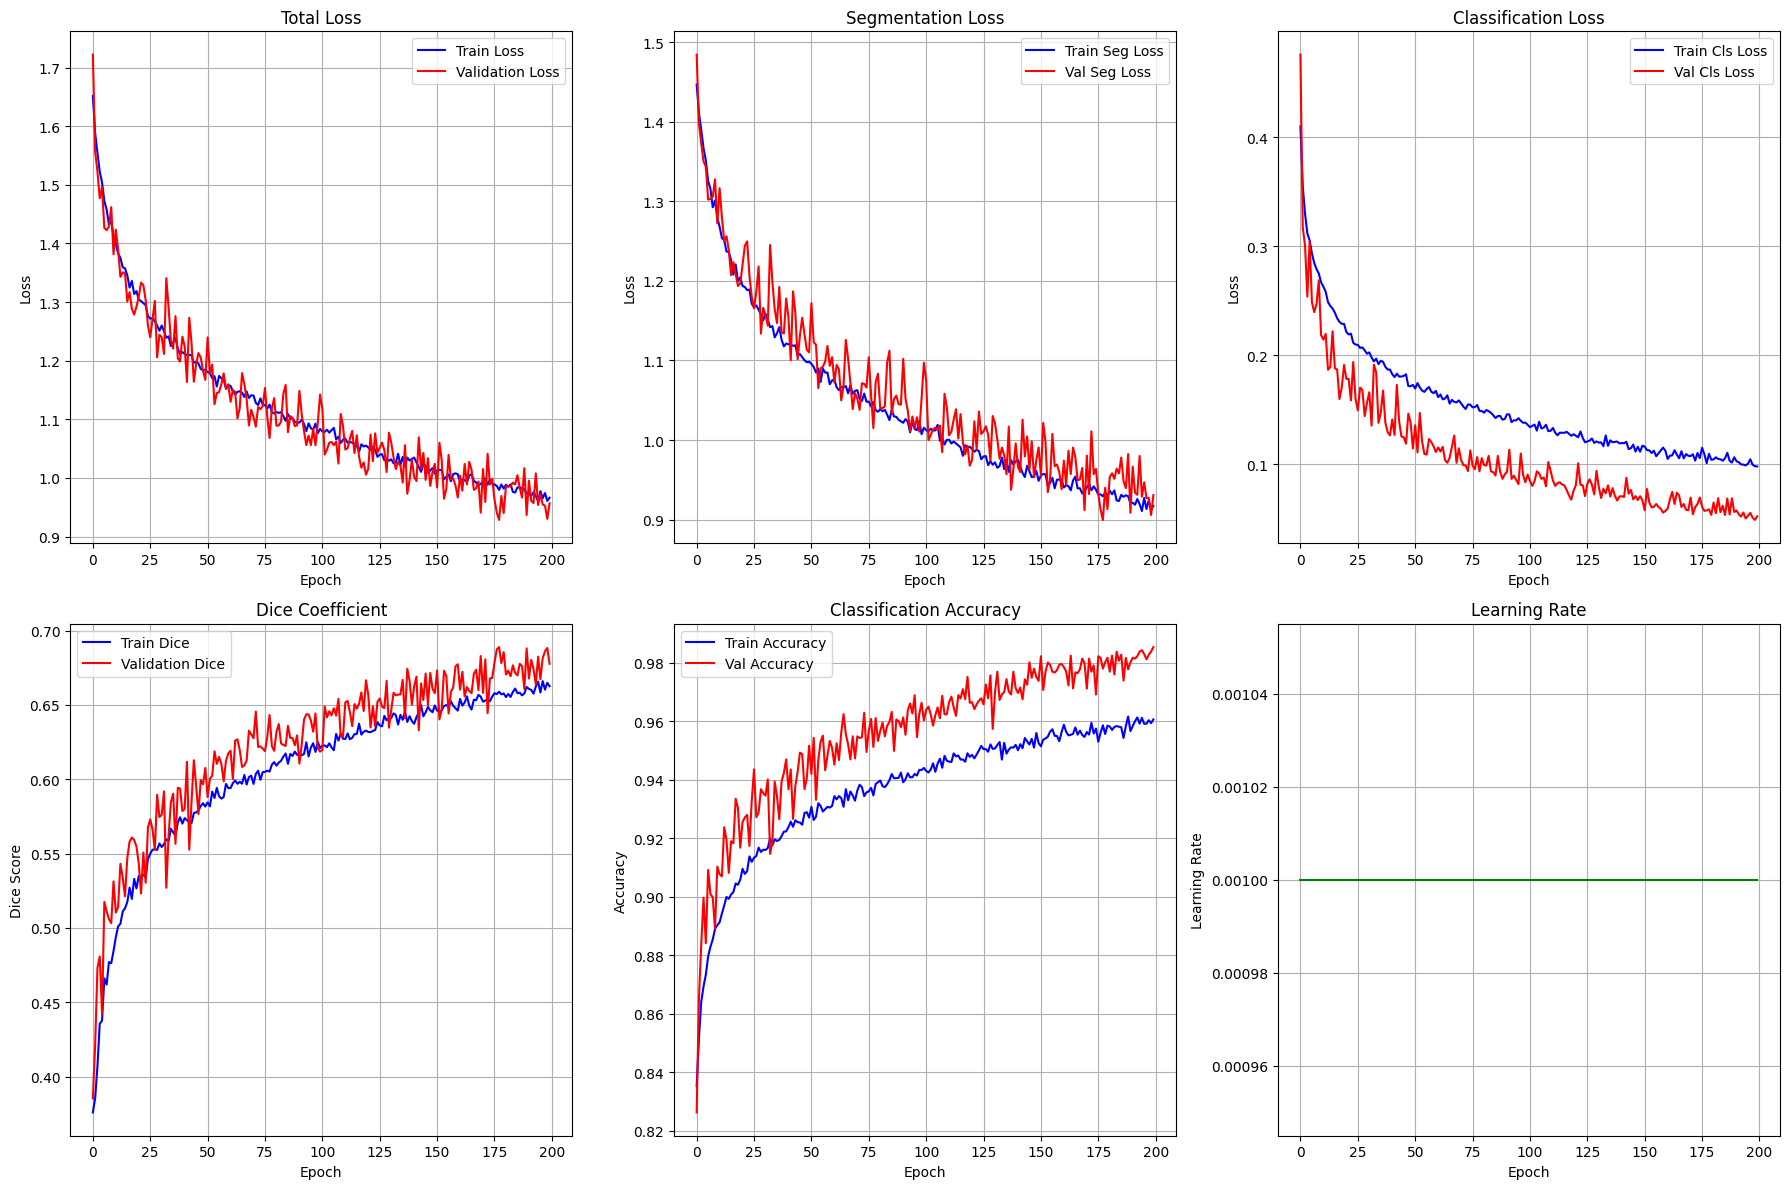


Training completed!
Best validation loss: 0.928424


Validation: 100%|██████████| 15/15 [00:01<00:00,  7.95it/s, Loss=1.0199, Dice=0.6356, Acc=0.9746]

loss: 0.8971155643463135, seg_loss: 0.8622040629386902, cls_loss: 0.06982298369208971, dice: 0.6826244354248047, cls_acc: 0.976781443754832


In [17]:
CONFIG = {
    'working_path': 'train-256',
    'batch_size': 80,
    'export_type': 'RGBN',
    'input_channels': 4,  # 1 for NDVI, 3 for RGB, 4 for RGBN
    'num_classes': 6,
    'filters_base': 32,
    'dropout_rate': 0.15,
    'learning_rate': 0.001,
    'num_epochs': epochs,
    'seg_weight': 1.0,
    'cls_weight': 0.5,
    'pos_weight': 2.0,
    'augmentation': True,
    'num_workers': 16
}

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Create datasets
print("Creating datasets...")
train_dataloader, val_dataloader, test_dataloader = create_pytorch_datasets(
    working_path=CONFIG['working_path'],
    batch_size=CONFIG['batch_size'],
    export_type=CONFIG['export_type'],
    augmentation=CONFIG['augmentation'],
    test_size=0.20,  # 20%
    val_size=0.05    # 5%
)

print(f"Training samples: {len(train_dataloader.dataset)}")
print(f"Validation samples: {len(val_dataloader.dataset)}")
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")

print("Creating model...")
model = OptimizedMultiTaskUNet256(
    input_channels=CONFIG['input_channels'],
    num_classes=CONFIG['num_classes'],
    filters_base=CONFIG['filters_base'],
    dropout_rate=CONFIG['dropout_rate']
)


# model = model.load_state_dict(torch.load("results/rgbn_multitask.pth"))


# model = torch.load("results/ndvi_multitask.pth")

trainer_rgbn_256 = ModelTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=CONFIG['learning_rate'],
    seg_weight=CONFIG['seg_weight'],
    cls_weight=CONFIG['cls_weight'],
    pos_weight=CONFIG['pos_weight'],
    model_name="rgbn-256"
)

history = trainer_rgbn_256.train(CONFIG['num_epochs'])
trainer_rgbn_256.val_dataloader = test_dataloader
test_loss, test_seg_loss, test_cls_loss, test_dice, test_cls_acc = trainer_rgbn_256.validate_epoch()
print(f'loss: {test_loss}, seg_loss: {test_seg_loss}, cls_loss: {test_cls_loss}, dice: {test_dice}, cls_acc: {test_cls_acc}')